# Necessary Imports

In [84]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
from multimode_expts.analysis_notebooks.expts_run_base import *

In [86]:
expts_base_inst = expts_run_base(data_path=r'H:\Shared drives\SLab\Multimode\experiment\250505_craqm', 
                            config_name='hardware_config_202505.yml',
                              exp_param_name='experiment_config.yml', qubit_i=0)

path:  H:\Shared drives\SLab\Multimode\experiment\250505_craqm
Data will be stored in H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data
Hardware configs will be read from C:\_Lib\python\multimode_expts\configs\hardware_config_202505.yml
Experiment params will be read from C:\_Lib\python\multimode_expts\configs\experiment_config.yml
<Pyro4.core.Proxy at 0x237ff3cd940; not connected; for PYRO:obj_cf917ef6a3974186b155568f0c03d03f@192.168.137.101:34989>
Path added at highest priority
['C:\\_Lib\\python\\multimode_expts', 'C:\\_Lib\\python\\multimode_expts', 'C:\\_Lib\\python\\multimode_expts', 'C:\\_Lib\\python\\multimode_expts', 'C:\\_Lib\\python\\multimode_expts', 'C:\\_Lib\\python', 'C:\\_Lib\\python\\slab', 'C:\\_Lib\\python\\qick\\qick_lib', 'C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts', 'c:\\_Lib\\python\\multimode_expts\\analysis_notebooks\\bosonic', 'c:\\Users\\26049\\.conda\\envs\\slab\\python38.zip', 'c:\\Users\\26049\\.conda\\envs\\slab\\DLLs', 'c:\\Users\

# Multiphoton Calibration

In [87]:
from MM_dual_rail_base import MM_dual_rail_base
mm_base_calib = MM_dual_rail_base(expts_base_inst.config_thisrun)
multiphoton_cfg_thisrun = AttrDict(deepcopy(mm_base_calib.multiphoton_cfg))

## $\pi$-pulses for fock n

### Ramsey for the frequency

In [232]:
def do_t2_ramsey(
    config_thisrun,
    expt_path,
    config_path,
    pre_sweep_pulse=None,
    post_sweep_pulse=None,
    step_size=0.05,
    if_ef=False,
    ef_init=True, # redundant
    start=0.01,
    expts=75,
    ramsey_freq=0.5,
    reps=250,
    rounds=1,
    qubits=[0],
    user_defined_freq=[False, 3568.2038290468167, 5304, 0.035],
    f0g1_cavity=0,
    normalize=False,
    active_reset=False,
    man_reset=True,
    storage_reset=False,
    prepulse=None,
    postpulse=None,
    pre_active_reset_pulse=False,
    gate_based=False,
    advance_phase=0,
    echoes=[False, 0],
    relax_delay=2500
):
    """Run the T2 Ramsey experiment with all config params as function arguments."""
    t2ramsey = expts_base_inst.meas.single_qubit.t2_ramsey.RamseyExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='RamseyExperiment', config_file=config_path
    )

    t2ramsey.cfg = AttrDict(deepcopy(config_thisrun))
    checkEF = False
    qubit_ge_init = False
    qubit_ge_after = False
    if if_ef:
        checkEF = True
        qubit_ge_init = True if ef_init else False
        qubit_ge_after = True if ef_init else False

    t2ramsey.cfg.expt = {
        'start': start,
        'step': step_size,
        'expts': expts,
        'ramsey_freq': ramsey_freq,
        'reps': reps,
        'rounds': rounds,
        'qubits': qubits,
        'checkEF': checkEF,
        'user_defined_freq': user_defined_freq,
        'qubit_ge_init': qubit_ge_init,
        'qubit_ge_after': qubit_ge_after,
        'f0g1_cavity': f0g1_cavity,
        'normalize': normalize,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'prepulse': False if pre_sweep_pulse is None else True if prepulse is None else prepulse,
        'postpulse': False if post_sweep_pulse is None else True if postpulse is None else postpulse,
        'pre_active_reset_pulse': pre_active_reset_pulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'post_sweep_pulse': post_sweep_pulse,
        'gate_based': gate_based,
        'advance_phase': advance_phase,
        'echoes': echoes
    }

    t2ramsey.cfg.device.readout.relax_delay = [relax_delay]  # Wait time between experiments [us]
    t2ramsey.go(analyze=False, display=False, progress=True, save=True)
    from multimode_expts.fit_display_classes import RamseyFitting
    t2ramsey_analysis = RamseyFitting(
        t2ramsey.data, config=t2ramsey.cfg,
    )
    return t2ramsey_analysis

### Rabi for the amplitude

In [233]:
def do_amplitude_rabi(
    config_thisrun,
    expt_path,
    config_path,
    start=50,
    step=200,
    expts=75,
    reps=200,
    rounds=1,
    sigma_test=None,
    qubit=0,
    pulse_type='gauss',
    drag_beta=0.0,
    pulse_ge_init=False,
    pulse_ge_after=False,
    checkZZ=False,
    checkEF=False,
    qubits=[0],
    flat_length=0,
    normalize=False,
    single_shot=False,
    singleshot_reps=10000,
    span=50,
    user_defined_freq=[False, 3568.203829046816],
    prepulse=False,
    pre_sweep_pulse=None,
    post_sweep_pulse=None,
    postpulse=False,
    gate_based=False,
    relax_delay=2500,
    if_ef=False
):
    """Run the amplitude Rabi experiment with all config params as function arguments."""
    amprabi = expts_base_inst.meas.single_qubit.amplitude_rabi.AmplitudeRabiExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='AmplitudeRabiExperiment', config_file=config_path
    )

    amprabi.cfg = AttrDict(deepcopy(config_thisrun))
    pulse_ge = config_thisrun.device.qubit.pulses.pi_ge

    if sigma_test is None:
        sigma_test = pulse_ge.sigma[0]

    if if_ef:
        checkEF = True
        pulse_ge_init = True
        pulse_ge_after = True

    amprabi.cfg.expt = dict(
        start=start,
        step=step,
        expts=expts,
        reps=reps,
        rounds=rounds,
        sigma_test=sigma_test,
        qubit=qubit,
        pulse_type=pulse_type,
        drag_beta=drag_beta,
        pulse_ge_init=pulse_ge_init,
        pulse_ge_after=pulse_ge_after,
        checkZZ=checkZZ,
        checkEF=checkEF,
        qubits=qubits,
        flat_length=flat_length,
        normalize=normalize,
        single_shot=single_shot,
        singleshot_reps=singleshot_reps,
        span=span,
        user_defined_freq=user_defined_freq,
        prepulse=prepulse,
        postpulse=postpulse,
        pre_sweep_pulse=pre_sweep_pulse if pre_sweep_pulse is not None else [],
        post_sweep_pulse=post_sweep_pulse if post_sweep_pulse is not None else [],
        gate_based=gate_based
    )
    amprabi.cfg.device.readout.relax_delay = [relax_delay]
    amprabi.go(analyze=False, display=False, progress=True, save=True)
    return amprabi

### define the transition we want to calibrate

In [77]:
transition = 'g0-e0'

i = int(transition[1])
pre_sweep_pulse = mm_base_calib.prep_man_photon(man_no=1, photon_no=i)
print(f"pre_sweep_pulse: {pre_sweep_pulse}")
postpulse = False
if transition[0] == 'e':
    pre_sweep_pulse.append(['multiphoton', 'g'+str(i)+'-e'+str(i), 'pi', 0])
    postpulse = True,
    post_pulse = [['multiphoton', 'g'+str(i)+'-e'+str(i), 'pi', 0]]  # post pulse is the same as prepulse
    post_pulse = mm_base_calib.get_prepulse_creator(post_pulse, multiphoton_cfg_thisrun).pulse.tolist()
    # post_pulse = mm_base_calib.get_prepulse_creator(post_pulse).pulse.tolist()

# pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, multiphoton_cfg_thisrun).pulse.tolist()
pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, multiphoton_cfg_thisrun).pulse.tolist()

pre_sweep_pulse: []


In [237]:
t2ramsey_any = do_t2_ramsey(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file, 
    user_defined_freq=[True,
                       multiphoton_cfg_thisrun.pulses['hpi_' + transition]['frequency'],
                         multiphoton_cfg_thisrun.pulses['hpi_' + transition]['gain'],
                           multiphoton_cfg_thisrun.pulses['hpi_' + transition]['sigma']],
    prepulse = True, 
    postpulse = postpulse,
    gate_based = False,
    pre_sweep_pulse = pre_sweep_pulse,
    post_sweep_pulse=post_pulse,
    ramsey_freq=0.5,
)

# pre_sweep_pulse = None
# t2ramsey_any = do_t2_ramsey(expts_base_inst.config_thisrun,
#                              expts_base_inst.expt_path,
#                                expts_base_inst.config_file, step_size=0.2,
#                                  pre_sweep_pulse=pre_sweep_pulse,
#                                  user_defined_freq=[True,
#                        multiphoton_cfg_thisrun.pulses['hpi_' + transition]['frequency'],
#                          multiphoton_cfg_thisrun.pulses['hpi_' + transition]['gain'],
#                            multiphoton_cfg_thisrun.pulses['hpi_' + transition]['sigma']],
#                            prepulse = True, 
#                            postpulse = postpulse,
#                             gate_based = False,
#                                  relax_delay=2500)

fge is  3567.3506008394015
fef is  3423.990931159239


  0%|          | 0/18750 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00373_RamseyExperiment.h5


No echoes in the data
Attempted to init fitparam 1 to 7.567567567567567, which is out of bounds 0.0273972602739726 to 4.10958904109589. Instead init to 2.0684931506849313
Attempted to init fitparam 1 to 6.216216216216215, which is out of bounds 0.0273972602739726 to 4.10958904109589. Instead init to 2.0684931506849313
Using user defined frequency: 3564.182673719911 MHz
Current pi pulse frequency: 3564.182673719911
Fit frequency from I [MHz]: 2.435132149924296 +/- 0.0013188017015651878
Suggested new pi pulse frequency from fit I [MHz]:
 	3562.2475415699864
 	3567.117805869835
T2 Ramsey from fit I [us]: 46.412682354106884
Fit frequency from Q [MHz]: 2.436309347562016 +/- 0.003107118158197961
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3562.2463643723486
 	3567.118983067473
T2 Ramsey from fit Q [us]: 22.74030732396483


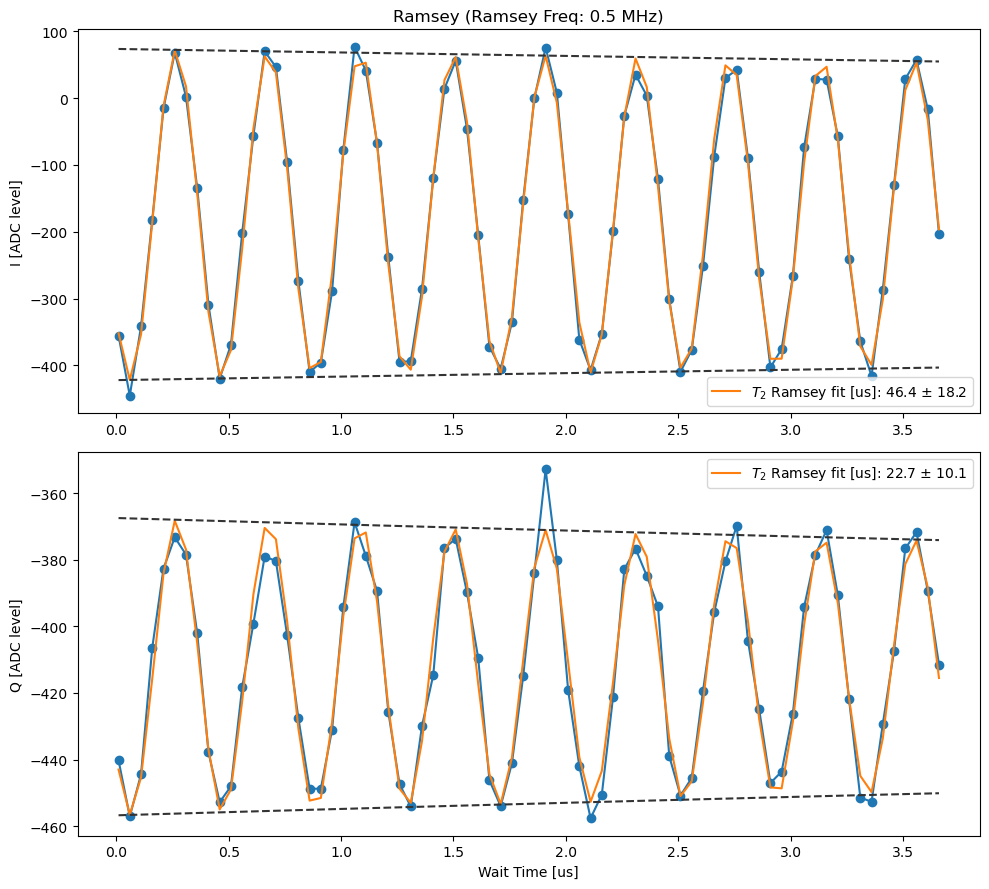

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-07-02_21-49-21_Ramsey.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-07-02.md


In [238]:
t2ramsey_any.analyze()
# t2ramsey_any.analyze(fitparams=[500, 0.1, None, 200, None, None])
t2ramsey_any.display()

In [224]:
print("Qubit frequency before update:",multiphoton_cfg_thisrun.pulses['hpi_' + transition]['frequency'])
print("Qubit frequency before update:",multiphoton_cfg_thisrun.pulses['pi_' + transition]['frequency'])
multiphoton_cfg_thisrun.pulses['hpi_' + transition]['frequency']  += min(t2ramsey_any.data['f_adjust_ramsey_avgi'])
multiphoton_cfg_thisrun.pulses['pi_' + transition]['frequency']  += min(t2ramsey_any.data['f_adjust_ramsey_avgi'])
print('Updated qubit frequency to:',multiphoton_cfg_thisrun.pulses['hpi_' + transition]['frequency'])
print('Updated qubit frequency to:',multiphoton_cfg_thisrun.pulses['pi_' + transition]['frequency'])

Qubit frequency before update: 3565.1854103187907
Qubit frequency before update: 3565.1854103187907
Updated qubit frequency to: 3564.069248702629
Updated qubit frequency to: 3564.069248702629


In [239]:
amprabi_any = do_amplitude_rabi(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    sigma_test=multiphoton_cfg_thisrun.pulses['pi_' + transition]['sigma'],
    qubit=0,
    user_defined_freq=[True, multiphoton_cfg_thisrun.pulses['pi_' + transition]['frequency']],
    prepulse=True,
    postpulse=postpulse,
    gate_based=False,
    pre_sweep_pulse=pre_sweep_pulse,
    post_sweep_pulse=post_pulse
)

  0%|          | 0/15000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00064_AmplitudeRabiExperiment.h5


Pi gain from avgi data [dac units]: 15831
	Pi/2 gain from avgi data [dac units]: 8140
Pi gain from avgq data [dac units]: 16005
	Pi/2 gain from avgq data [dac units]: 8418


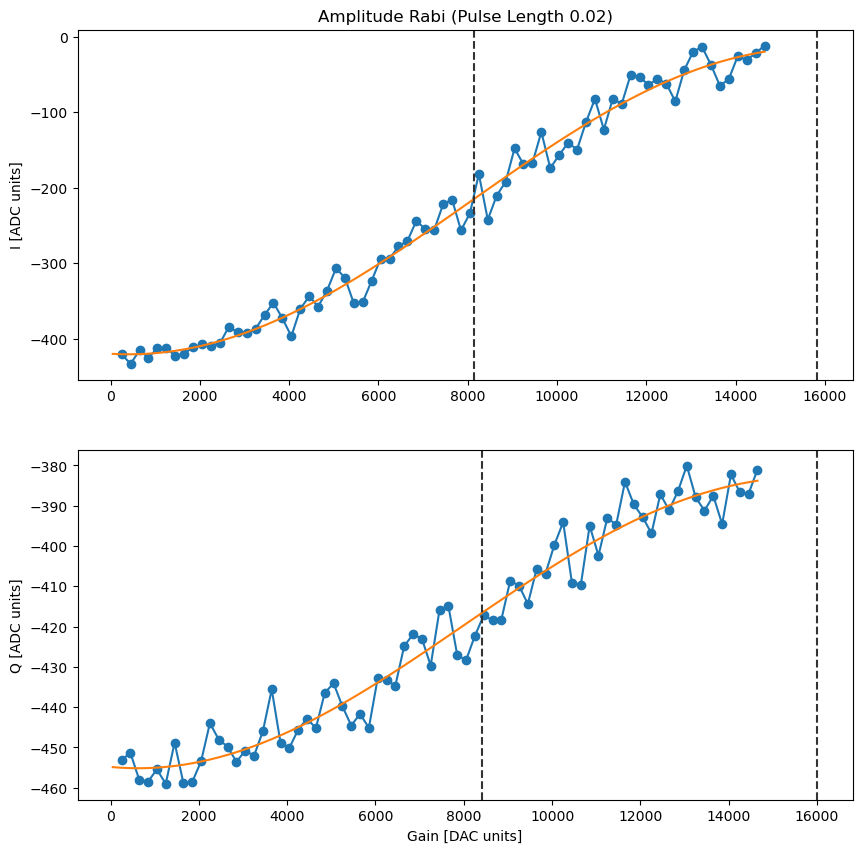

In [240]:
# amprabi_any.analyze(fitparams=[np.max(amprabi_any.data['amps']), 0.00001, 90, None, None, None])
amprabi_any.analyze()
amprabi_any.display(title_str='Amplitude Rabi_ge', save_fig=True)

In [241]:
print("Qubit hpi gain before update:",multiphoton_cfg_thisrun.pulses['hpi_' + transition]['gain'])
multiphoton_cfg_thisrun.pulses['hpi_' + transition]['gain'] = amprabi_any.data['hpi_gain_avgi']
print('Updated hpi gain to:',multiphoton_cfg_thisrun.pulses['hpi_' + transition]['gain'])

print("Qubit pi gain before update:",multiphoton_cfg_thisrun.pulses['pi_' + transition]['gain'])
multiphoton_cfg_thisrun.pulses['pi_' + transition]['gain'] = amprabi_any.data['pi_gain_avgi']
print('Updated pi gain to:',multiphoton_cfg_thisrun.pulses['pi_' + transition]['gain'])

Qubit hpi gain before update: 8655
Updated hpi gain to: 8140
Qubit pi gain before update: 16959
Updated pi gain to: 15831


In [244]:
multiphoton_cfg_thisrun.pulses['pi_g0-e0']['sigma']

0.02

### define the sideband we want to calibrate

In [17]:
sideband = 'f3-g4'
i = int(sideband[1])
pre_sweep_pulse = mm_base_calib.prep_man_photon(man_no=1, photon_no=i)
print(f"pre_sweep_pulse: {pre_sweep_pulse}")
pre_sweep_pulse.append(['multiphoton', 'g'+str(i)+'-e'+str(i), 'pi', 0])
pre_sweep_pulse.append(['multiphoton', 'e'+str(i)+'-f'+str(i), 'pi', 0])
pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, multiphoton_cfg_thisrun).pulse.tolist()

pre_sweep_pulse: [['multiphoton', 'g0-e0', 'pi', 0], ['multiphoton', 'e0-f0', 'pi', 0], ['multiphoton', 'f0-g1', 'pi', 0], ['multiphoton', 'g1-e1', 'pi', 0], ['multiphoton', 'e1-f1', 'pi', 0], ['multiphoton', 'f1-g2', 'pi', 0], ['multiphoton', 'g2-e2', 'pi', 0], ['multiphoton', 'e2-f2', 'pi', 0], ['multiphoton', 'f2-g3', 'pi', 0]]
multiphoton_cfg 3567.3608840739785


In [916]:
pre_sweep_pulse

[[3567.3608840739785,
  3423.9884929737523,
  2005.8600000000006,
  3567.0799647644612,
  3423.7266366015674,
  2005.3250648263681,
  3566.7644237298246,
  3423.464917683452,
  2004.900423280029,
  3566.4633477474954,
  3423.2192518006295],
 [19013, 9137, 15000, 10480, 9159, 15000, 10373, 9266, 15000, 10349, 9239],
 [0,
  0,
  1.0955314021401903,
  0,
  0,
  0.7774181220945486,
  0,
  0,
  0.6274662037166608,
  0,
  0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2],
 ['gauss',
  'gauss',
  'flat_top',
  'gauss',
  'gauss',
  'flat_top',
  'gauss',
  'gauss',
  'flat_top',
  'gauss',
  'gauss'],
 [0.02, 0.035, 0.005, 0.035, 0.035, 0.005, 0.035, 0.035, 0.005, 0.035, 0.035]]

In [917]:
def do_pulse_probe_any(
    config_thisrun,
    ds_thisrun,
    man_mode_no=1,
    start=2003,
    step=0.01,
    expts=500,
    reps=100,
    rounds=1,
    length=1,
    gain=5000,
    pulse_type='gaussian',
    qubit_f=False,
    qubits=[0],
    prepulse=True,
    pre_sweep_pulse=pre_sweep_pulse,
    relax_delay=200
):
    """
    Run the Pulse Probe F0g1 Spectroscopy experiment with configurable parameters.
    """
    qspec = expts_base_inst.meas.single_qubit.pulse_probe_f0g1_spectroscopy.PulseProbeF0g1SpectroscopyExperiment(
        soccfg=expts_base_inst.soc, path=expts_base_inst.expt_path, prefix='PulseProbeF0g1SpectroscopyExperiment', config_file=expts_base_inst.config_file
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    if start is None:
        start = ds_thisrun.get_freq('M' + str(man_mode_no)) - 5
    if pre_sweep_pulse is None:
        pre_sweep_pulse = [[3569.4827896982997], [11161], [0], [0], [2], ['g'], [0.035]]

    qspec.cfg.expt = {
        'start': start,
        'step': step,
        'expts': expts,
        'reps': reps,
        'rounds': rounds,
        'length': length,
        'gain': gain,
        'pulse_type': pulse_type,
        'qubit_f': qubit_f,
        'qubits': qubits,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse
    }

    qspec.cfg.device.readout.relax_delay = [relax_delay]
    qspec.go(analyze=False, display=False, progress=True, save=True)
    return qspec

def analyze_and_display_pulse_probe_any(qspec):
    from multimode_expts.fit_display_classes import Spectroscopy
    spec_analysis = Spectroscopy(
        qspec.data)
    spec_analysis.analyze(fit=True)
    spec_analysis.display()

multiphoton_cfg 3567.3608840739785
Adding pulse ['ge', 'hpi', 0] to channel qubit
Adding pulse ['ge', 'parity_M1', 0] to channel qubit
Adding pulse ['ge', 'hpi', 180] to channel qubit


  0%|          | 0/50000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00073_PulseProbeF0g1SpectroscopyExperiment.h5
Found peak in amps at [MHz] 2005.3344951173465, HWHM 1.4199661003308048
Found peak in I at [MHz] 2005.3383926084928, HWHM 1.4609621972056934
Found peak in Q at [MHz] 2005.3245381591064, HWHM 1.4303248414505358


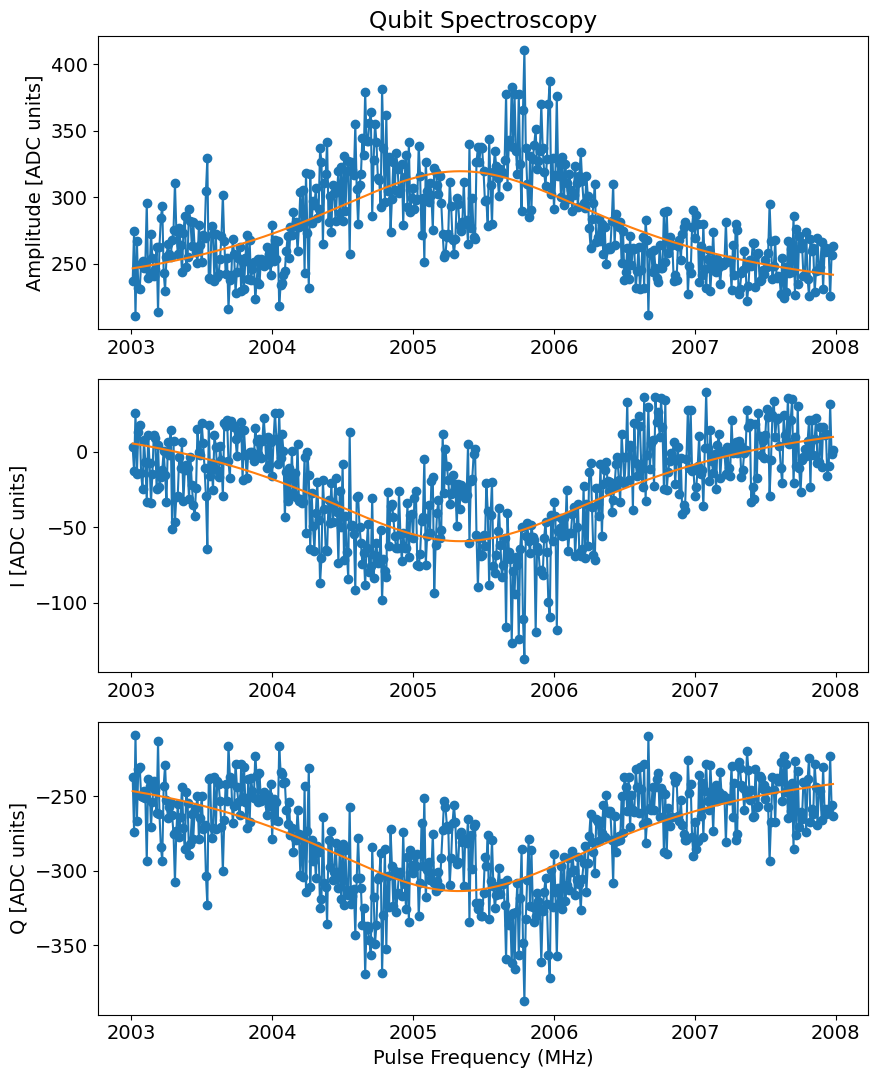

In [ ]:
man_spec = do_pulse_probe_any(expts_base_inst.config_thisrun,
                                expts_base_inst.ds_thisrun, 
                                man_mode_no = 1, 
                                prepulse = True, pre_sweep_pulse=pre_sweep_pulse)
analyze_and_display_pulse_probe_any(man_spec)

In [845]:
print("Transition frequency before update:",  multiphoton_cfg_thisrun.pulses['pi_' + sideband]['frequency'])
multiphoton_cfg_thisrun.pulses['pi_' + sideband]['frequency'] =  man_spec.data['fit_avgi'][2]
print('Updated transition frequency to:',  multiphoton_cfg_thisrun.pulses['pi_' + sideband]['frequency'])

Transition frequency before update: 2005.5193707417802
Updated transition frequency to: 2005.2304232800277


In [846]:
def do_length_rabi_any_sweep(
    config_thisrun,
    expt_path,
    config_path,
    freq_start,
    freq_stop,
    freq_step,
    start=2,
    step=0.1,
    qubits=[0],
    expts=25,
    reps=300,
    rounds=1,
    gain=15000,
    ramp_sigma=0.005,
    use_arb_waveform=False,
    pi_ge_before=False,
    pi_ef_before=False,
    pi_ge_after=False,
    normalize=False,
    active_reset=False,
    check_man_reset=[False, 0],
    check_man_reset_pi=[],
    prepulse=True,
    postpulse=postpulse,
    pre_sweep_pulse=None,
    post_sweep_pulse=post_pulse,
    err_amp_reps=0
):
    """Run the Length Rabi General F0g1 Experiment Sweep with configurable parameters."""
    from multimode_expts.sequential_experiment_classes import man_f0g1_class
    experiment_class = man_f0g1_class
    sweep_experiment_name = 'length_rabi_f0g1_sweep'
    class_for_exp = experiment_class(
        soccfg=expts_base_inst.soc,
        path=expt_path,
        prefix=sweep_experiment_name,
        config_file=config_path,
        exp_param_file=expts_base_inst.exp_param_file,
        config_thisrun=config_thisrun
    )

    class_for_exp.loaded[sweep_experiment_name] = {
        'freq_start': freq_start,
        'freq_stop': freq_stop,
        'freq_step': freq_step,
        'start': start,
        'step': step,
        'qubits': qubits,
        'expts': expts,
        'reps': reps,
        'rounds': rounds,
        'gain': gain,
        'ramp_sigma': ramp_sigma,
        'use_arb_waveform': use_arb_waveform,
        'pi_ge_before': pi_ge_before,
        'pi_ef_before': pi_ef_before,
        'pi_ge_after': pi_ge_after,
        'normalize': normalize,
        'active_reset': active_reset,
        'check_man_reset': check_man_reset,
        'check_man_reset_pi': check_man_reset_pi,
        'prepulse': prepulse,
        'postpulse': postpulse,
        'post_sweep_pulse': post_pulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'err_amp_reps': err_amp_reps,
    }
    return eval('class_for_exp.run_sweep')(sweep_experiment_name=sweep_experiment_name)


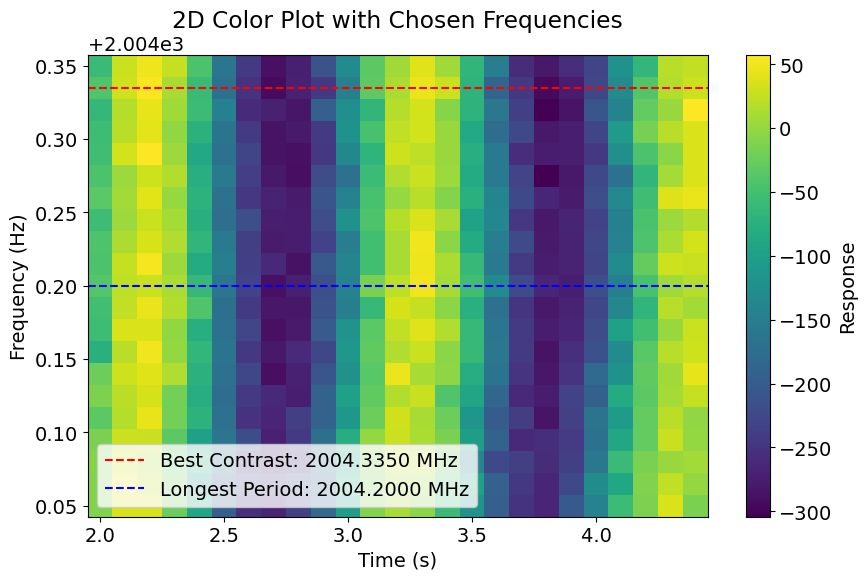

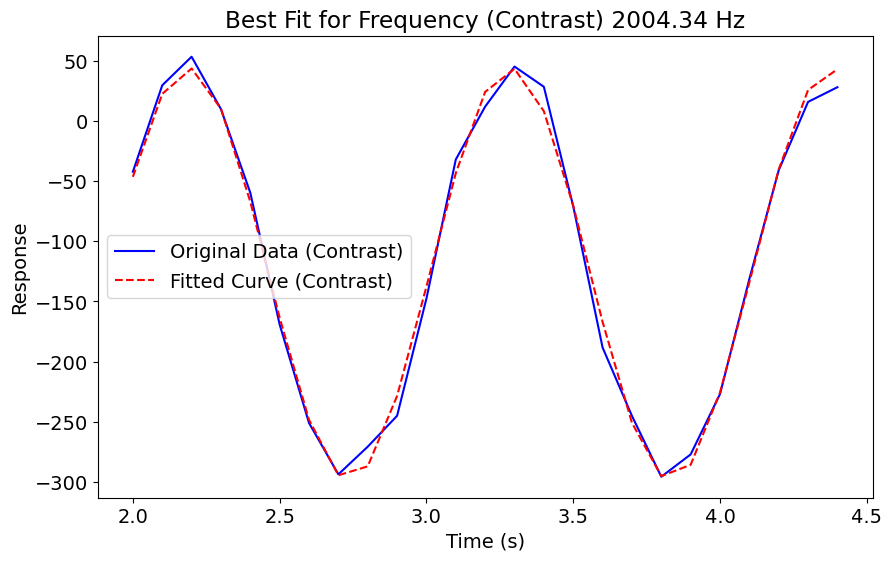

In [919]:
guess_freq =  multiphoton_cfg_thisrun.pulses['pi_' + sideband]['frequency']
guess_freq = 2004.2
freq_start = guess_freq- 0.15
freq_stop = guess_freq + 0.15
# freq_start = guess_freq- 0.1
# freq_stop = guess_freq + 0.1
freq_step = 0.015
man_chevrons = do_length_rabi_any_sweep(expts_base_inst.config_thisrun, expts_base_inst.expt_path, expts_base_inst.config_file, 
                                                freq_start, freq_stop, freq_step,
                                                prepulse = True, 
                                                pre_sweep_pulse= pre_sweep_pulse,
                                                postpulse = postpulse ,
                                                post_sweep_pulse=post_pulse,
                                                )

In [920]:
print("Transition frequency before update:",  multiphoton_cfg_thisrun.pulses['pi_' + sideband]['frequency'])
multiphoton_cfg_thisrun.pulses['pi_' + sideband]['frequency'] =  man_chevrons.results['best_frequency_contrast']
print('Updated transition frequency to:',  multiphoton_cfg_thisrun.pulses['pi_' + sideband]['frequency'])

Transition frequency before update: 2004.3050000000017
Updated transition frequency to: 2004.3350000000019


In [921]:
def do_length_rabi_f0g1_general(
    config_thisrun,
    ds_thisrun,
    expt_path,
    config_path,
    man_mode_no=1,
    start=None,
    step=0.015,
    qubits=[0],
    expts=150,
    reps=100,
    rounds=1,
    gain=15000,
    freq=None,
    use_arb_waveform=False,
    pi_ge_before=False,
    pi_ef_before=False,
    pi_ge_after=False,
    normalize=False,
    active_reset=False,
    man_reset=True,
    stor_reset=True,
    check_man_reset=[False, 0],
    swap_lossy=False,
    check_man_reset_pi=[],
    prepulse=True,
    postpulse=postpulse,
    post_sweep_pulse=None,
    pre_sweep_pulse=None,
    err_amp_reps=0,
    relax_delay=2500
):
    """
    Run the Length Rabi General F0g1 Experiment with all config params as function arguments.
    """
    length_rabi = expts_base_inst.meas.single_qubit.length_rabi_f0g1_general.LengthRabiGeneralF0g1Experiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='LengthRabiGeneralF0g1Experiment', config_file=config_path
    )

    length_rabi.cfg = AttrDict(deepcopy(config_thisrun))

    if freq is None:
        freq = ds_thisrun.get_freq('M' + str(man_mode_no))
    if start is None:
        start = expts_base_inst.soc.cycles2us(3)
    if pre_sweep_pulse is None:
        pre_sweep_pulse = []

    length_rabi.cfg.expt = dict(
        start=start,
        step=step,
        qubits=qubits,
        expts=expts,
        reps=reps,
        rounds=rounds,
        gain=gain,
        freq=freq,
        use_arb_waveform=use_arb_waveform,
        pi_ge_before=pi_ge_before,
        pi_ef_before=pi_ef_before,
        pi_ge_after=pi_ge_after,
        normalize=normalize,
        active_reset=active_reset,
        man_reset=man_reset,
        stor_reset=stor_reset,
        check_man_reset=check_man_reset,
        swap_lossy=swap_lossy,
        check_man_reset_pi=check_man_reset_pi,
        prepulse=prepulse,
        pre_sweep_pulse=pre_sweep_pulse,
        postpulse=postpulse,
        post_sweep_pulse= post_sweep_pulse,
        err_amp_reps=err_amp_reps,
    )

    length_rabi.cfg.device.readout.relax_delay = [relax_delay]
    length_rabi.go(analyze=False, display=False, progress=True, save=True)

    from multimode_expts.fit_display_classes import LengthRabiFitting
    length_rabi_analysis = LengthRabiFitting(length_rabi.data, config=length_rabi.cfg)
    length_rabi_analysis.analyze()
    length_rabi_analysis.display(title_str='Length Rabi General F0g1')

    return length_rabi_analysis

  0%|          | 0/150 [00:00<?, ?it/s]

multiphoton_cfg 3567.3608840739785
Adding pulse ['ge', 'hpi', 0] to channel qubit
Adding pulse ['ge', 'parity_M1', 0] to channel qubit
Adding pulse ['ge', 'hpi', 180] to channel qubit
multiphoton_cfg 3567.3608840739785
Adding pulse ['ge', 'hpi', 0] to channel qubit
Adding pulse ['ge', 'parity_M1', 0] to channel qubit
Adding pulse ['ge', 'hpi', 180] to channel qubit
multiphoton_cfg 3567.3608840739785
Adding pulse ['ge', 'hpi', 0] to channel qubit
Adding pulse ['ge', 'parity_M1', 0] to channel qubit
Adding pulse ['ge', 'hpi', 180] to channel qubit
multiphoton_cfg 3567.3608840739785
Adding pulse ['ge', 'hpi', 0] to channel qubit
Adding pulse ['ge', 'parity_M1', 0] to channel qubit
Adding pulse ['ge', 'hpi', 180] to channel qubit
multiphoton_cfg 3567.3608840739785
Adding pulse ['ge', 'hpi', 0] to channel qubit
Adding pulse ['ge', 'parity_M1', 0] to channel qubit
Adding pulse ['ge', 'hpi', 180] to channel qubit
multiphoton_cfg 3567.3608840739785
Adding pulse ['ge', 'hpi', 0] to channel qubi

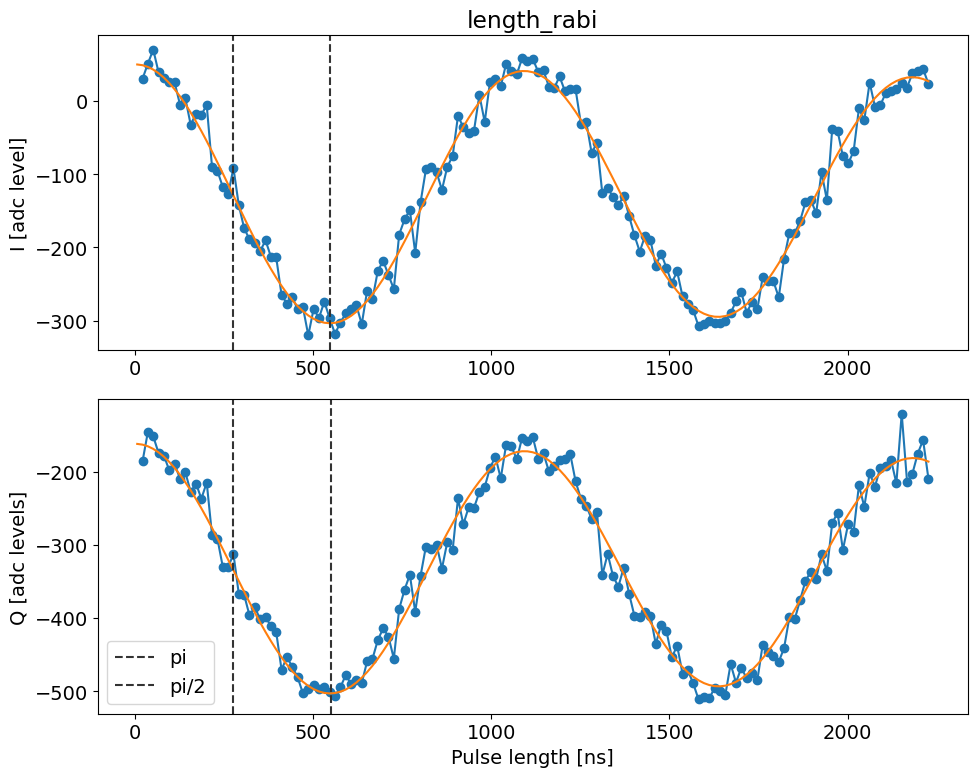

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-07-01_16-02-04_Length_Rabi_General_F0g1.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-07-01.md


In [922]:

len_rabis_mans = do_length_rabi_f0g1_general(expts_base_inst.config_thisrun, expts_base_inst.ds_thisrun,
                                              expts_base_inst.expt_path, expts_base_inst.config_file, man_mode_no= 1,
                                              freq =  multiphoton_cfg_thisrun.pulses['pi_' + sideband]['frequency'],
                                              prepulse=True,pre_sweep_pulse=pre_sweep_pulse, postpulse=postpulse, post_sweep_pulse=post_pulse
                                              )
        

In [923]:
print("Transition length before update:",  multiphoton_cfg_thisrun.pulses['pi_' + sideband]['length'])
multiphoton_cfg_thisrun.pulses['pi_' + sideband]['length'] = len_rabis_mans.results['pi_length']
print('Updated transition length to:',  multiphoton_cfg_thisrun.pulses['pi_' + sideband]['length'])

Transition length before update: 0.5392141852639027
Updated transition length to: 0.5491206701698654


In [164]:
multiphoton_cfg_thisrun

{'pulses': {'hpi_e0-f0': {'frequency': 3423.9884929737523,
   'gain': 4413,
   'length': 0,
   'sigma': 0.035,
   'type': 'gauss'},
  'hpi_e1-f1': {'frequency': 3423.7266366015674,
   'gain': 4390,
   'length': 0,
   'sigma': 0.035,
   'type': 'gauss'},
  'hpi_e2-f2': {'frequency': 3423.464917683452,
   'gain': 4494,
   'length': 0,
   'sigma': 0.035,
   'type': 'gauss'},
  'hpi_e3-f3': {'frequency': 3423.2192518006295,
   'gain': 3860,
   'length': 0,
   'sigma': 0.035,
   'type': 'gauss'},
  'hpi_g0-e0': {'frequency': 3567.342994225626,
   'gain': 9998,
   'length': 0,
   'sigma': 0.015,
   'type': 'gauss'},
  'hpi_g1-e1': {'frequency': 3567.0799647644612,
   'gain': 5146,
   'length': 0,
   'sigma': 0.035,
   'type': 'gauss'},
  'hpi_g2-e2': {'frequency': 3566.7644237298246,
   'gain': 5026,
   'length': 0,
   'sigma': 0.035,
   'type': 'gauss'},
  'hpi_g3-e3': {'frequency': 3566.49698806312,
   'gain': 4856,
   'length': 0,
   'sigma': 0.035,
   'type': 'gauss'},
  'pi_e0-f0': {'fr

## Single shot
To check broadband pulses and recalibrate phase

In [9]:
def do_single_shot(
    config_thisrun,
    expt_path,
    config_path,
    qubits=[0],
    reps=5000,
    check_f=False,
    active_reset=True,
    man_reset=False,
    storage_reset=False,
    qubit=0,
    pulse_manipulate=False,
    cavity_freq=4984.373226159381,
    cavity_gain=800,
    cavity_length=2,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    relax_delay=250
):
    """Run the single shot experiment with configurable parameters."""

   
    hstgrm = expts_base_inst.meas.single_qubit.single_shot.HistogramExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='HistogramExperiment', config_file=config_path
    )

    hstgrm.cfg = AttrDict(deepcopy(config_thisrun))

    hstgrm.cfg.expt = {
        'qubits': qubits,
        'reps': reps,
        'check_f': check_f,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'qubit': qubit,
        'pulse_manipulate': pulse_manipulate,
        'cavity_freq': cavity_freq,
        'cavity_gain': cavity_gain,
        'cavity_length': cavity_length,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'gate_based': gate_based,
    }

    hstgrm.cfg.device.readout.relax_delay = [relax_delay]  # Wait time between experiments [us]
    hstgrm.go(analyze=False, display=False, progress=True, save=True)
    from multimode_expts.fit_display_classes import Histogram
    
    hist_analysis = Histogram(
            hstgrm.data, verbose=True,
             span=800, threshold=None, config=hstgrm.cfg,
        )
    return hstgrm, hist_analysis


def update_single_shot(hist_analysis, config_thisrun):
    """Update the configuration based on single shot experiment results."""
    
    hist_analysis.analyze(plot = True)
    fids = hist_analysis.results['fids']
    confusion_matrix = hist_analysis.results['confusion_matrix']
    thresholds_new = hist_analysis.results['thresholds']
    angle = hist_analysis.results['angle']
    print(fids)

    config_thisrun.device.readout.phase = [config_thisrun.device.readout.phase[0] + angle]
    config_thisrun.device.readout.threshold = thresholds_new
    config_thisrun.device.readout.threshold_list = [thresholds_new]
    config_thisrun.device.readout.Ie = np.median(hist_analysis.data['Ie_rot'])
    config_thisrun.device.readout.Ig = np.median(hist_analysis.data['Ig_rot'])
    if hist_analysis.cfg.expt.active_reset:
        config_thisrun.device.readout.confusion_matrix_with_active_reset = confusion_matrix
    else:
        config_thisrun.device.readout.confusion_matrix_without_reset = confusion_matrix
    print('Updated readout!')

In [10]:
hstgrm = None
hstgrm = do_single_shot(config_thisrun=expts_base_inst.config_thisrun,expt_path=expts_base_inst.expt_path,config_path=expts_base_inst.config_file, 
                        reps = 5000, active_reset=False, relax_delay = 2500)

Creating parity pulse: 1.584663918482869


  0%|          | 0/5000 [00:00<?, ?it/s]

Creating parity pulse: 1.584663918482869


  0%|          | 0/5000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00127_HistogramExperiment.h5
{'device': {'qubit': {'T1': [277.39755232213906], 'f_ge': [3567.3506008394015], 'f_ef': [3423.990931159239], 'ramp_sigma': [0.005], 'ramp_sigma_num': [3.0], 'pulses': {'pi_ge': {'gain': [10748], 'sigma': [0.035], 'length': [0.0], 'type': ['gauss']}, 'hpi_ge': {'gain': [5003], 'length': [0.0], 'sigma': [0.035], 'type': ['gauss']}, 'pi_ef': {'gain': [9161], 'length': [0.0], 'sigma': [0.035], 'type': ['gauss']}, 'hpi_ef': {'gain': [4325], 'sigma': [0.035], 'type': ['gauss']}}, 'T1_ef': [167.85602598963504]}, 'readout': {'trig_offset': [450], 'frequency': [748.8941512875441], 'gain': [800], 'phase': [402.4828965158572], 'threshold': [-298.73630962746415], 'threshold_list': [[-298.73630962746415]], 'man1_drive_list': [0.0], 'man2_drive_list': [0.0], 'readout_length': [1.5], 'relax_delay': [2500], 'confusion_matrix_with_reset': [0.9964530022802125, 0.0035469977197875036, 0.013768302080657598, 0.9

Unrotated:
Ig -299.94372294372295 +/- 79.57115868671777 	 Qg -566.4935064935064 +/- 57.108172611618976 	 Amp g 641.0001012735094
Ie 189.2943722943723 +/- 109.80343449520085 	 Qe -354.0541125541125 +/- 79.59249661530225 	 Amp e 401.48060226964964
updating temp data
Rotated:
Ig -501.78903720820574 +/- 79.11830459166495 	 Qg -399.31961866870233 +/- 57.7339289527901 	 Amp g 641.2865160878216
Ie 32.219154141112966 +/- 117.60995027726871 	 Qe -396.5318022865059 +/- 67.52524964912864 	 Amp e 397.83859053409265


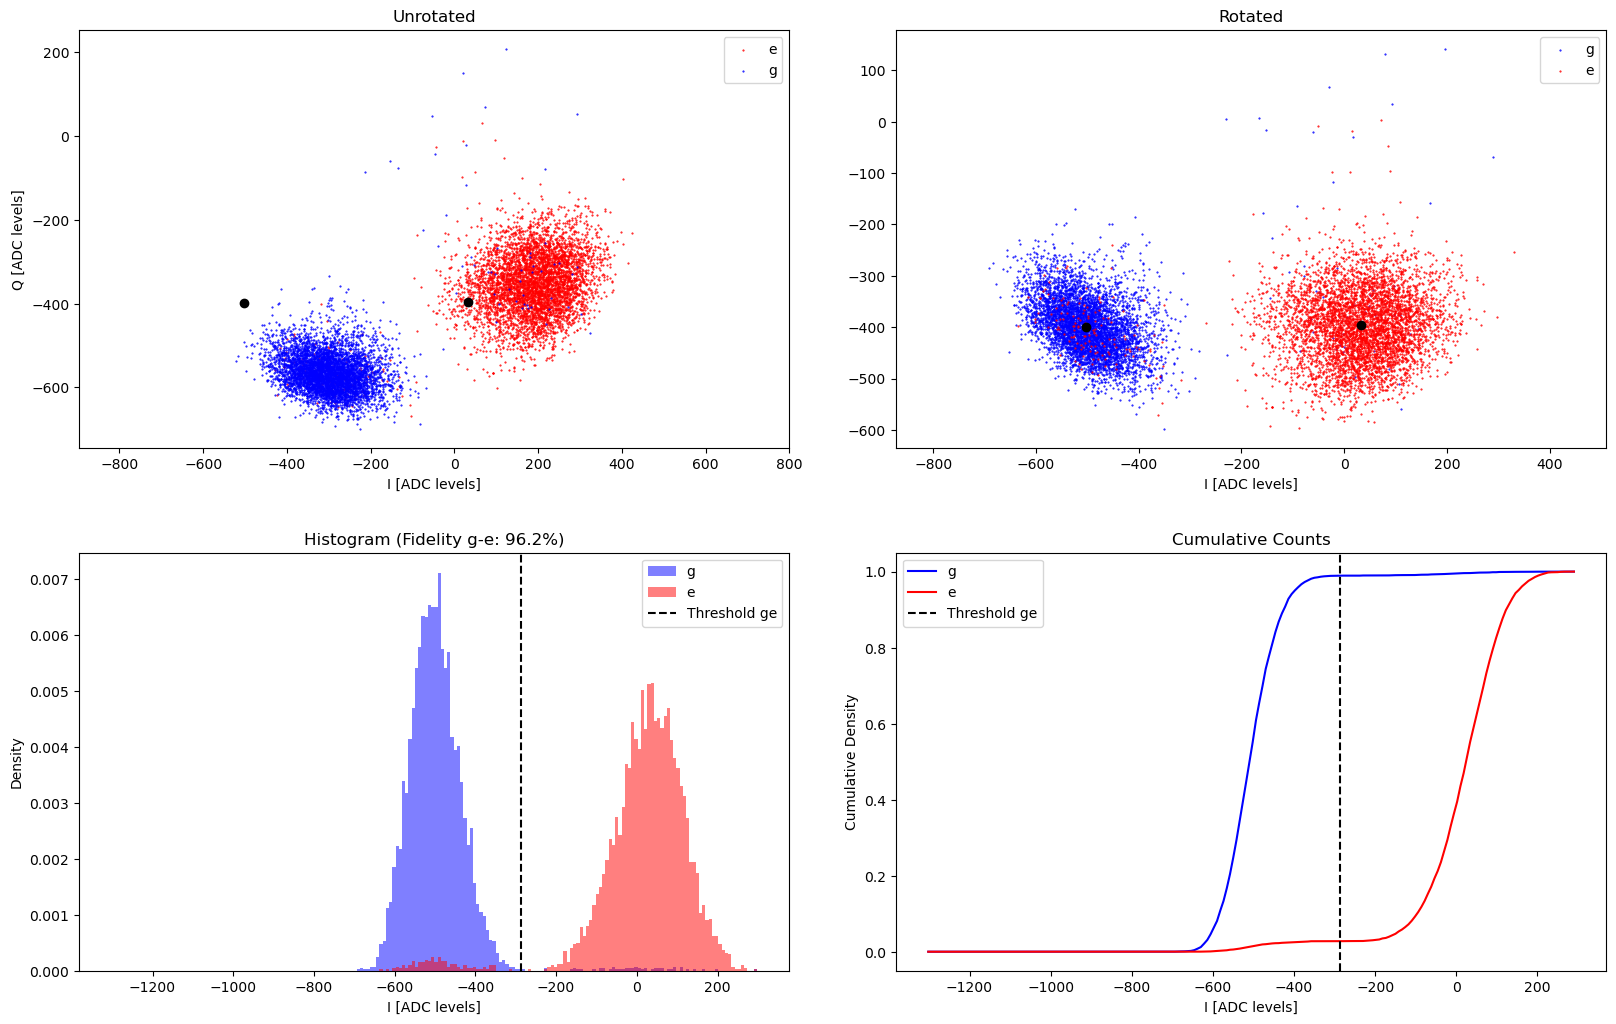

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-07-05_20-27-29_histogram.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-07-05.md


In [11]:
hstgrm[1].analyze(plot = True)

Unrotated:
Ig -299.94372294372295 +/- 79.57115868671777 	 Qg -566.4935064935064 +/- 57.108172611618976 	 Amp g 641.0001012735094
Ie 189.2943722943723 +/- 109.80343449520085 	 Qe -354.0541125541125 +/- 79.59249661530225 	 Amp e 401.48060226964964
updating temp data
Rotated:
Ig -501.78903720820574 +/- 79.11830459166495 	 Qg -399.31961866870233 +/- 57.7339289527901 	 Amp g 641.2865160878216
Ie 32.219154141112966 +/- 117.60995027726871 	 Qe -396.5318022865059 +/- 67.52524964912864 	 Amp e 397.83859053409265


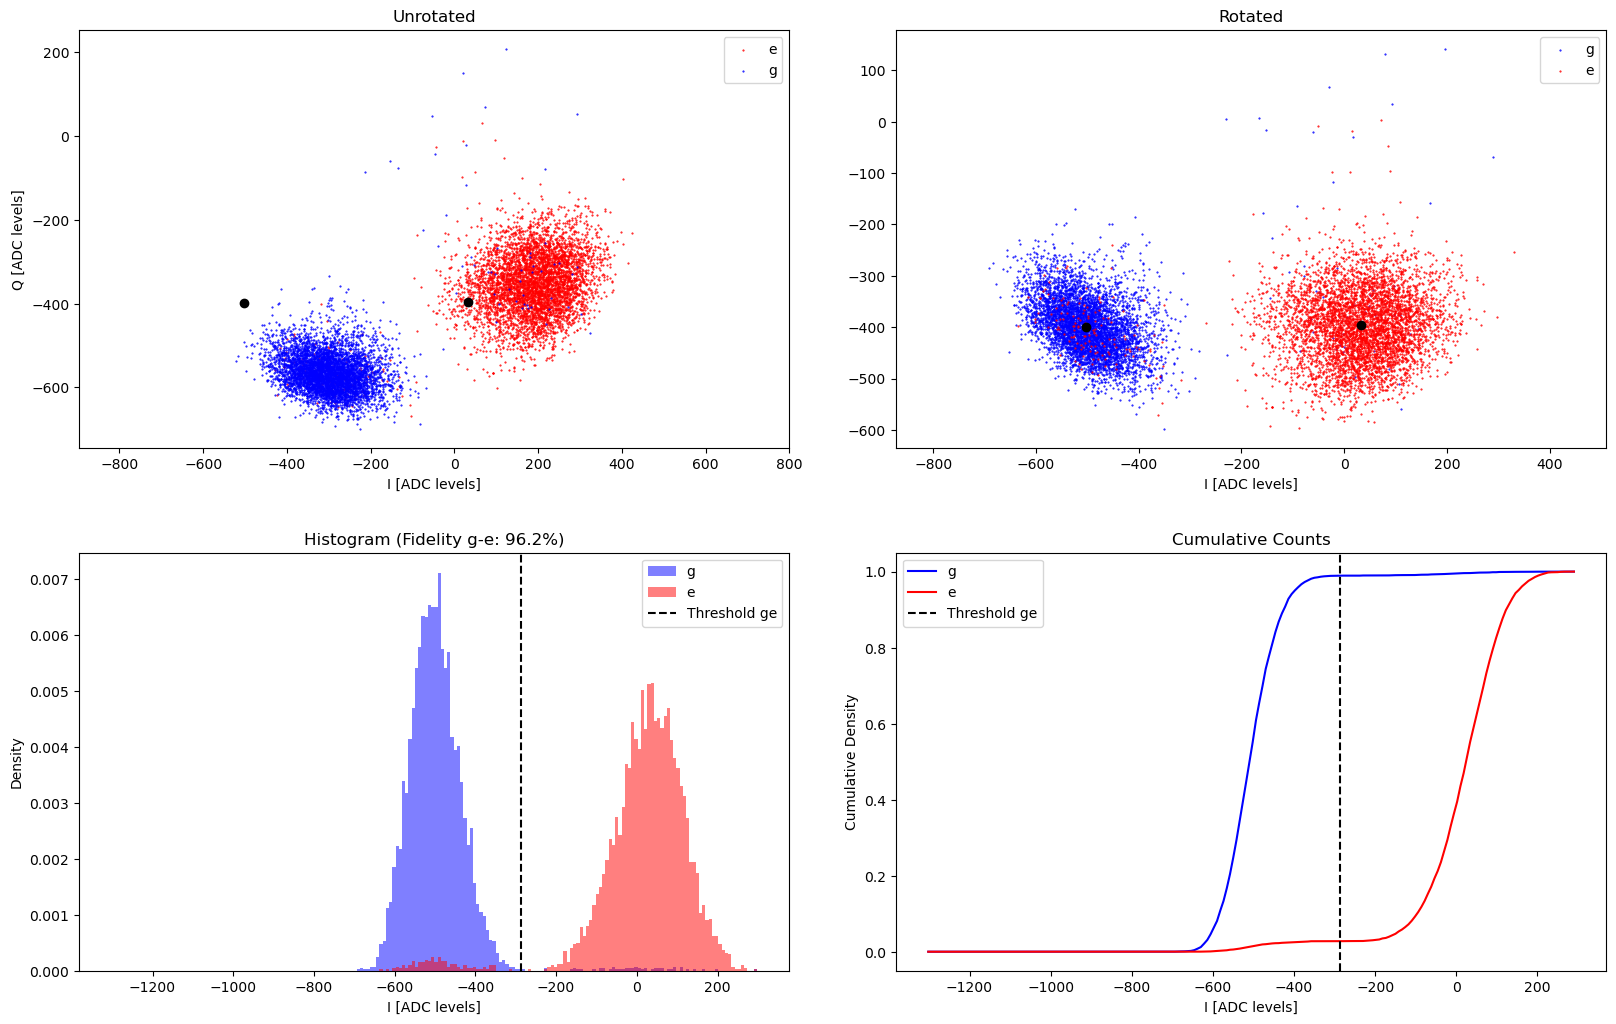

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-07-05_20-28-24_histogram.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-07-05.md
[0.9615944388877777]
Updated readout!
Single shot done!


In [16]:
update_single_shot(hstgrm[1], expts_base_inst.config_thisrun)
print('Single shot done!')

In [17]:
expts_base_inst.config_thisrun.device.readout

{'trig_offset': 450,
 'frequency': [748.8941512875441],
 'gain': [800],
 'phase': [379.01120744001724],
 'threshold': [-285.7890372082056],
 'threshold_list': [[-285.7890372082056]],
 'man1_drive_list': [0.0],
 'man2_drive_list': [0.0],
 'readout_length': [1.5],
 'relax_delay': [2500],
 'confusion_matrix_with_reset': [0.9964530022802125,
  0.0035469977197875036,
  0.013768302080657598,
  0.9862316979193424],
 'confusion_matrix_without_reset': [0.9894000000000002,
  0.010599999999999832,
  0.027805561112222446,
  0.9721944388877776],
 'Ie': 32.219154141112966,
 'Ig': -501.78903720820574}

## Photon Number Resolved  Spectroscopy

This is used to check that the fock states are well prepared before we do the tomography

In [35]:
def do_pulse_probe(
    config_thisrun, 
    start=3560,  # [MHz]
    step=0.1,  # min step ~1 MHz
    expts=200,  # Number of experiments stepping from start
    reps=2000,  # Number of averages per point
    rounds=1,  # Number of start to finish sweeps to average over
    length=1,  # Qubit probe constant pulse length [us]
    gain=400,  # Qubit pulse gain
    sigma=0.1,  # Qubit flat top sigma
    qubit=0,
    prepulse=False,
    pre_sweep_pulse=[],
    gate_based=False,
    relax_delay=250,  # Wait time between experiments [us]
    ): 
    qspec = expts_base_inst.meas.single_qubit.pulse_probe_spectroscopy.PulseProbeSpectroscopyExperiment(
        soccfg=expts_base_inst.soc, path=expts_base_inst.expt_path, prefix='PulseProbeSpectroscopyExperiment', 
        config_file=expts_base_inst.config_file
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    qspec.cfg.expt = dict(
        qubits = [0],
        start=start,
        step=step,
        expts=expts,
        reps=reps,
        rounds=rounds,
        length=length,
        gain=gain,
        sigma=sigma,
        qubit=qubit,
        prepulse = prepulse, 
        pre_sweep_pulse = pre_sweep_pulse,
        gate_based = gate_based,
    )

    qspec.cfg.device.readout.relax_delay = [relax_delay] # Wait time between experiments [us]
    qspec.go(analyze=True, display=True, progress=True, save=True)
    return qspec

In [36]:
pre_sweep_pulse = mm_base_calib.prep_man_photon(man_no=1, photon_no=4)
pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, multiphoton_cfg_thisrun).pulse.tolist()
print(f"pre_sweep_pulse: {pre_sweep_pulse}")

multiphoton_cfg 3567.3608840739785
pre_sweep_pulse: [[3567.3608840739785, 3423.9884929737523, 2005.8600000000006, 3567.0799647644612, 3423.7266366015674, 2005.3250648263681, 3566.7644237298246, 3423.464917683452, 2004.900423280029, 3566.4633477474954, 3423.2192518006295, 2004.3350000000019], [19013, 9137, 15000, 10480, 9159, 15000, 10373, 9266, 15000, 10349, 8326, 15000], [0, 0, 1.0955314021401903, 0, 0, 0.7774181220945486, 0, 0, 0.6274662037166608, 0, 0, 0.5491206701698654], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0], ['gauss', 'gauss', 'flat_top', 'gauss', 'gauss', 'flat_top', 'gauss', 'gauss', 'flat_top', 'gauss', 'gauss', 'flat_top'], [0.02, 0.035, 0.005, 0.035, 0.035, 0.005, 0.035, 0.035, 0.005, 0.035, 0.035, 0.005]]


multiphoton_cfg 3567.3608840739785
pulssing on channel:  2
qubit register page: 1, frequency register: 22


  0%|          | 0/10000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00143_PulseProbeSpectroscopyExperiment.h5
Found peak in amps at [MHz] 3566.170103774164, HWHM 0.06352233471457858
Found peak in I at [MHz] 3566.1698435062976, HWHM -0.05768490354818988
Found peak in Q at [MHz] 3566.168489722625, HWHM -0.056127517143586964


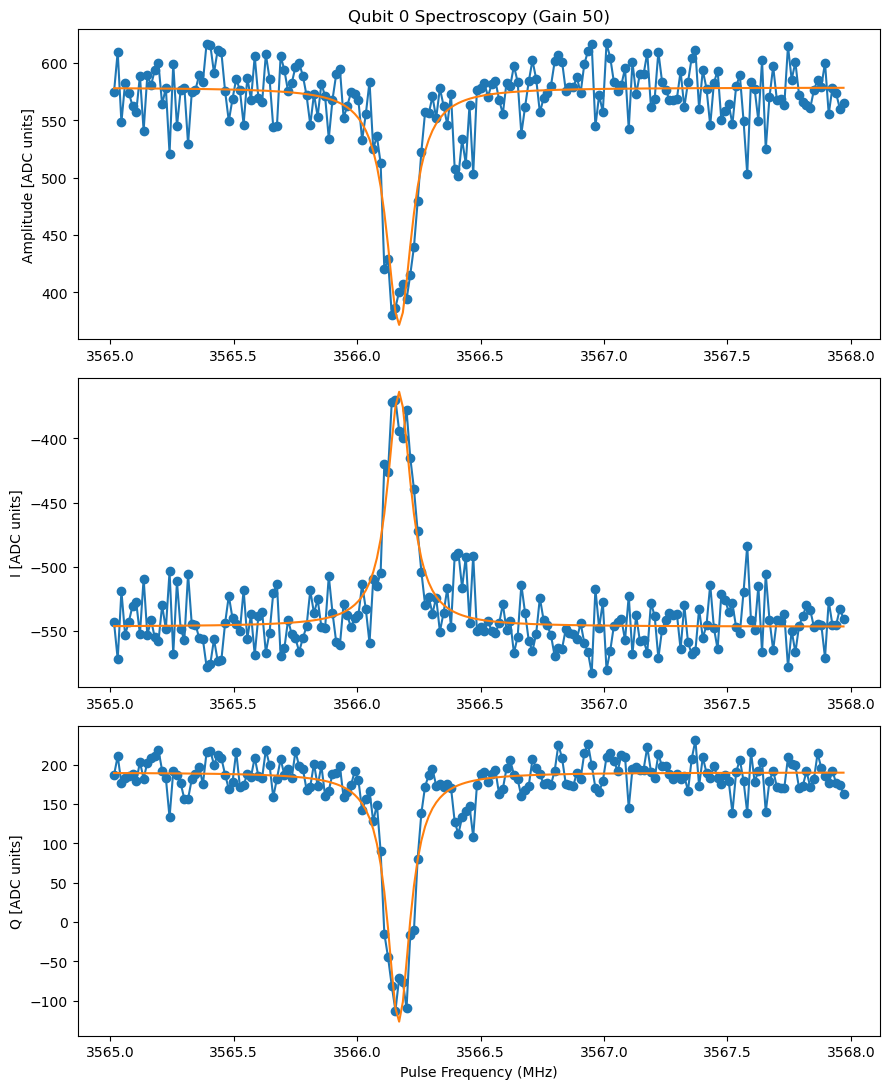

In [37]:
qspec= do_pulse_probe(
    config_thisrun=expts_base_inst.config_thisrun,
    start=3565,  # [MHz]
    step=0.015,  # min step ~1 MHz
    expts=200,  # Number of experiments stepping from start
    reps=50,  # Number of averages per point
    rounds=1,  # Number of start to finish sweeps to average over
    length=6.3,  # Qubit probe constant pulse length [us]
    gain=50,  # Qubit pulse gain
    sigma=0.1,  # Qubit flat top sigma
    qubit=0,
    prepulse=True,
    pre_sweep_pulse=pre_sweep_pulse,
    gate_based=False,
    relax_delay=8000  # Wait time between experiments [us]
)

# Setting up the Wigner tomography

## Parity Delay

In [18]:
def do_parity_delay(
    config_thisrun,
    expt_path,
    config_path,
    start=0.01,
    step=0.05,
    expts=50,
    reps=500,
    rounds=1,
    qubits=[0],
    prepulse=True,
    normalize=False,
    active_reset=False,
    man_reset=True,
    gate_based=False,
    storage_reset=True,
    pre_sweep_pulse=[],
    man_mode_no=1,
    relax_delay=2500
):

    pre_sweep_pulse = mm_base_calib.prep_man_photon(man_no=1, photon_no=1)
    pre_sweep_pulse = mm_base_calib.get_prepulse_creator(pre_sweep_pulse, multiphoton_cfg_thisrun).pulse.tolist()
    expt_cfg = {
        'start': start,
        'step': step,
        'expts': expts,
        'reps': reps,
        'rounds': rounds,
        'qubits': qubits,
        'prepulse': prepulse,
        'normalize': normalize,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'gate_based': gate_based,
        'storage_reset': storage_reset,
        'pre_sweep_pulse': pre_sweep_pulse,
    }
    # print("expt_path:", expt_path)
    # print("config_path:", config_path)
    
    
    parity_delay_exp = expts_base_inst.meas.single_qubit.parity_delay.ParityDelayExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='ParityDelayExperiment', config_file=config_path
    )
    parity_delay_exp.cfg = AttrDict(deepcopy(config_thisrun))
    parity_delay_exp.cfg.expt = expt_cfg
    parity_delay_exp.cfg.device.readout.relax_delay = [relax_delay] 
    parity_delay_exp.go(analyze=False, display=False, progress=True, save=True)
    return parity_delay_exp


In [19]:
parity_delay_exp = do_parity_delay(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file)

  0%|          | 0/50 [00:00<?, ?it/s]

Creating parity pulse: 1.584663918482869
Creating parity pulse: 1.584663918482869
Creating parity pulse: 1.584663918482869
Creating parity pulse: 1.584663918482869
Creating parity pulse: 1.584663918482869
Creating parity pulse: 1.584663918482869
Creating parity pulse: 1.584663918482869
Creating parity pulse: 1.584663918482869
Creating parity pulse: 1.584663918482869
Creating parity pulse: 1.584663918482869
Creating parity pulse: 1.584663918482869
Creating parity pulse: 1.584663918482869
Creating parity pulse: 1.584663918482869
Creating parity pulse: 1.584663918482869
Creating parity pulse: 1.584663918482869
Creating parity pulse: 1.584663918482869
Creating parity pulse: 1.584663918482869
Creating parity pulse: 1.584663918482869
Creating parity pulse: 1.584663918482869
Creating parity pulse: 1.584663918482869
Creating parity pulse: 1.584663918482869
Creating parity pulse: 1.584663918482869
Creating parity pulse: 1.584663918482869
Creating parity pulse: 1.584663918482869
Creating parity 

Attempted to init fitparam 2 to -500, which is out of bounds -360 to 360. Instead init to 0.0
Attempted to init fitparam 4 to -220.50269016697587, which is out of bounds -398.1127575757576 to -372.9641212121212. Instead init to -385.53843939393937
p1: 0.3200682291894566
p2: -84.5251275979808
Pi length: 1.5146521175600387
Pi/2 length: 0.733568657220654
p1: 0.1022859676944909
p2: -5.041999988996773
Pi length: 2.581053505926897
Pi/2 length: 0.13692548294427898


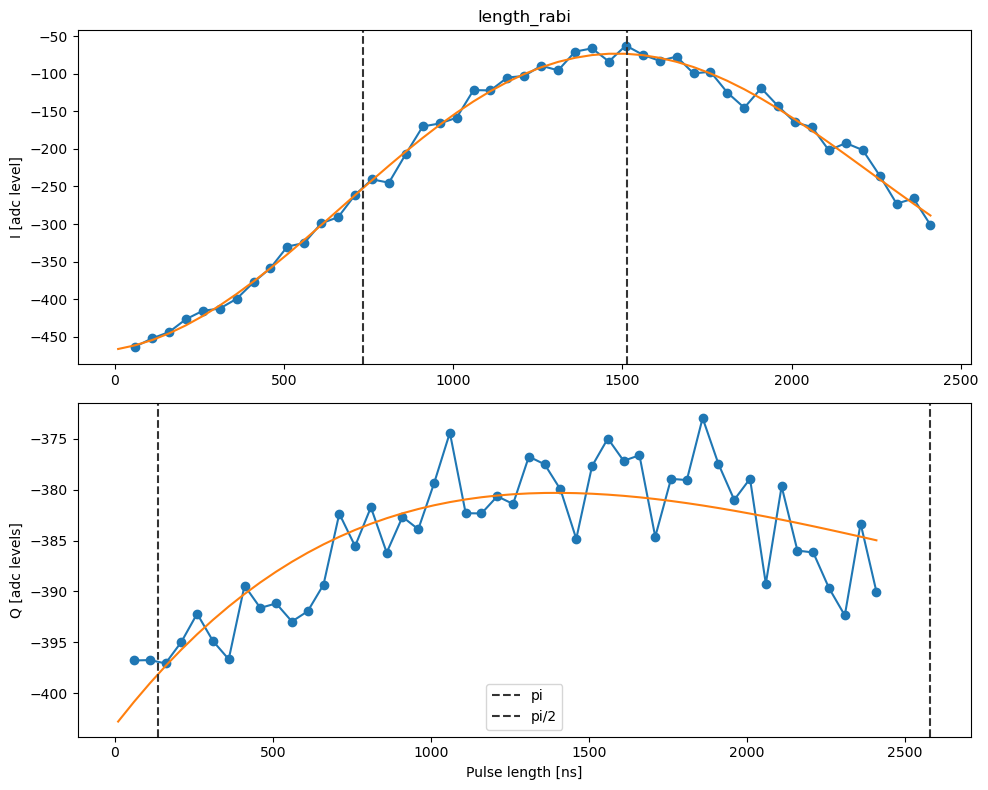

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-07-05_20-30-52_Length_Rabi_General_F0g1.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-07-05.md


In [22]:
from multimode_expts.fit_display_classes import LengthRabiFitting
# Analyze the data
length_rabi_analysis = LengthRabiFitting(parity_delay_exp.data, config = parity_delay_exp.cfg)
length_rabi_analysis.analyze(fitparams = [500, 0.05, -500, None, None, None])
length_rabi_analysis.display(title_str='Length Rabi General F0g1')

In [ ]:
## Assign to config 
expts_base_inst.config_thisrun.device.manipulate.revival_time[0] = length_rabi_analysis.results['pi_length']
# expts_base_inst.config_thisrun.device.manipulate.revival_time[0] = 1.584663918482869

## Manipulate Parity Spectroscopy

In [ ]:
def do_parity_freq_experiment(
    start=4960,
    stop=5020,
    step=0.10,
    reps=500,
    rounds=1,
    qubit=[0],
    normalize=False,
    single_shot=False,
    singleshot_reps=10000,
    span=20,
    manipulate_no=1,
    displace=(True, 0.1, 1000),
    const_pulse=(False, 1),
    f0g1_cavity=0,
    prepulse=False,
    pre_sweep_pulse=None,
    relax_delay=2500
):
    """
    Run the Parity Frequency Experiment with configurable parameters.
    """
    
    expt_cfg = {
        'start': start,
        'stop': stop,
        'step': step,
        'reps': reps,
        'rounds': rounds,
        'qubits': qubit,
        'normalize': normalize,
        'single_shot': single_shot,
        'singleshot_reps': singleshot_reps,
        'span': span,
        'manipulate': manipulate_no,
        'displace': list(displace),
        'const_pulse': list(const_pulse),
        'f0g1_cavity': f0g1_cavity,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse
    }
    # Example usage of relax_delay in experiment config:
    parity_freq_exp = expts_base_inst.meas.single_qubit.parity_freq.ParityFreqExperiment(
        soccfg=expts_base_inst.soc, path=expts_base_inst.expt_path, 
        prefix='ParityFreqExperiment', config_file=expts_base_inst.config_file
    )
    parity_freq_exp.cfg = AttrDict(deepcopy(expts_base_inst.config_thisrun))
    parity_freq_exp.cfg.expt = expt_cfg
    parity_freq_exp.cfg.device.readout.relax_delay = [relax_delay]
    parity_freq_exp.go(analyze=False, display=False, progress=True, save=True)
    return parity_freq_exp


In [43]:
parity_freq_exp = do_parity_freq_experiment()

  0%|          | 0/600 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00015_ParityFreqExperiment.h5


Found peak in amps at [MHz] 5000.46534853279, HWHM 2174.416501718962
Found peak in I at [MHz] 4985.149632824914, HWHM 0.0366010535337701
Found peak in Q at [MHz] 5045.398207166297, HWHM 2.0960802526921927


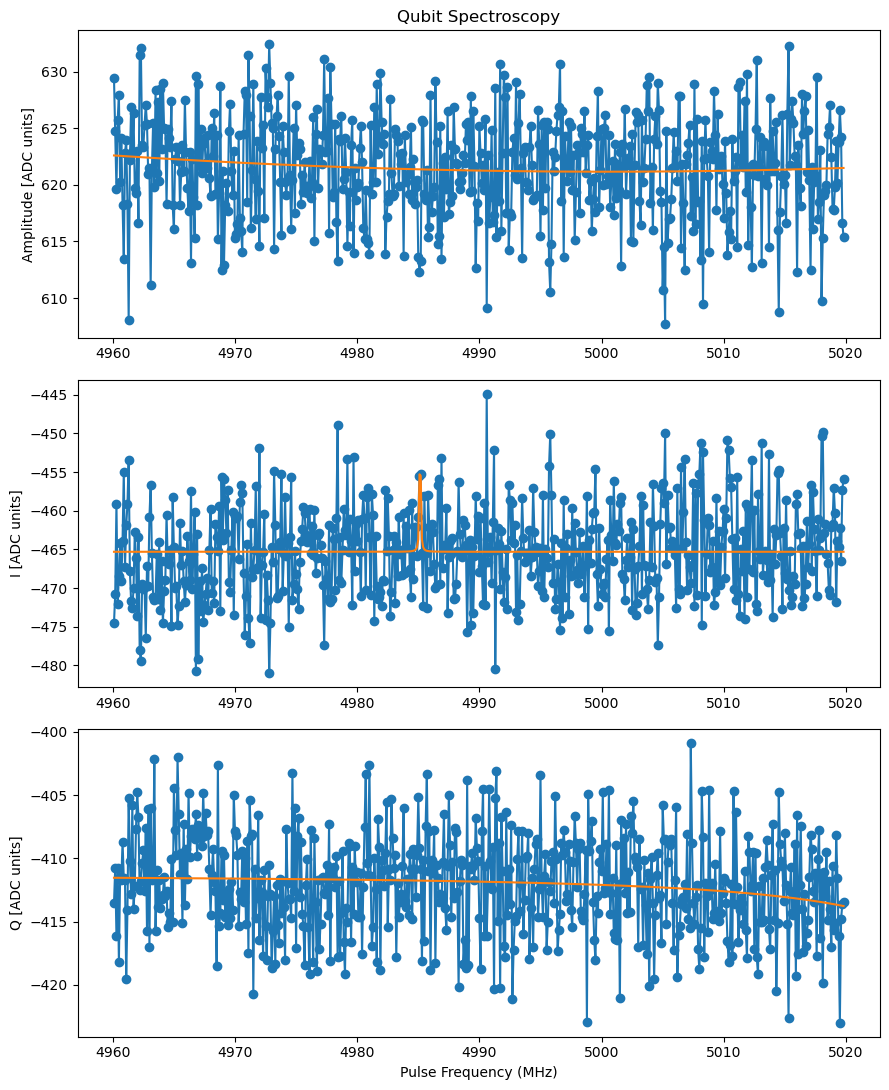

In [44]:
from fit_display_classes import Spectroscopy
spec = Spectroscopy(parity_freq_exp.data, config=parity_freq_exp.cfg)
spec.analyze()
spec.display()

In [47]:
spec.data['fit_avgi'][2]

4984.31438512588

In [48]:
expts_base_inst.config_thisrun.device.manipulate.f_ge[0] = spec.data['fit_avgi'][2]

## Manipulate SPectroscopy (Abandoned)

In [ ]:
def do_cavity_spectroscopy(
    config_thisrun,
    expt_path,
    config_path,
    start=4975,
    step=0.01,
    expts=2000,
    reps=100,
    pulse_e=False,
    pulse_f=False,
    cavity_name='manipulate',
    drive_gain=500,
    qubit=0,
    RF_modulation=[False, 1055, 5000, 'high'],
    relax_delay=200
):
    """Run the Cavity Spectroscopy experiment with configurable parameters."""
    expt_cfg = {
        'start': start,
        'step': step,
        'expts': expts,
        'reps': reps,
        'pulse_e': pulse_e,
        'pulse_f': pulse_f,
        'cavity_name': cavity_name,
        'drive_gain': drive_gain,
        'qubit': qubit,
        'RF_modulation': RF_modulation
    }
    cavity_spec_exp = expts_base_inst.meas.single_qubit.cavity_spectroscopy.CavitySpectroscopyExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='CavitySpectroscopyExperiment', config_file=config_path
    )
    cavity_spec_exp.cfg = AttrDict(deepcopy(config_thisrun))
    cavity_spec_exp.cfg.expt = expt_cfg
    cavity_spec_exp.cfg.device.readout.relax_delay = [relax_delay]
    cavity_spec_exp.go(analyze=False, display=False, progress=True, save=True)
    return cavity_spec_exp


def update_res_spec(rspec, config_thisrun):
    config_thisrun.device.manipulate.f_ge[0] = [rspec.data['fit'][0]]
    print('Updated man_freq frequency!')

In [ ]:
cav_spec = do_cavity_spectroscopy(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    start=4980,
    step=0.01,
    expts=2000,
    reps=100,
    drive_gain=500,
    pulse_e=False,
    pulse_f=False)

  0%|          | 0/2000 [00:00<?, ?it/s]

generator 3 doesn't have a digital mixer, but mixer_freq was defined
ro_ch was defined for generator 3, but it's not multiplexed and doesn't have a mixer, so it will do nothing
generator 2 doesn't have a digital mixer, but mixer_freq was defined
generator 1 doesn't have a digital mixer, but mixer_freq was defined
ro_ch was defined for generator 1, but it's not multiplexed and doesn't have a mixer, so it will do nothing
generator 3 doesn't have a digital mixer, but mixer_freq was defined
ro_ch was defined for generator 3, but it's not multiplexed and doesn't have a mixer, so it will do nothing
generator 2 doesn't have a digital mixer, but mixer_freq was defined
generator 1 doesn't have a digital mixer, but mixer_freq was defined
ro_ch was defined for generator 1, but it's not multiplexed and doesn't have a mixer, so it will do nothing
generator 3 doesn't have a digital mixer, but mixer_freq was defined
ro_ch was defined for generator 3, but it's not multiplexed and doesn't have a mixer,

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00004_CavitySpectroscopyExperiment.h5


Found peak in amps at [MHz] 4997.298904820421, HWHM 3.148540247056339
Found peak in I at [MHz] 4997.009158894696, HWHM 0.013512330957129719
Found peak in Q at [MHz] 4995.719807747144, HWHM -0.226182560741961


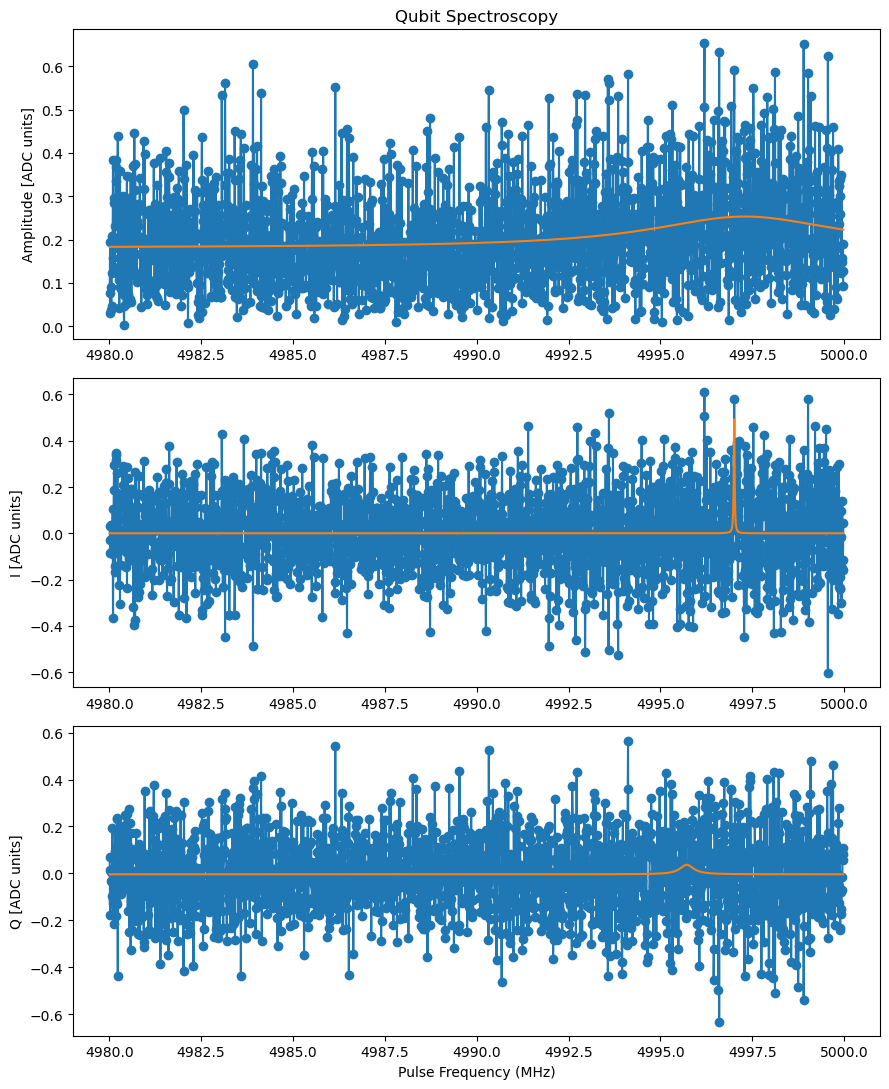

In [ ]:
from fit_display_classes import Spectroscopy
spec = Spectroscopy(cav_spec.data, config=cav_spec.cfg)
spec.analyze()
spec.display()

## Manipulate Ramsey (to finetune frequency)
- This will use displace pulse instead do qubit pi/2 to calibrate; we want fine calibration of manipulate frequency not some fast way of extracting T2 time or finding stark shift on f0g1 transition
- Make sure displacements are small $(\alpha \approx 0.2)$
- Somehow i don't get full contrast, like the lowst i,q value dont correspond to g 




In [53]:
def do_cavity_ramsey(
    config_thisrun,
    expt_path,
    config_path,
    start=0.01,           # start delay
    step=0.05,            # step size
    expts=100,            # number of experiments
    ramsey_freq=3.7,      # Ramsey frequency
    reps=50,              # repetitions
    rounds=1,             # rounds
    qubits=[0],           # qubits
    checkEF=False,        # check EF
    f0g1_cavity=0,        # f0g1 cavity
    init_gf=False,        # initialize gf
    active_reset=False,   # active reset
    man_reset=True,       # manipulate reset
    storage_reset=True,   # storage reset
    user_defined_pulse=None, # [on/off, freq, gain, sigma (mus), 0, 4] # if off, use config freq
    parity_meas=True,     # parity measurement
    man_mode_no=1,            
    storage_ramsey=[False, 2, True], # storage Ramsey
    man_ramsey=None,      # manipulate Ramsey
    coupler_ramsey=False, # coupler Ramsey
    custom_coupler_pulse=None, # custom coupler pulse
    echoes=[False, 0],    # echoes
    prepulse=False,       # prepulse
    postpulse=False,      # postpulse
    gate_based=False,     # gate based
    pre_sweep_pulse=None, # pre sweep pulse
    post_sweep_pulse=None,# post sweep pulse
    relax_delay=2500      # relax delay
):
    """
    Run the Cavity Ramsey experiment using the specified configuration.
    """
    if user_defined_pulse is None:
        user_defined_pulse = [True, config_thisrun.device.manipulate.f_ge[man_mode_no-1], 1000, 
                                config_thisrun.device.manipulate.displace_sigma[man_mode_no-1], 0,
                                  4]
    #[on/off, freq, gain, sigma (mus), phase, channel] 
    if man_ramsey is None:
        man_ramsey = [False, man_mode_no -1]
    if custom_coupler_pulse is None:
        custom_coupler_pulse = [[944.25], [1000], [0.316677658], [0], [1], ['flat_top'], [0.005]]
    if pre_sweep_pulse is None:
        pre_sweep_pulse = []
    if post_sweep_pulse is None:
        post_sweep_pulse = []

    cavity_ramsey = expts_base_inst.meas.single_qubit.t2_cavity.CavityRamseyExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='CavityRamseyExperiment', config_file=config_path
    )

    cavity_ramsey.cfg = AttrDict(deepcopy(config_thisrun))

    cavity_ramsey.cfg.expt = dict(
        start=start,                    # start delay
        step=step,                      # step size
        expts=expts,                    # number of experiments
        ramsey_freq=ramsey_freq,        # Ramsey frequency
        reps=reps,                      # repetitions
        rounds=rounds,                  # rounds
        qubits=qubits,                  # qubits
        checkEF=checkEF,                # check EF
        f0g1_cavity=f0g1_cavity,        # f0g1 cavity
        init_gf=init_gf,                # initialize gf
        active_reset=active_reset,      # active reset
        man_reset=man_reset,            # manipulate reset
        storage_reset=storage_reset,    # storage reset
        user_defined_pulse=user_defined_pulse, # [on/off, freq, gain, sigma (mus), 0, 4] # if off, use config freq
        parity_meas=parity_meas,        # parity measurement
        man_mode_no=man_mode_no,                # manipulate index
        storage_ramsey=storage_ramsey,  # storage Ramsey
        man_ramsey=man_ramsey,          # manipulate Ramsey
        coupler_ramsey=coupler_ramsey,  # coupler Ramsey
        custom_coupler_pulse=custom_coupler_pulse, # custom coupler pulse
        echoes=echoes,                  # echoes
        prepulse=prepulse,              # prepulse
        postpulse=postpulse,            # postpulse
        gate_based=gate_based,          # gate based
        pre_sweep_pulse=pre_sweep_pulse,# pre sweep pulse
        post_sweep_pulse=post_sweep_pulse # post sweep pulse
    )

    cavity_ramsey.cfg.device.readout.relax_delay = [relax_delay]
    cavity_ramsey.go(analyze=False, display=False, progress=True, save=True)
    return cavity_ramsey


In [54]:
cavity_ramsey = do_cavity_ramsey(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    man_mode_no=1, 
    ramsey_freq=0.2,
    step = 0.2, 
    expts = 100, 
    reps = 500,
    user_defined_pulse=[True, expts_base_inst.config_thisrun.device.manipulate.f_ge[0], 1000, 
                                expts_base_inst.config_thisrun.device.manipulate.displace_sigma[0],
                                  0,
                                  4])
    #user defined pulse [on/off, freq, gain, sigma (mus), phase, channel] )

phase update channel: [3]
This is designed for displacing manipulate mode, not for swapping pi/2 into man
if user length is 0, then it is a gaussian pulse with sigma 20 cycles
user length: 0
phase step deg: 14.4
phase step logic: +
inide t2 cavity acquire
100


  0%|          | 0/50000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00038_CavityRamseyExperiment.h5


No echoes in the data
Current pi pulse frequency: 4984.31438512588
Fit frequency from I [MHz]: 0.09077631081608764 +/- 0.01245910250098503
Suggested new pi pulse frequency from fit I [MHz]:
 	4984.423608815064
 	4984.605161436696
T2 Ramsey from fit I [us]: 12.805099229421383
Fit frequency from Q [MHz]: 0.07671385994529312 +/- 0.007132604295195359
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4984.437671265935
 	4984.591098985826
T2 Ramsey from fit Q [us]: 18.720626509427518


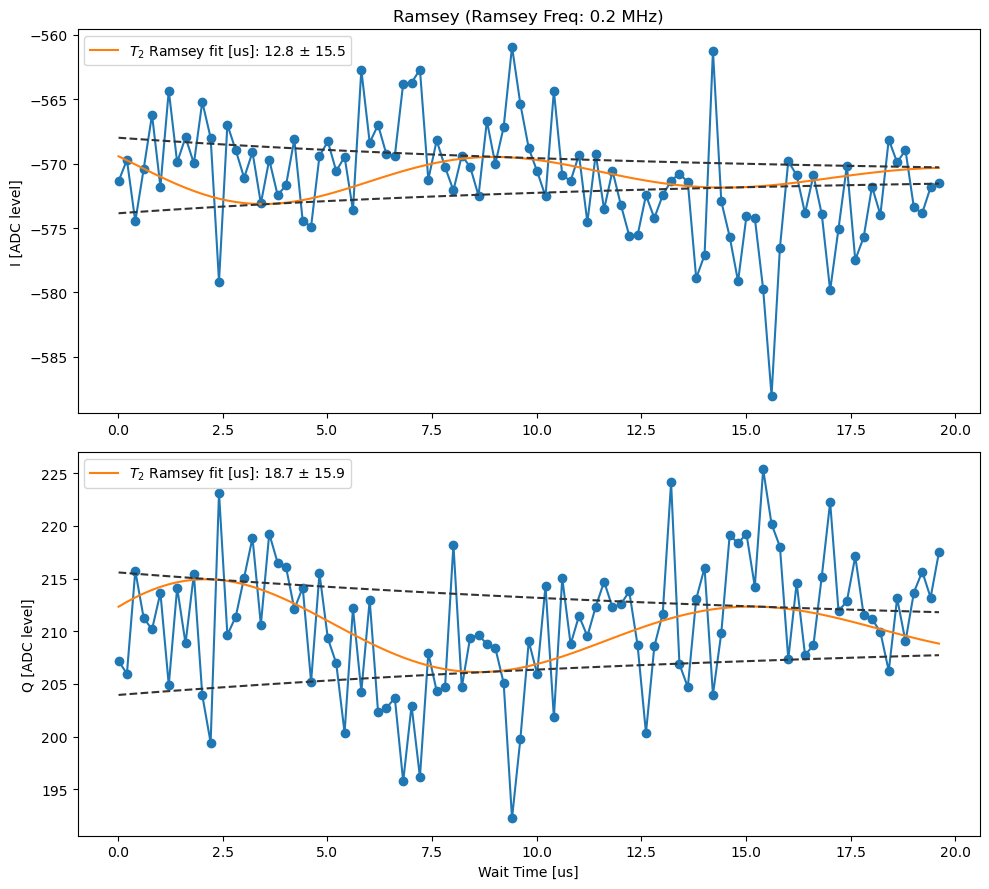

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-07-02_17-11-32_Cavity_Ramsey_Analysis.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-07-02.md


In [55]:
from fit_display_classes import RamseyFitting
cavity_ramsey_analysis = RamseyFitting(
        cavity_ramsey.data, config=cavity_ramsey.cfg,
    )
cavity_ramsey_analysis.analyze()
cavity_ramsey_analysis.display(f_test = cavity_ramsey.cfg.expt.user_defined_pulse[1],title_str='Cavity Ramsey Analysis')

In [52]:
#issues with t2_ramsey code:
4984.526124231778-4984.517099141256

0.009025090522300161

In [150]:
0.19097490947797335-0.2

-0.009025090522026658

1- plot shows ramsey freq (0.2 MHz) even if you change the ramsey freq you use \
1b - but more importantly, the calculation of best fit also assumes a ram_freq of 0.2 regardless of actual ram_freq set \
2- code assumes best fit is plus (ignoring minus) of: min(cavity_ramsey_analysis.data['f_adjust_ramsey_avgi']) \
cant seem to find errors in the single_qubit.t2_cavity code though..

In [ ]:
# config_thisrun.device.qubit.f_ge = [config_thisrun.device.qubit.f_ge[0] + min(t2ramsey.data['f_adjust_ramsey_avgi'])]
# print('Updated qubit ge frequency to:', config_thisrun.device.qubit.f_ge[0])
min(cavity_ramsey_analysis.data['f_adjust_ramsey_avgi'])

0.009025090522026658

In [ ]:
0.19097490947797335

In [ ]:
expts_base_inst.config_thisrun.device.manipulate.f_ge[0] = 4984.517099141256 #

## Gain to Alpha Calibration

Will do tomography on the vaccum state 

$W_{\alpha} (|0\rangle\langle0|) = \frac{2}{\pi} e^{-2|\alpha|^2}$

In [276]:
def do_parity_gain_experiment(
    config_thisrun,
    expt_path,
    config_path,
    start=0,
    step=115*10,
    expts=20,
    reps=2000,
    rounds=1,
    qubit=0,
    qubits=[0],
    normalize=False,
    single_shot=False,
    singleshot_reps=1000,
    singleshot_active_reset=False,
    singleshot_man_reset=True,
    singleshot_storage_reset=True,
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    span=1000,
    prep_e=False,
    manipulate=1,
    displace=(True, 0.05),
    const_pulse=(False, 1),
    f0g1_cavity=0,
    prepulse=False,
    pre_sweep_pulse=None,
    relax_delay=2500
):
    """
    Run the Parity Gain Experiment with configurable parameters.
    """
    expt_cfg = {
        'start': start,
        'step': step,
        'expts': expts,
        'reps': reps,
        'rounds': rounds,
        'qubit': qubit,
        'qubits': qubits,
        'normalize': normalize,
        'single_shot': single_shot,
        'singleshot_reps': singleshot_reps,
        'singleshot_active_reset': singleshot_active_reset,
        'singleshot_man_reset': singleshot_man_reset,
        'singleshot_storage_reset': singleshot_storage_reset,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'span': span,
        'prep_e': prep_e,
        'manipulate': manipulate,
        'displace': list(displace),
        'const_pulse': list(const_pulse),
        'f0g1_cavity': f0g1_cavity,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse if pre_sweep_pulse is not None else []
    }
    parity_gain_exp = expts_base_inst.meas.single_qubit.parity_gain.ParityGainExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='ParityGainExperiment', config_file=config_path
    )
    parity_gain_exp.cfg = AttrDict(deepcopy(config_thisrun))
    parity_gain_exp.cfg.expt = expt_cfg
    parity_gain_exp.cfg.device.readout.relax_delay = [relax_delay]
    
    parity_gain_exp.go(analyze=False, display=False, progress=True, save=True)
    return parity_gain_exp


In [277]:
parity_gain_expt = do_parity_gain_experiment(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file
)

[3]
1
Parity Gain Program initialized
parity pulse: [[3567.3608840739785, 3567.3506008394015, 3567.3608840739785], [10182, 0, 10182], [0, 1.584663918482869, 0], [0, 0, 180], [2, 2, 2], ['gauss', 'const', 'gauss'], [0.015, 0.0, 0.015]]


  0%|          | 0/40000 [00:00<?, ?it/s]

avig i: [-475.40474351 -468.9046829  -451.44948268 -425.59498701 -395.57401082
 -366.90718831 -328.37501515 -310.68135281 -295.09372078 -273.50868506
 -270.23261688 -262.68312446 -260.06938528 -249.44324026 -261.62500325
 -246.29006818 -242.31282792 -233.32760281 -233.19332035 -236.69051299]
avg q: [-398.55983009 -398.60390584 -398.31754437 -398.28194589 -393.36038528
 -396.01927165 -393.60461905 -390.48550433 -388.4029632  -388.106329
 -389.30453355 -389.24756926 -389.06027706 -389.24336905 -386.47509524
 -385.71005844 -383.5709329  -381.89780087 -384.44814286 -381.59294481]
Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00051_ParityGainExperiment.h5


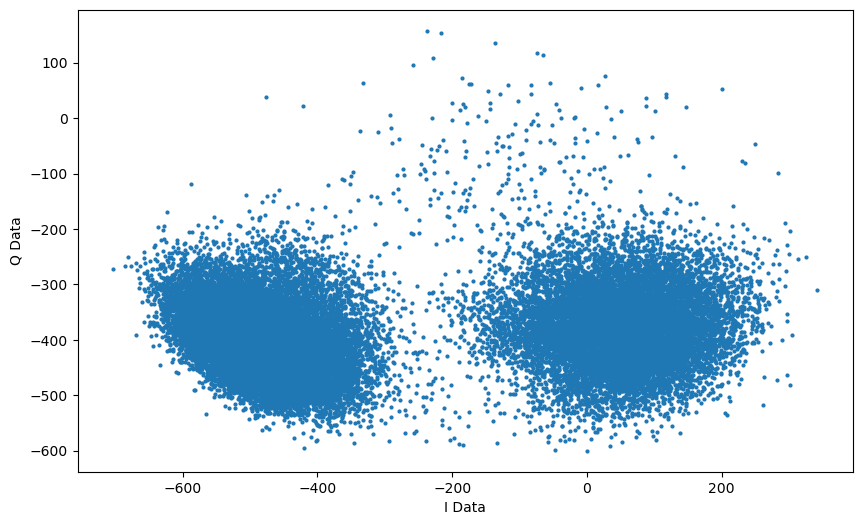

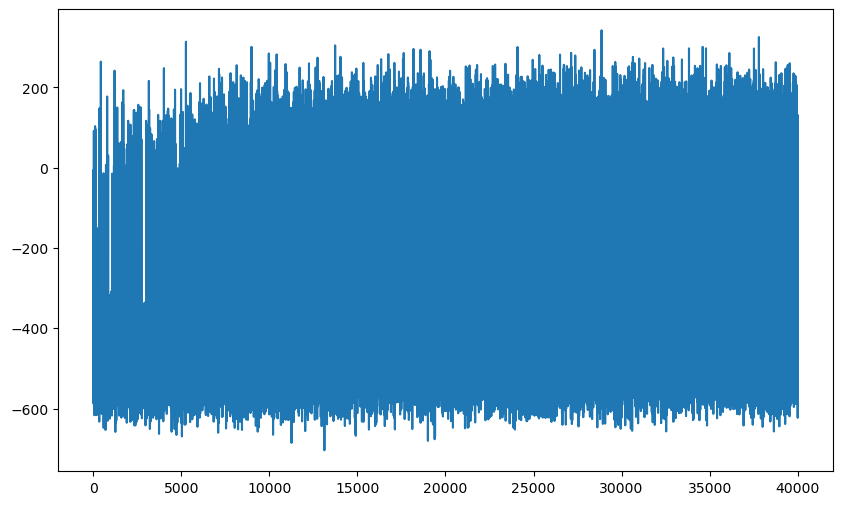

In [278]:
i_data = parity_gain_expt.data['idata']
q_data = parity_gain_expt.data['qdata']

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(i_data, q_data, 'o', markersize=2)
ax.set_xlabel('I Data')
ax.set_ylabel('Q Data')
fig2, ax2 = plt.subplots(1, 1, figsize=(10, 6))
ax2.plot(i_data)


No angle calibration found in data, assuming no rotation
No thresholds found in data, using default threshold
No confusion matrix found in data, using default confusion matrix
Rotating data by -0.0 radians
Gain to Alpha Conversion Factor: 8.781376652264373e-05


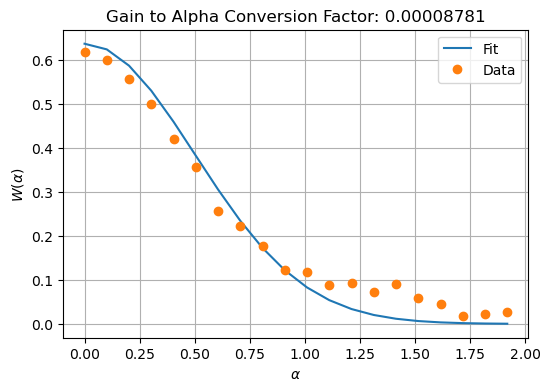

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-07-03_12-14-33_Gain_to_Alpha_Conversion_Factor_0.00008781.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-07-03.md
alpha = 1 requires gain of : 11387.73611017


In [279]:
from fitting_folder.wigner import WignerAnalysis
wigner_analysis = WignerAnalysis(parity_gain_expt.data, config=parity_gain_expt.cfg)
gain_to_alpha, result, ydata = wigner_analysis.get_gain_to_alpha(initial_guess=[0.001])

In [280]:
#update device
print(f'Gain to alpha: {gain_to_alpha}')
expts_base_inst.config_thisrun.device.manipulate.gain_to_alpha[0] = gain_to_alpha

Gain to alpha: 8.781376652264373e-05


# Wigner Tomography

## Generate Optimal Displacements 

In [46]:
expts_base_inst.path

'H:\\Shared drives\\SLab\\Multimode\\experiment\\250505_craqm'

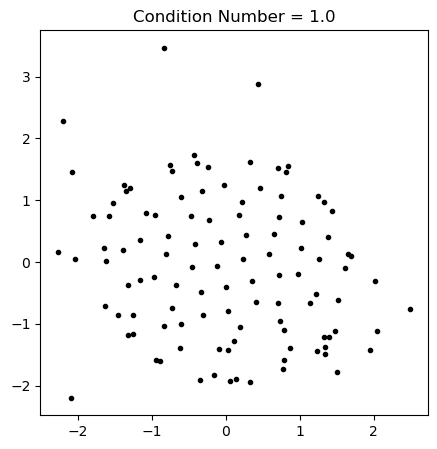

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Displacements saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\optimized_displacements_31.npy


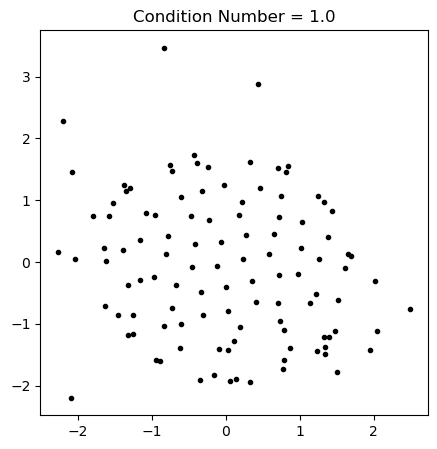

In [47]:
from fitting_folder.wigner import OptimalDisplacementGeneration
# Number of photons 
n_photon = 5
opt_alphas = OptimalDisplacementGeneration(FD = n_photon)
return_dict = opt_alphas.optimize(save_dir = expts_base_inst.expt_path )


In [48]:
# Get frunc from |2>
def do_wigner_tomography_1mode(
    config_thisrun,
    expt_path,
    config_path,
    displace_length=0.05,
    displacement_path=None,
    prepulse=False,
    pre_sweep_pulse=None,
    pre_gate_sweep_pulse=None,
    reps = 1000,
    qubits=[0],
    gate_based=True,
    pulse_correction=False,
    relax_delay=2500
):
    """
    Run the Wigner Tomography 1 Mode Experiment with configurable parameters.
    """
    expt_cfg = {
        'displace_length': displace_length,
        'displacement_path': displacement_path,
        'reps': reps,
        'rounds': 1,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse if pre_sweep_pulse is not None else [],
        'pre_gate_sweep_pulse': pre_gate_sweep_pulse if pre_gate_sweep_pulse is not None else [],
        'qubits': qubits,
        'pulse_correction': pulse_correction,
    }
    wigner_exp = expts_base_inst.meas.qubit_cavity.single_mode_wigner_tomography.WignerTomography1ModeExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='WignerTomography1ModeExperiment', config_file=config_path
    )
    wigner_exp.cfg = AttrDict(deepcopy(config_thisrun))
    wigner_exp.cfg.expt = expt_cfg
    wigner_exp.cfg.expt.gate_based = gate_based  # Set gate_based to False for Wigner tomography
    wigner_exp.cfg.device.readout.relax_delay = [relax_delay]
    # wigner_exp.cfg.device.readout.phase = 90.0  # Set readout phase to 0.0

    wigner_exp.go(analyze=True, display=False, progress=True, save=True)
    return wigner_exp

print(expts_base_inst)
# print(wigner_exp)

## Wigner Tomography

In [41]:
# prep_man_pi = mm_base_calib.prep_man_photon(man_no=1, photon_no=4, hpi= True)
# prep_man_pi = mm_base_calib.prep_man_photon(man_no=1, photon_no=0, hpi= True)
prep_man_pi = mm_base_calib.prep_fock_state(man_no=1, photon_no_list=[4],broadband=True)
# prep_man_pi.append(['storage', 'M1-S1', 'pi', 0]) 
# prep_man_pi.append(['storage', 'M1-S1', 'pi', 0]) 
## convert it to low level pulse 
pulse = mm_base_calib.get_prepulse_creator(prep_man_pi).pulse.tolist()
# post_pulse = [[pulse[i][-1]] for i in range(len(pulse))]  # post pulse is the same as prepulse
# post_pulse
prep_man_pi

[['multiphoton', 'g0-e0', 'pi', 0],
 ['multiphoton', 'e0-f0', 'pi', 0],
 ['multiphoton', 'f0-g1', 'pi', 0],
 ['multiphoton', 'g1-e1', 'pi', 0],
 ['multiphoton', 'e1-f1', 'pi', 0],
 ['multiphoton', 'f1-g2', 'pi', 0],
 ['multiphoton', 'g2-e2', 'pi', 0],
 ['multiphoton', 'e2-f2', 'pi', 0],
 ['multiphoton', 'f2-g3', 'pi', 0],
 ['multiphoton', 'g3-e3', 'pi', 0],
 ['multiphoton', 'e3-f3', 'pi', 0],
 ['multiphoton', 'f3-g4', 'pi', 0]]

In [424]:
# print(wigner.data["alpha"].shape)
# print(wigner.data["avgi"].shape)
# print(wigner.data["avgq"].shape)
# print(wigner.data["amps"].shape)
# print(wigner.data["phases"].shape)
# print(wigner.data["i0"].shape)
# print(wigner.data["q0"].shape)


In [425]:
# test = {}

# test["i0"] = wigner.data["q0"][::2, :, :]

In [426]:
wigner = do_wigner_tomography_1mode(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    displace_length=0.05,
    reps = 200,
    displacement_path=return_dict['path'],
    prepulse=True,
    pre_sweep_pulse=pulse,
    gate_based = False,
    pulse_correction=True,
    relax_delay=2500
)

Pulse correction is applied
alpha_list: [0.         0.22222222 0.44444444 0.66666667 0.88888889 1.11111111
 1.33333333 1.55555556 1.77777778 2.        ]
man mode no: 1
gain2alpha: 8.781376652264373e-05
displace_sigma: 0.05


  0%|          | 0/10 [00:00<?, ?it/s]

Creating parity pulse: 1.584663918482869
phase second pulse: 180
Creating parity pulse: 1.584663918482869
i0 shape: (1, 200)
data i0 shape: (1, 1, 200)
Creating parity pulse: 1.584663918482869
phase second pulse: 0
Creating parity pulse: 1.584663918482869
i0 shape: (1, 200)
data i0 shape: (2, 1, 200)
Creating parity pulse: 1.584663918482869
phase second pulse: 180
Creating parity pulse: 1.584663918482869
i0 shape: (1, 200)
data i0 shape: (3, 1, 200)
Creating parity pulse: 1.584663918482869
phase second pulse: 0
Creating parity pulse: 1.584663918482869
i0 shape: (1, 200)
data i0 shape: (4, 1, 200)
Creating parity pulse: 1.584663918482869
phase second pulse: 180
Creating parity pulse: 1.584663918482869
i0 shape: (1, 200)
data i0 shape: (5, 1, 200)
Creating parity pulse: 1.584663918482869
phase second pulse: 0
Creating parity pulse: 1.584663918482869
i0 shape: (1, 200)
data i0 shape: (6, 1, 200)
Creating parity pulse: 1.584663918482869
phase second pulse: 180
Creating parity pulse: 1.5846

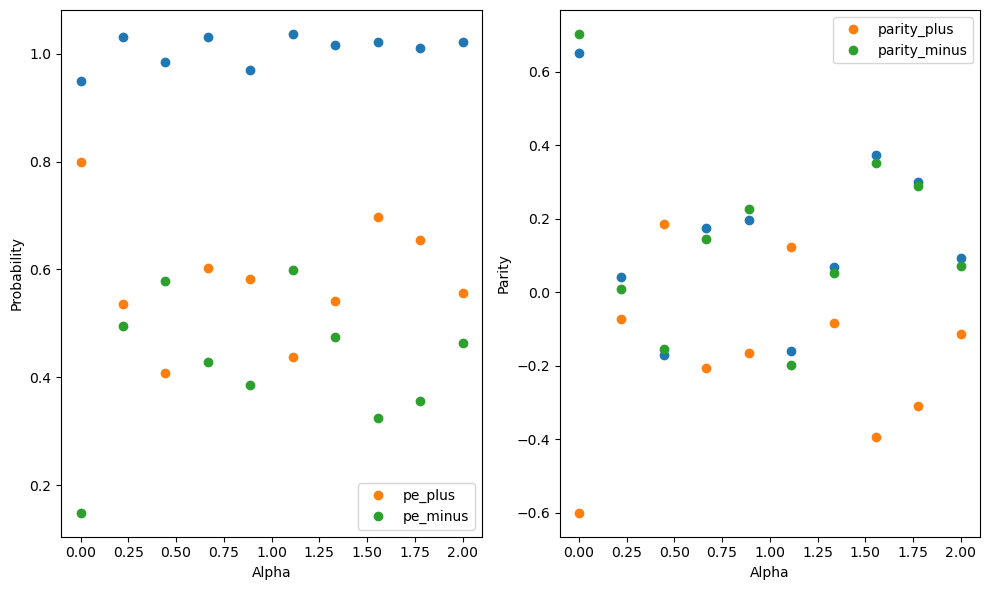

In [427]:
# from fitting_folder.wigner import WignerAnalysis
# from qutip import fock  
# from slab import AttrDict
# wigner_analysis = WignerAnalysis(wigner.data, config=wigner.cfg, mode_state_num=10, alphas = wigner.data['alpha'])
# initial_state = (fock(wigner_analysis.m, 0)+fock(wigner_analysis.m, 4)).unit() # Initial state |0> ?? 1,2, o4 [1,2]
# # initial_state = (fock(wigner_analysis.m, 4) ).unit() # Initial state |0> ?? 1,2, o4 [1,2]
# allocated_counts = wigner_analysis.bin_ss_data()
# p_e = allocated_counts # Probability of measuring the state |e
# p_g = 1 - allocated_counts  # Probability of measuring the state |g

fig, ax = plt.subplots(1, 2, figsize=(10, 6))

pe_plus = wigner.data['pe_plus']
pe_minus = wigner.data['pe_minus']
pe = pe_plus + pe_minus
ax[0].plot(wigner.data['alpha'], pe, 'o')
ax[0].plot(wigner.data['alpha'], pe_plus, 'o', label='pe_plus')
ax[0].plot(wigner.data['alpha'], pe_minus, 'o', label='pe_minus')

parity_plus = wigner.data['parity_plus']
parity_minus = wigner.data['parity_minus']
parity = wigner.data['parity']
ax[1].plot(wigner.data['alpha'], parity, 'o')
ax[1].plot(wigner.data['alpha'], parity_plus, 'o', label='parity_plus')
ax[1].plot(wigner.data['alpha'], parity_minus, 'o', label='parity_minus')

ax[0].set_xlabel('Alpha')
ax[0].set_ylabel('Probability')
ax[1].set_xlabel('Alpha')
ax[1].set_ylabel('Parity')
ax[0].legend()
ax[1].legend()
plt.tight_layout()

Rotating rho to match ideal state...
MLE Fidelity:  0.805577110103803
supertitle is  Text(0.5, 0.98, 'MLE Fidelity: 0.8056')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-07-02_21-27-29_.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-07-02.md


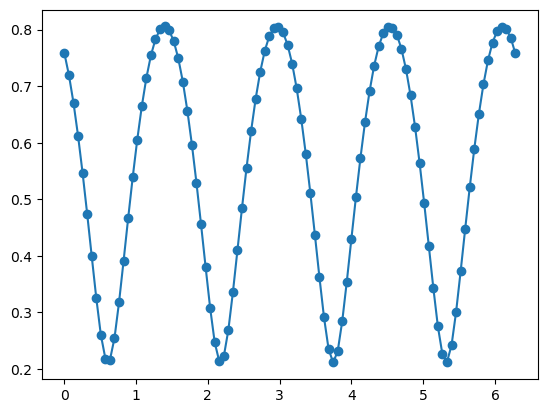

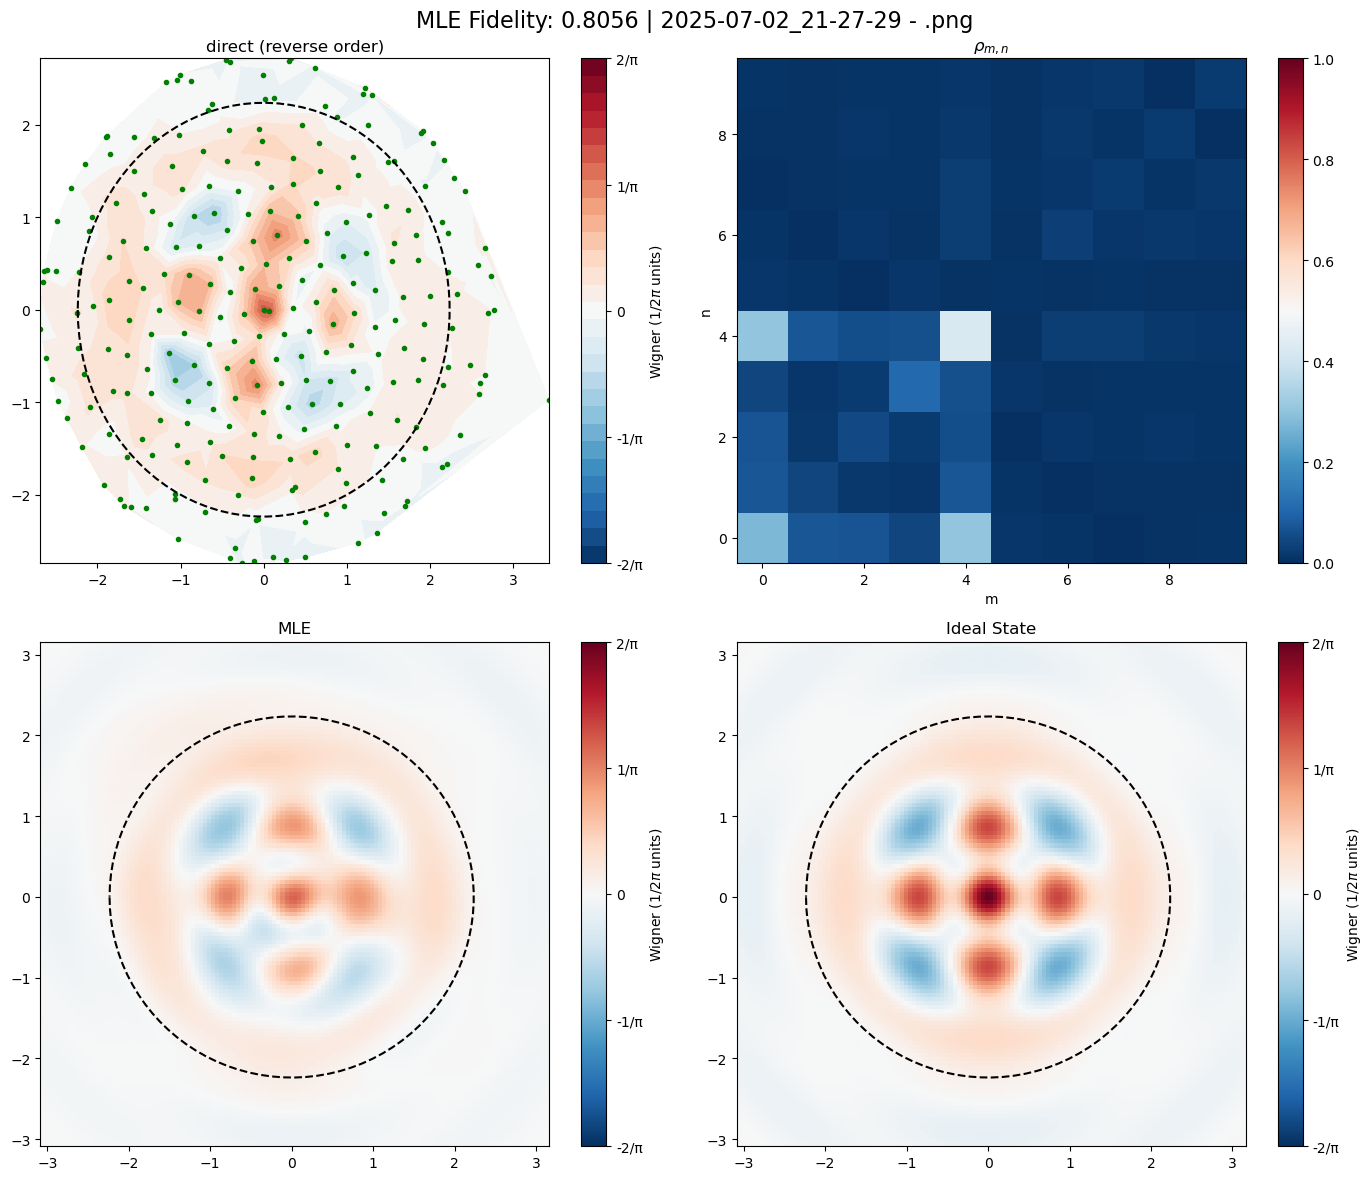

In [195]:
results = wigner_analysis.wigner_analysis_results((p_g -p_e), initial_state=initial_state, rotate=True)
fig = wigner_analysis.plot_wigner_reconstruction_results(results, initial_state=initial_state, state_label = '')

In [95]:
from scipy.linalg import expm
import qutip as qt
theta = np.linspace(0, 2 * np.pi, 100)
rho = results['rho']
rho_ideal = results['rho_ideal']
fid = np.zeros(len(theta))

for i, t in enumerate(theta):
    N = np.diag(np.arange(wigner_analysis.m))
    R = expm(1j * t * N)  # Rotation operator
    rho_rotated = R @ rho @ R.conj().T  # Rotate the density matrix
    fid[i] = qt.fidelity(qt.Qobj(rho_rotated), rho_ideal)


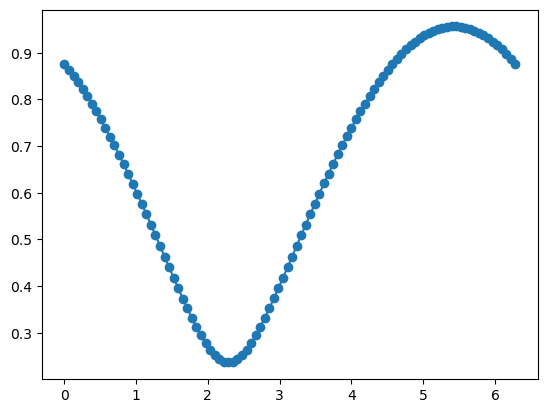

In [96]:
fig, ax = plt.subplots()
ax.plot(theta, fid, marker='o')

In [91]:
R = expm(1j * np.pi * N)
print(R@ R.conj().T)  # Rotate the density matrix by pi

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


## Swap against fidelity

In [ ]:
## Checking code
# stor = 7 #storage number from 1
# fock_n = 5 #fock numbers from 0
# swap_iter = 6 #even swaps from 0
# swaps_plot = [2*i for i in range(swap_iter)]


# for k in range(stor): #storage number
#     fock_dict = {"fock_"+str(fock_n): [] for fock_n in range(fock_n)}

#     for j in range(fock_n): #fock states 0 to 4
#         photon = j
#         fid_results = []
        
#         for i in range(swap_iter): #even no. of swaps from 0 to 10
#             swaps = 2*i
#             fid_results += [swaps+j+k]

#         print(f'Fidelity-swap results for fock ' +str(j) + ' in storage ' + str(k+1) + ':')
#         print(fid_results)
#         print(swaps_plot)
#         fock_dict['fock_'+str(j)].append(fid_results)

#     print(f'Storage {k+1} swap fidelity results:')
#     print(fock_dict)
#     plt.figure(figsize=(10, 6))    
#     for l in range(fock_n):
#         fock_i = fock_dict['fock_'+str(l)][0]
#         plt.plot(swaps_plot, fock_i, marker='o', label='Fock ' + str(fock_n))
#     # plt.plot(indices, fock_0, marker='o', label='Fock 0')
#     plt.xlabel('Number of Swaps')
#     plt.ylabel('Fidelity')
#     plt.title(f'Fidelity vs Number of Swaps for Fock ' + str(j) + ' in Storage ' + str(k+1))
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

doing 0 swaps for fock 0 in storage 1
Pulse correction is applied


  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

C:\_Lib\python\multimode_expts\fitting_folder\wigner.py:303: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Pulse correction is applied


  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

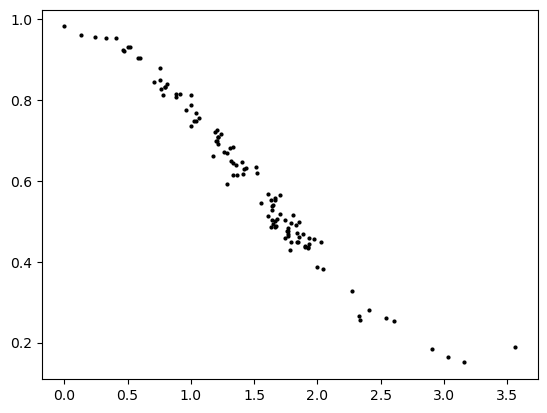

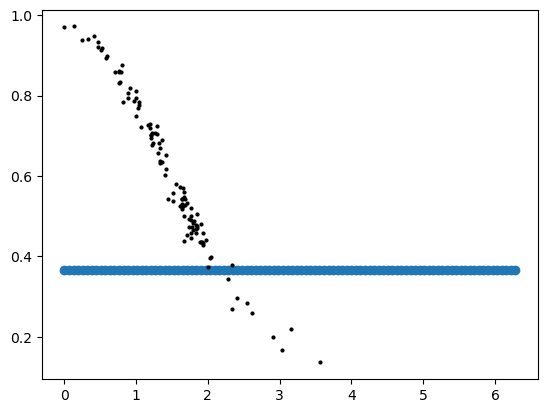

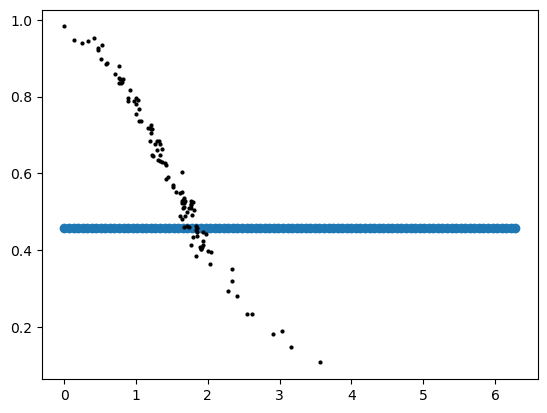

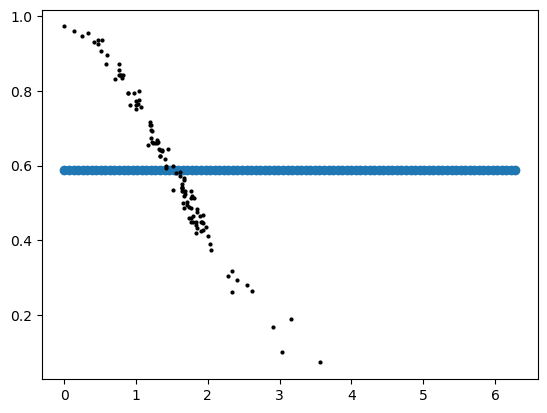

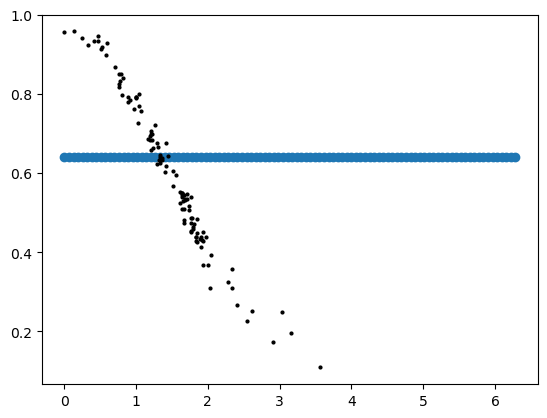

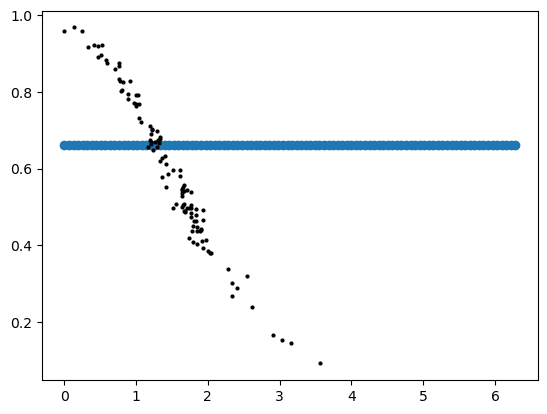

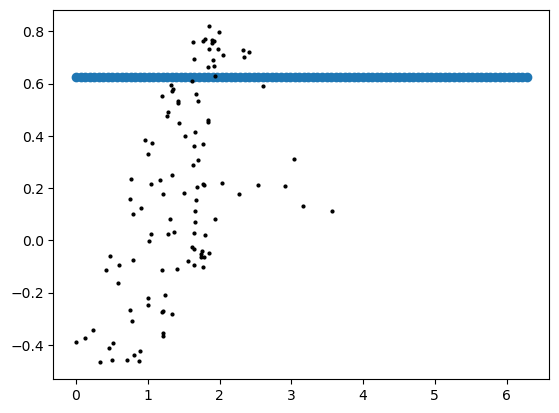

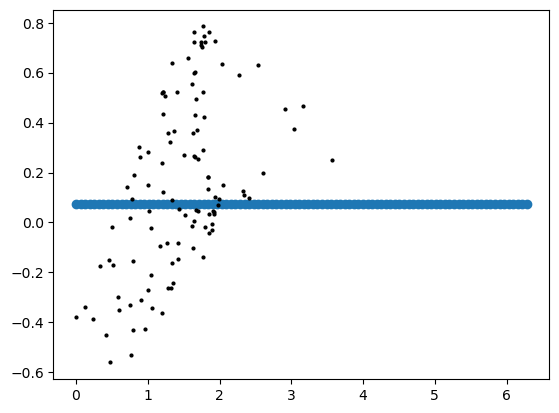

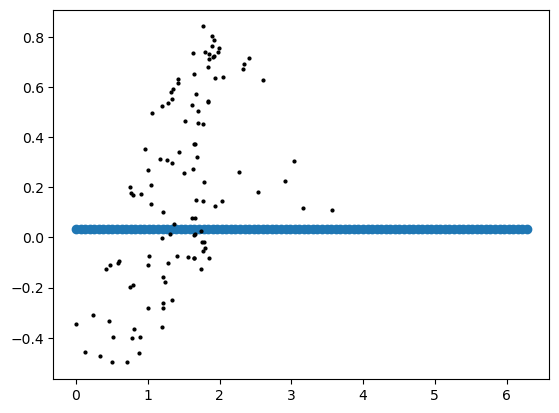

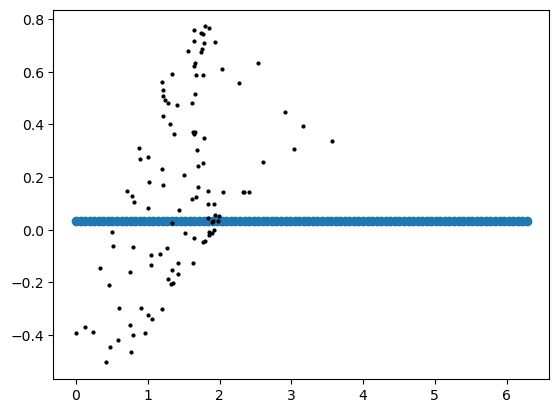

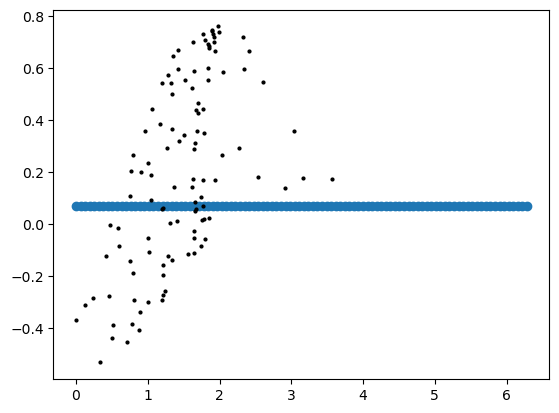

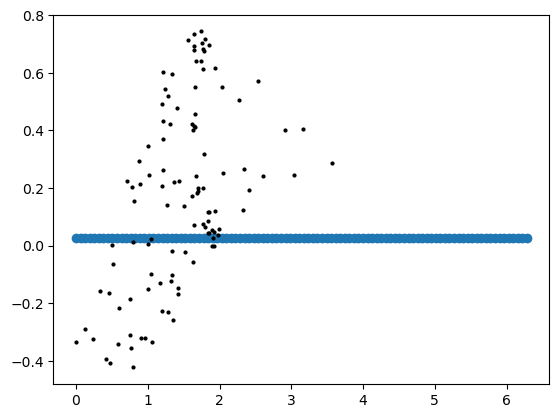

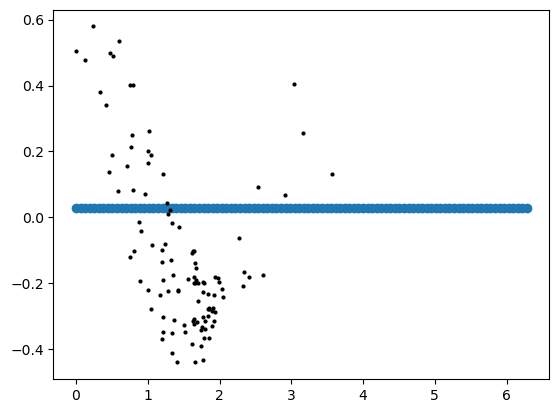

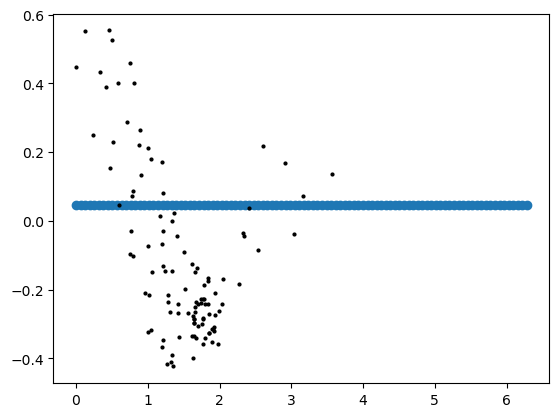

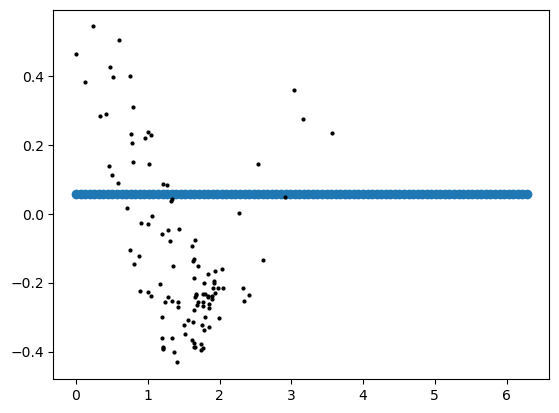

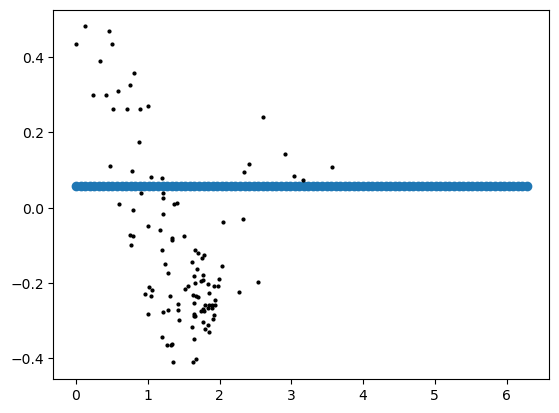

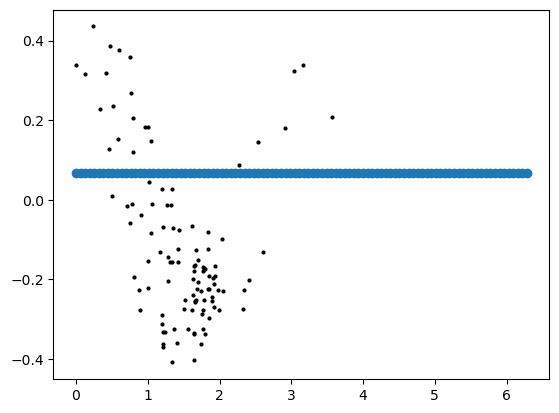

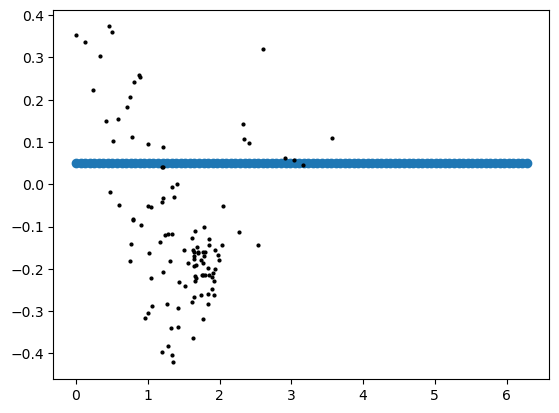

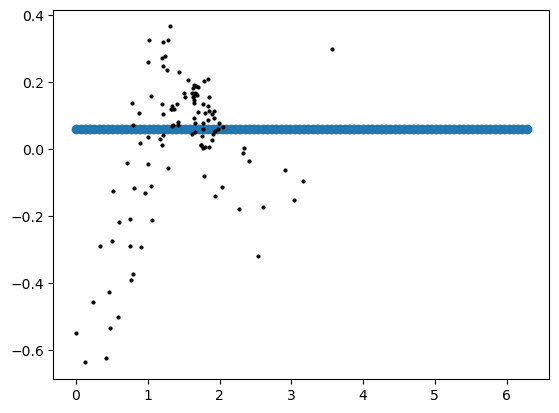

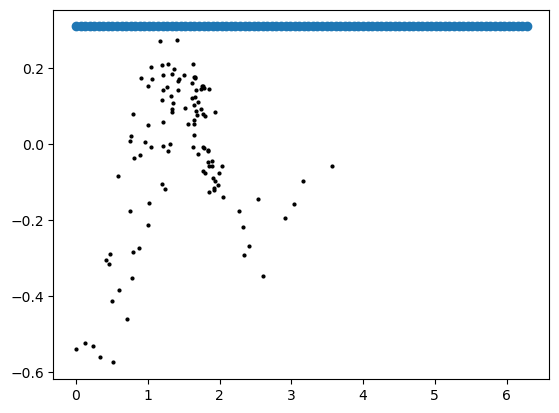

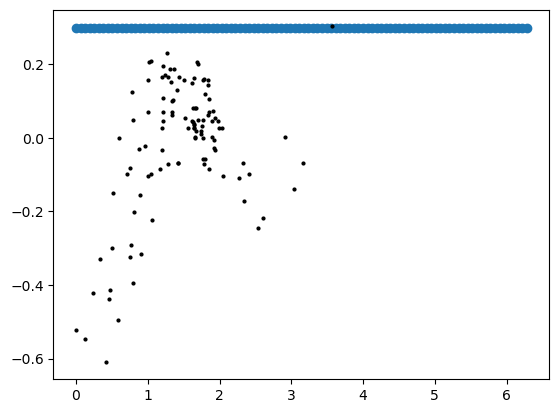

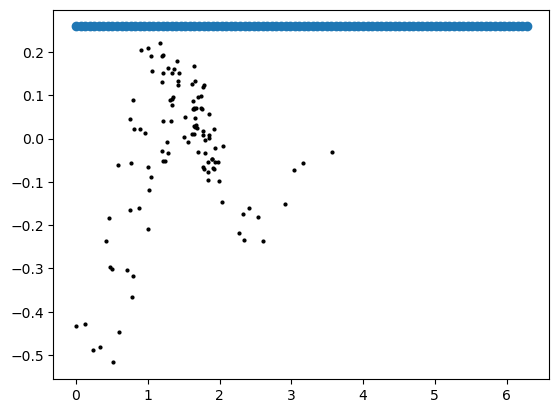

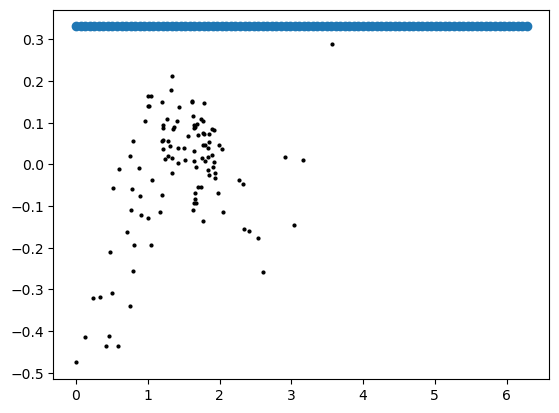

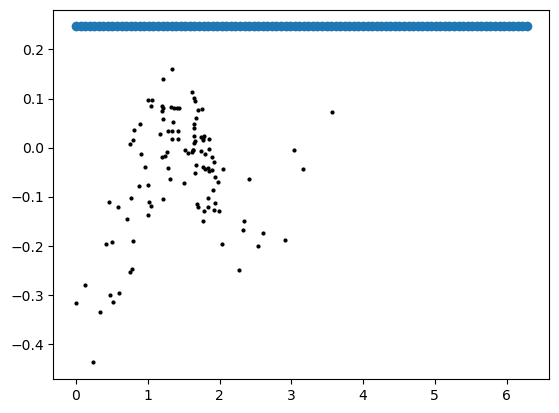

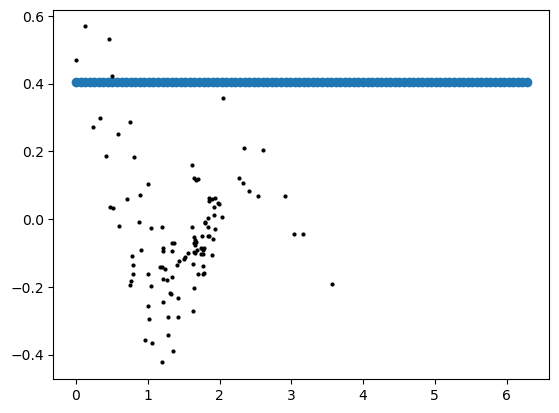

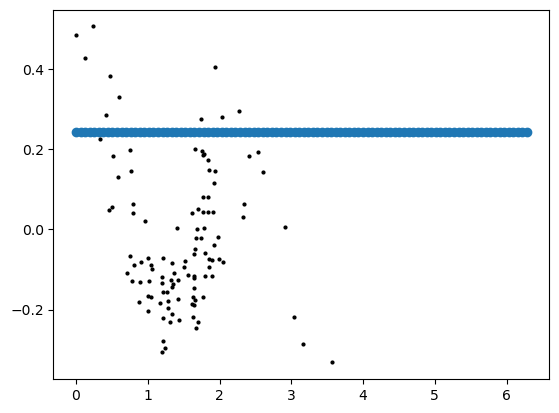

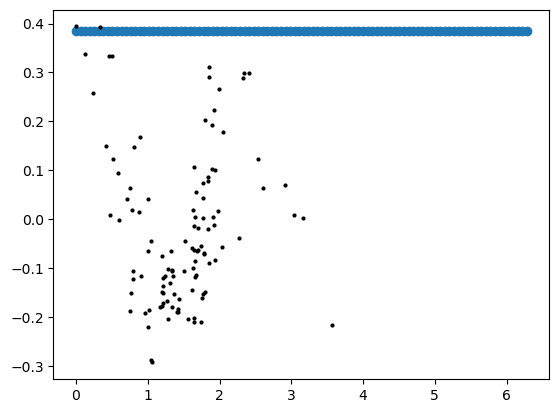

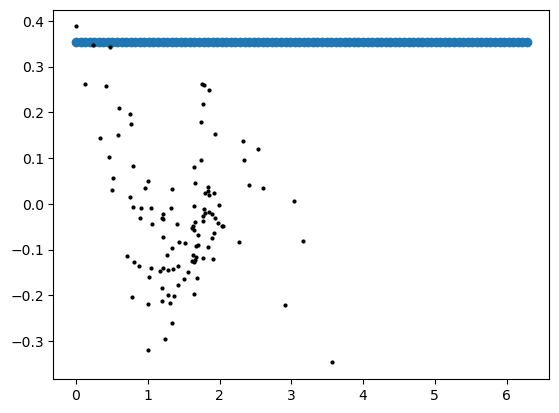

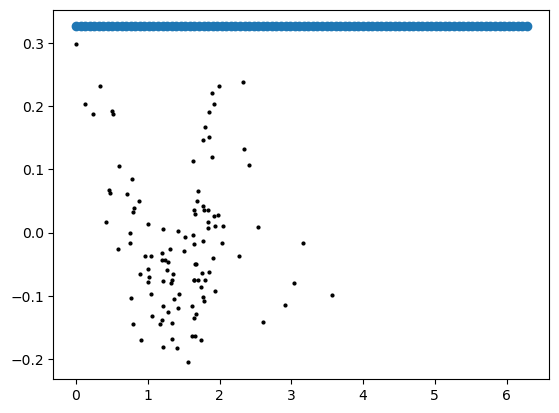

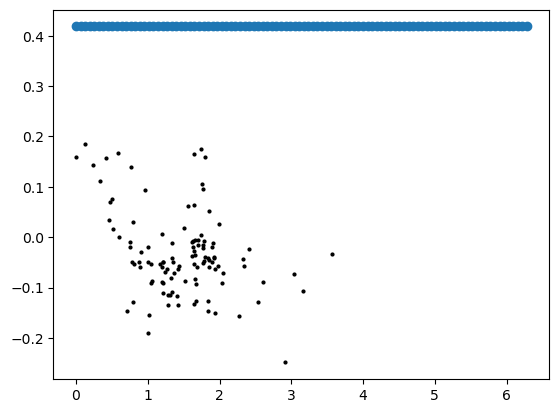

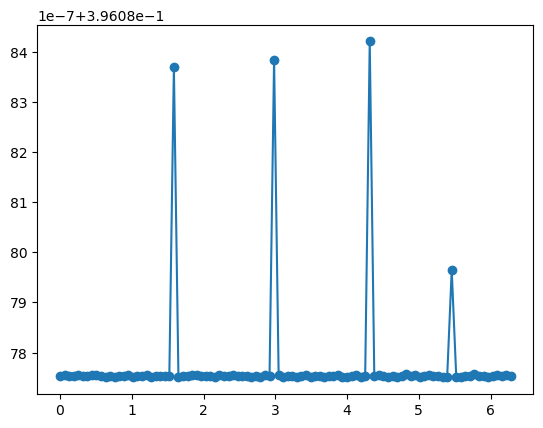

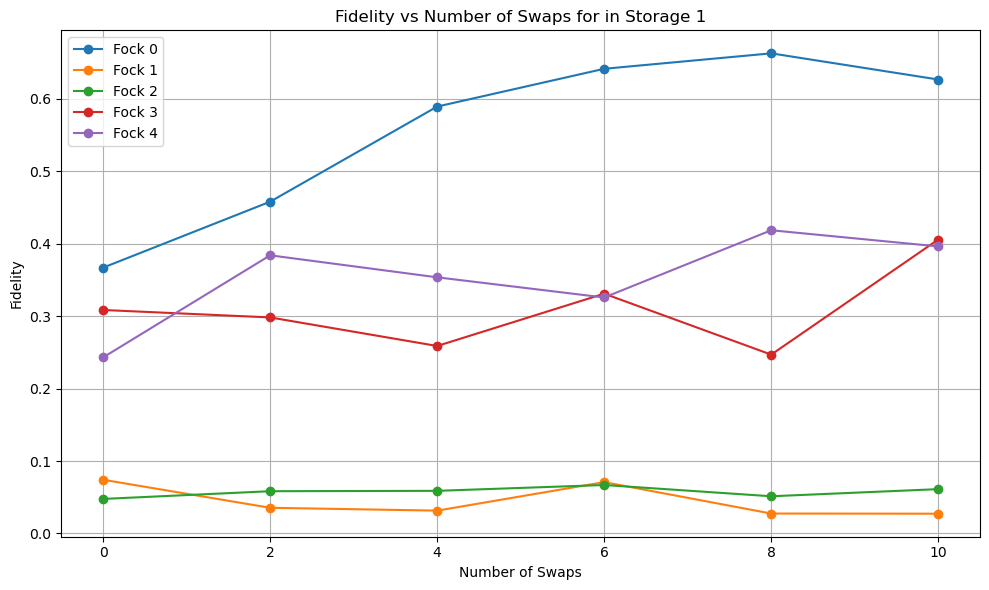

doing 0 swaps for fock 0 in storage 2
Pulse correction is applied


  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

C:\_Lib\python\multimode_expts\fitting_folder\wigner.py:303: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


0.1994093830593503
doing 4 swaps for fock 3 in storage 2
Pulse correction is applied


  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

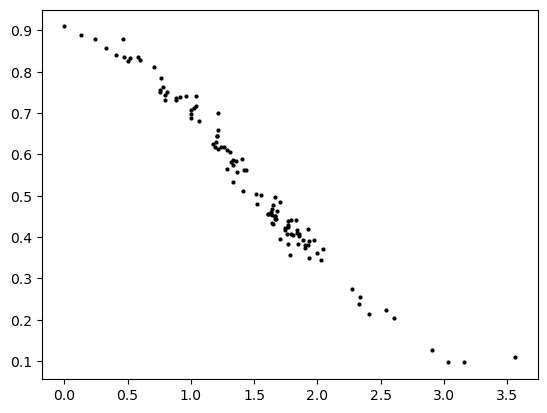

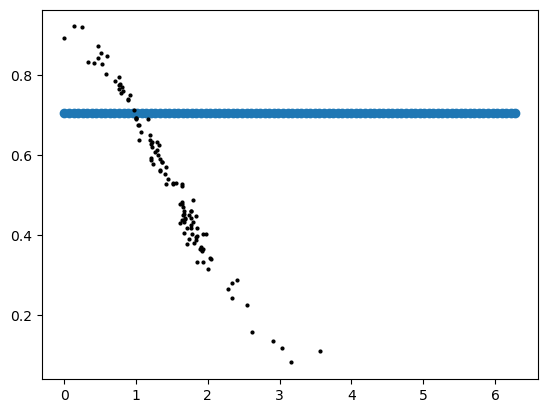

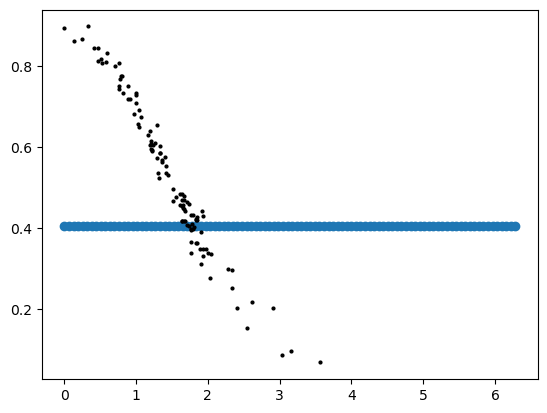

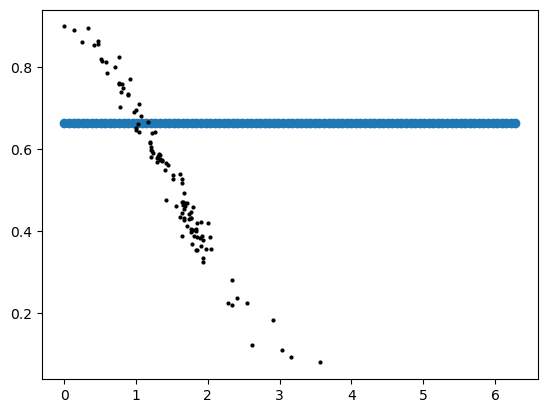

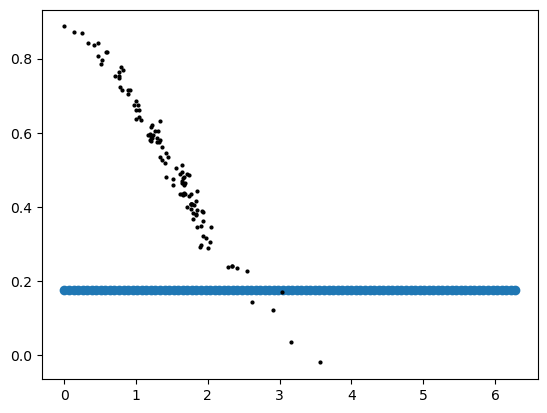

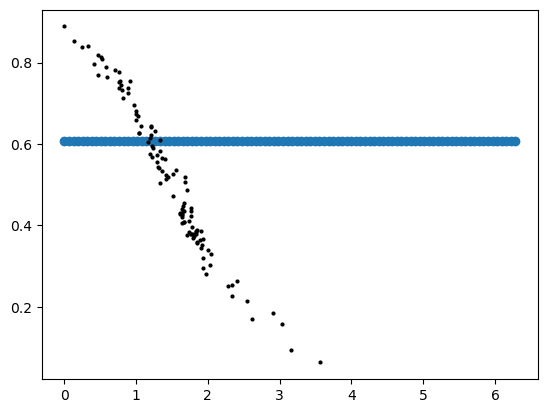

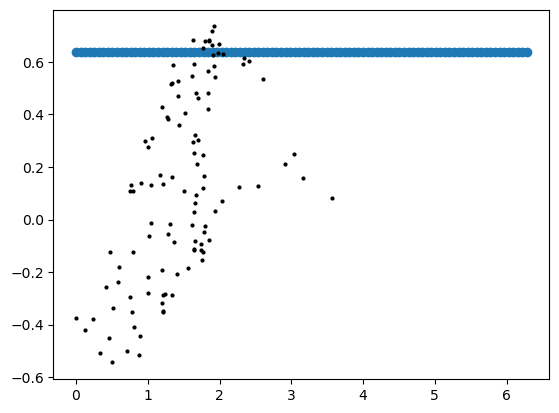

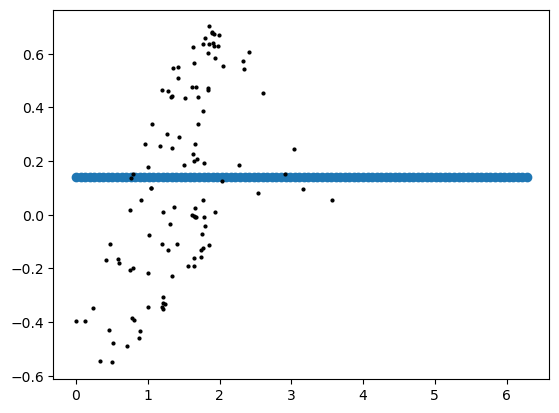

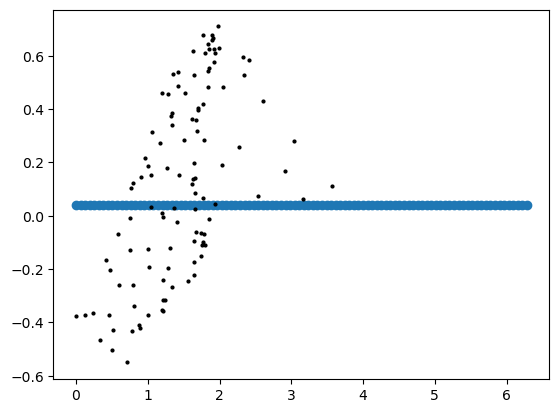

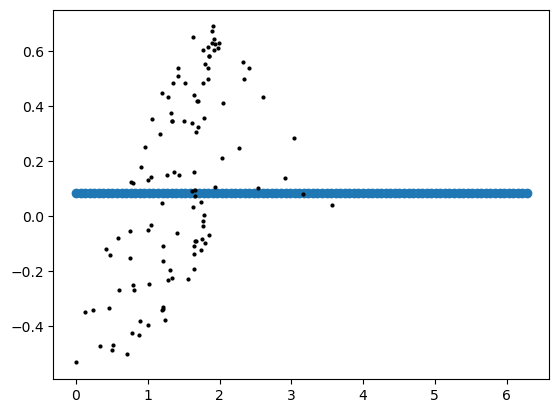

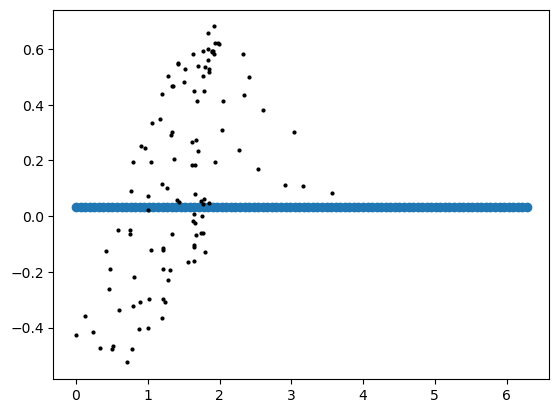

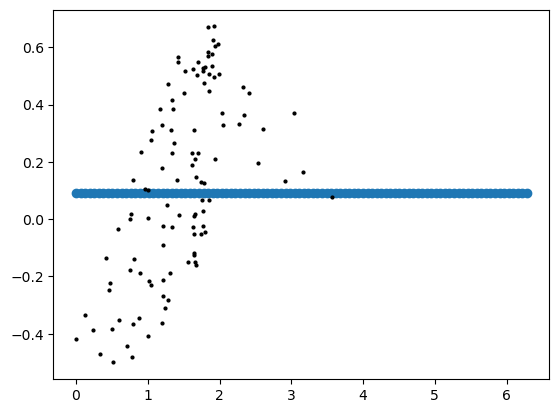

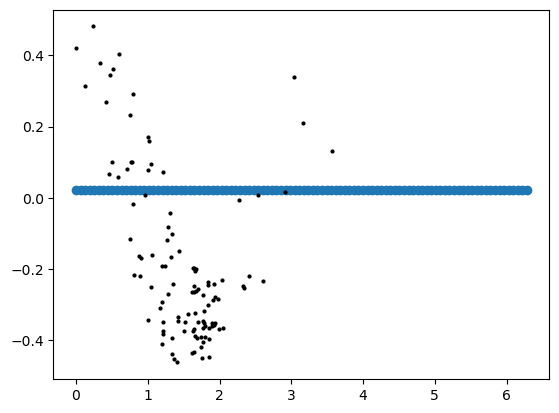

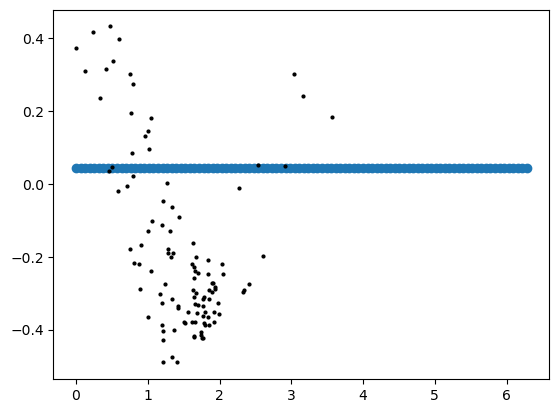

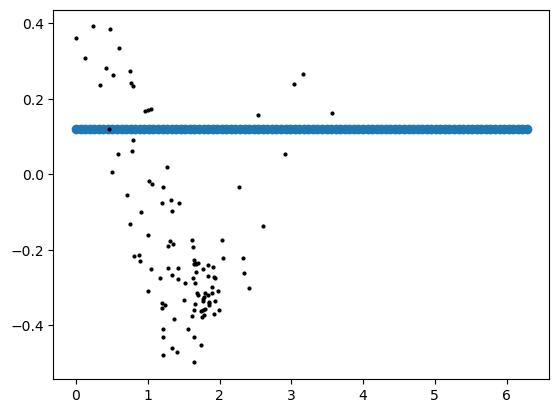

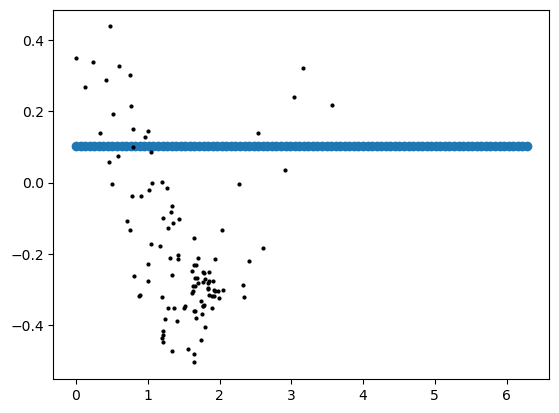

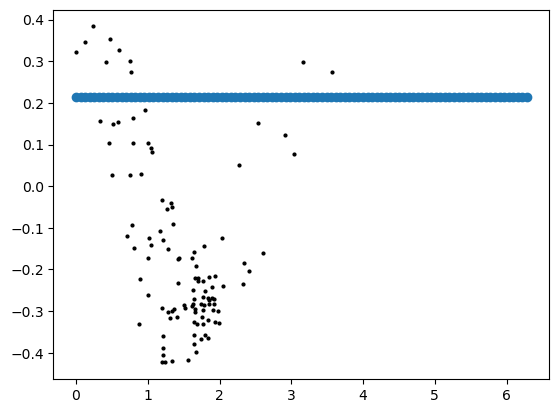

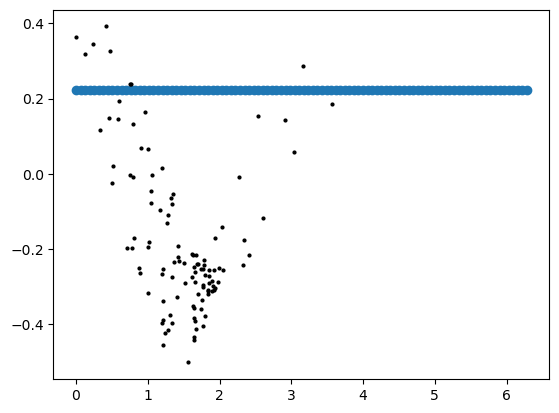

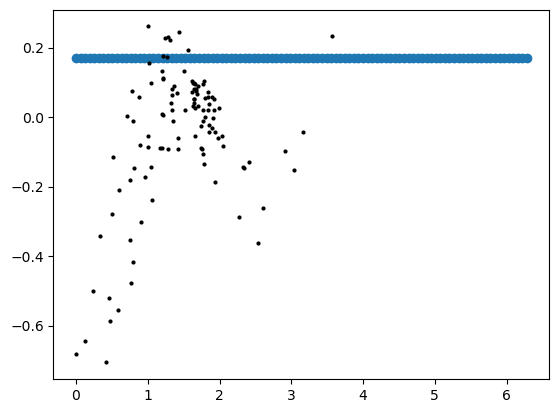

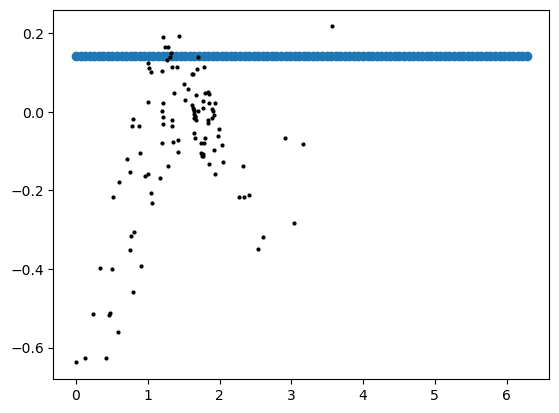

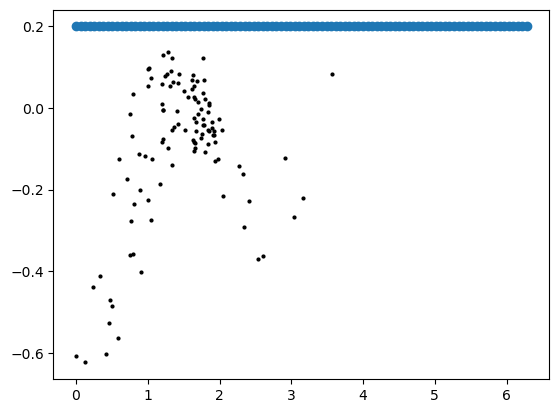

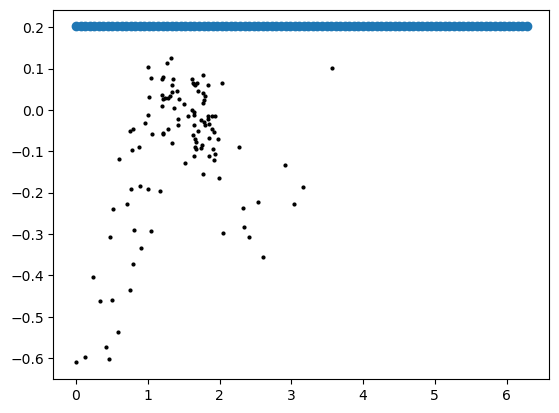

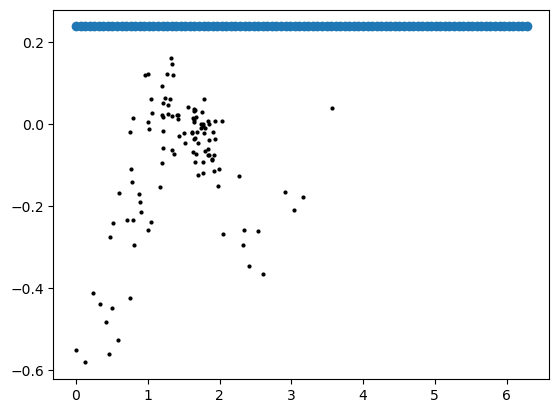

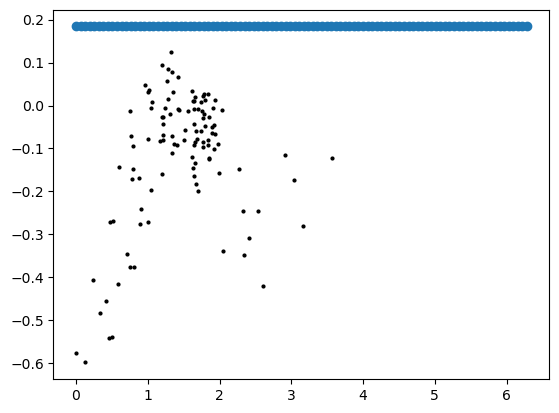

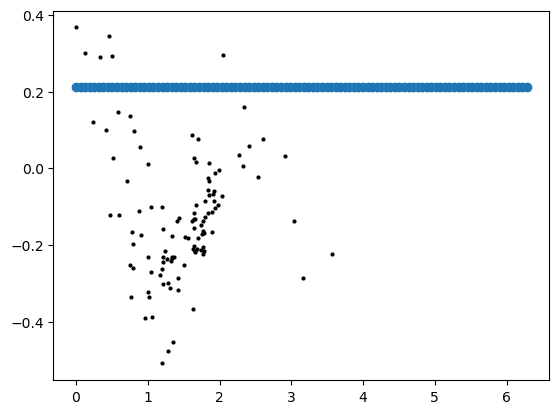

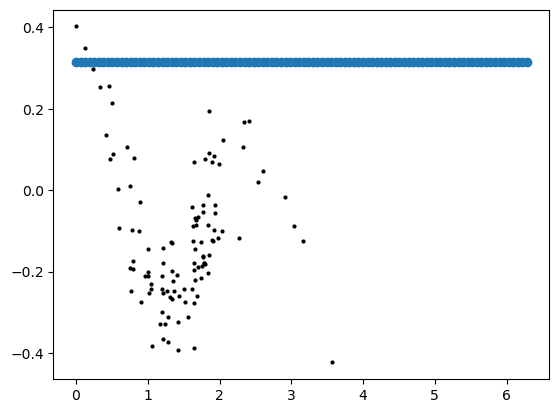

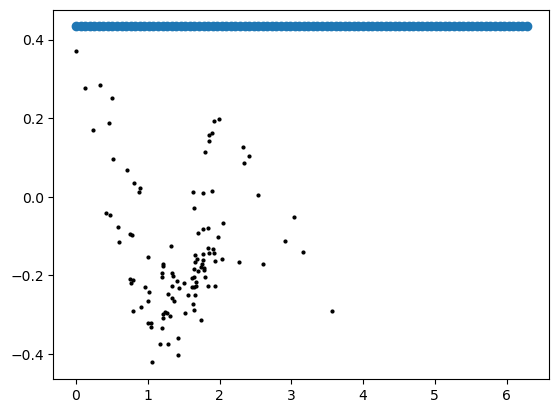

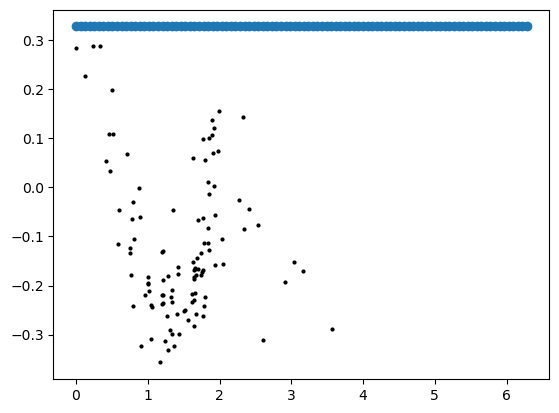

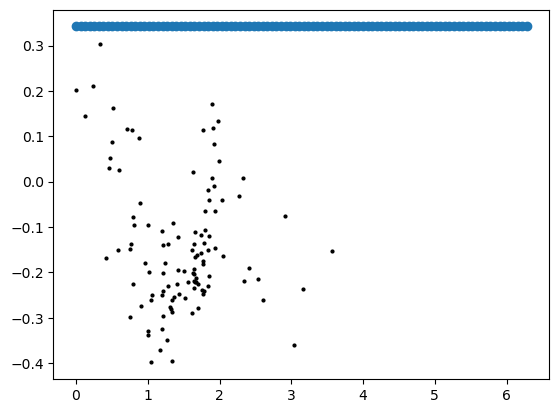

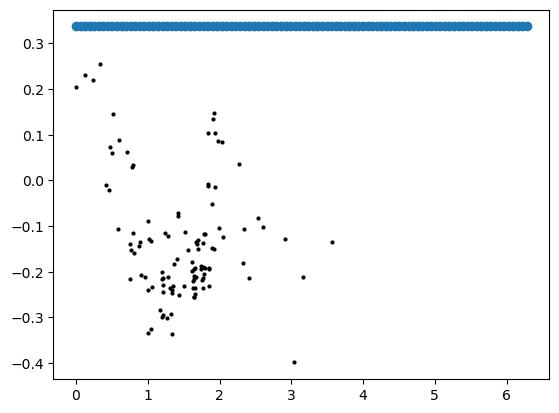

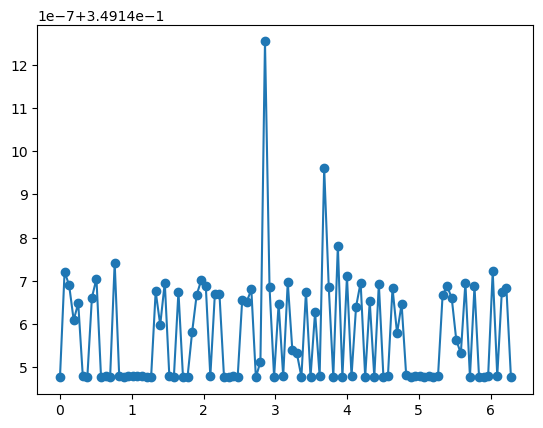

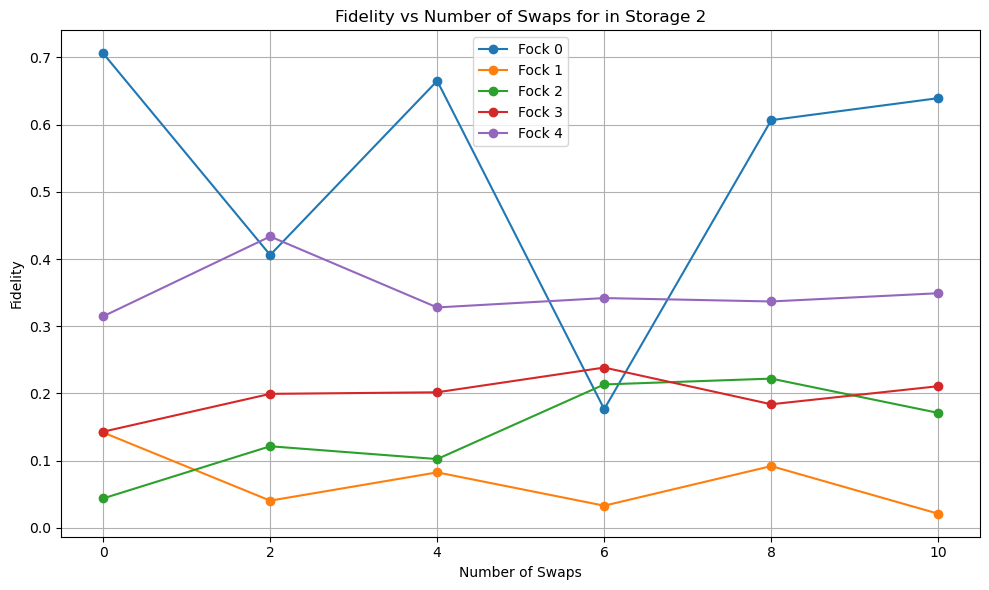

doing 0 swaps for fock 0 in storage 3
Pulse correction is applied


  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

C:\_Lib\python\multimode_expts\fitting_folder\wigner.py:303: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


0.34349873727148655
doing 4 swaps for fock 3 in storage 3
Pulse correction is applied


  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

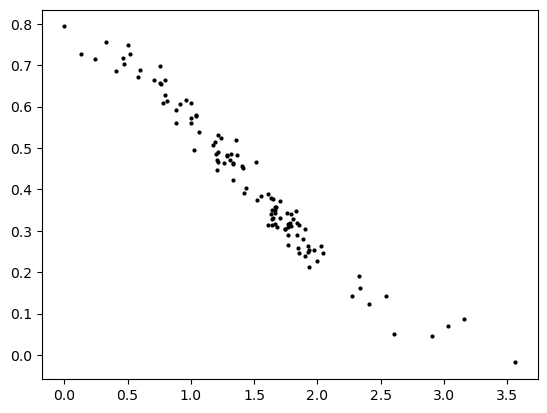

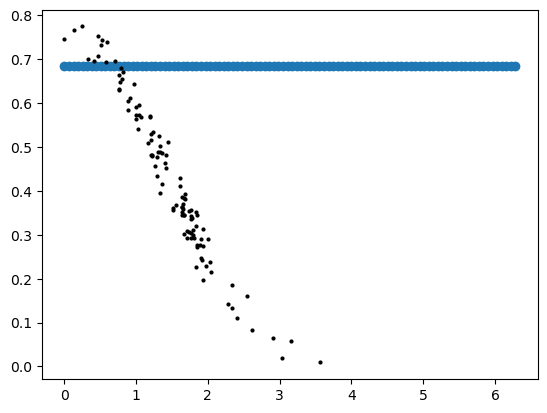

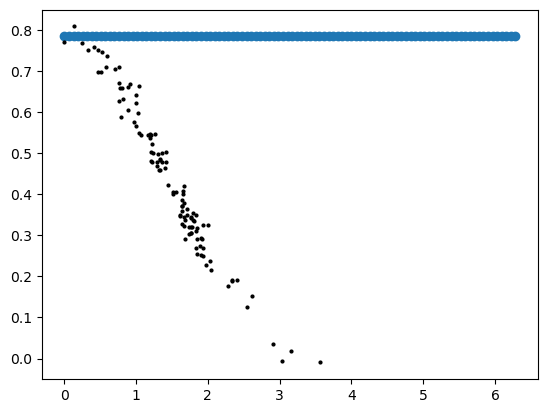

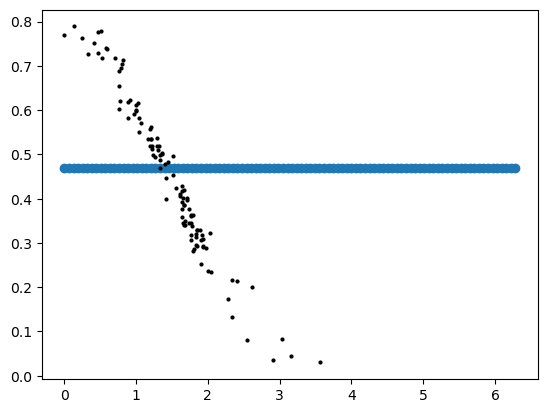

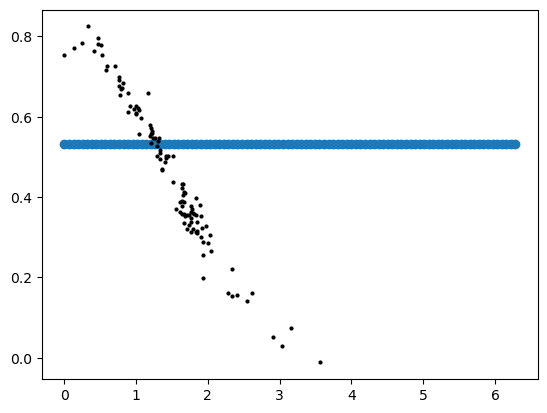

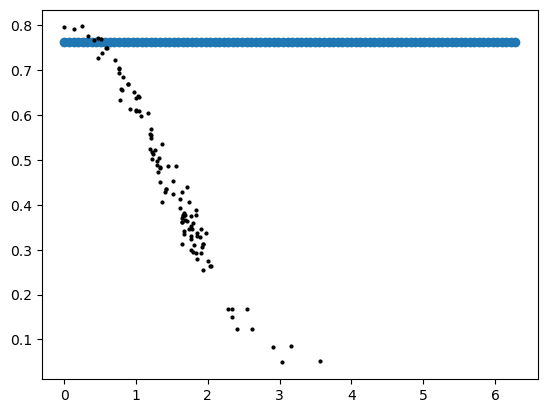

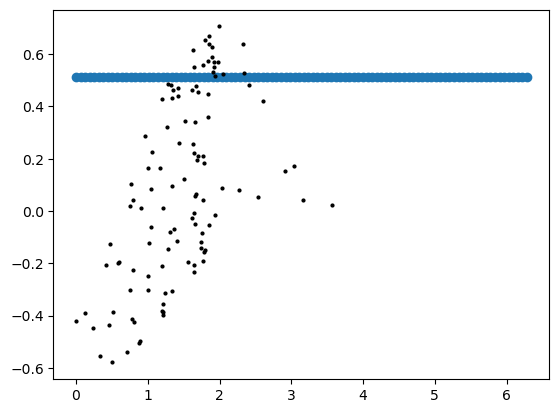

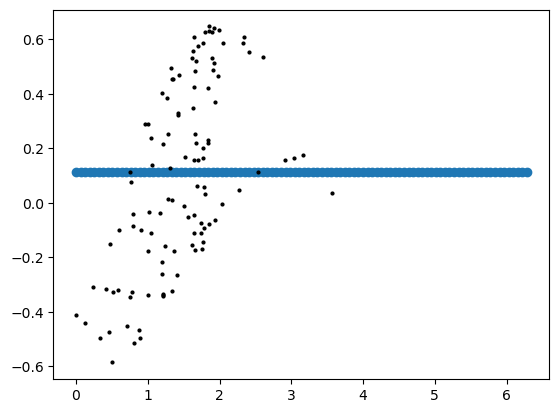

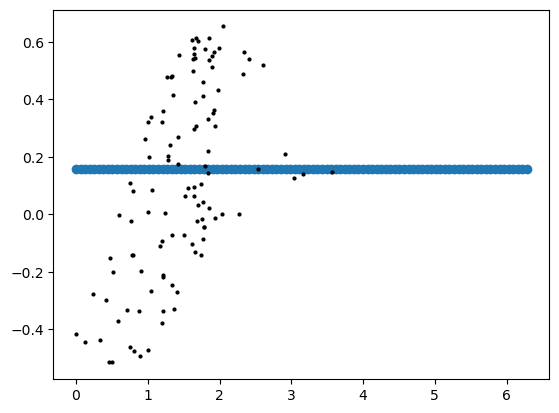

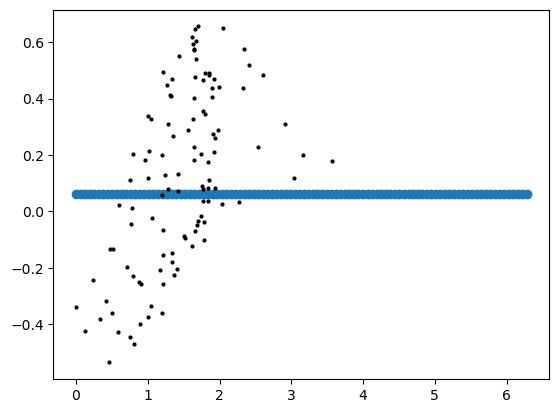

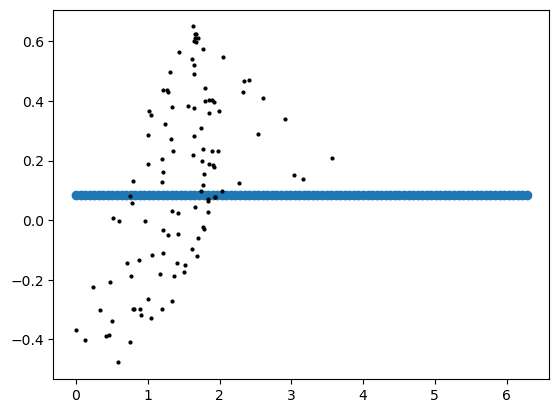

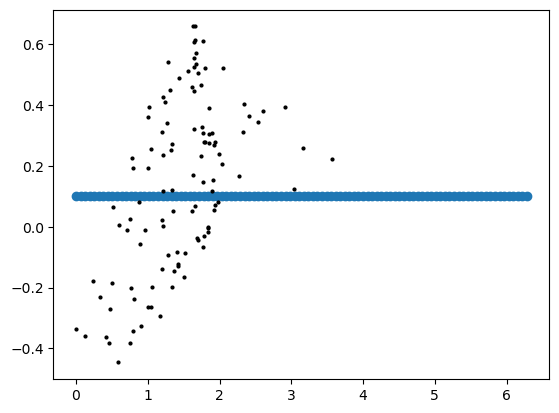

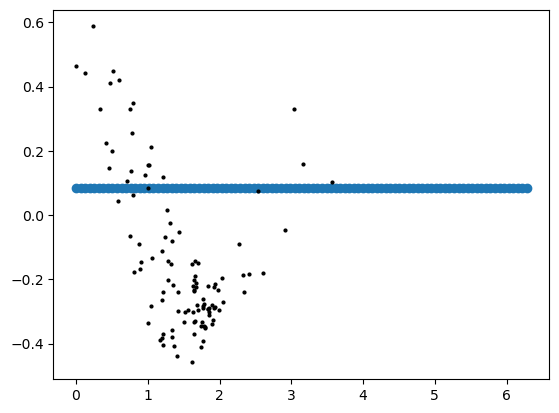

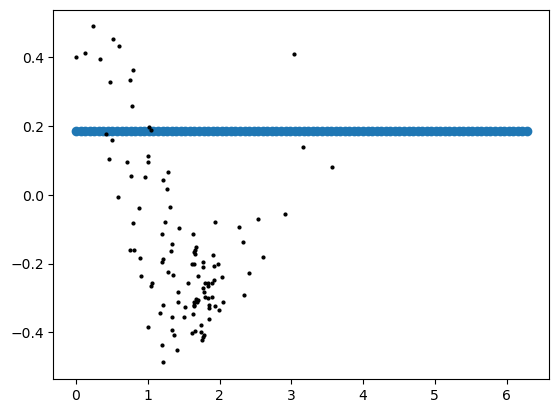

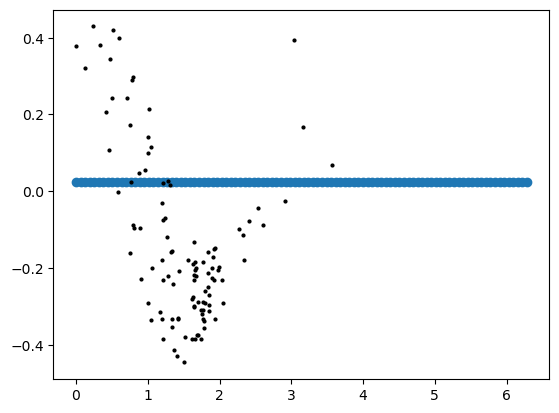

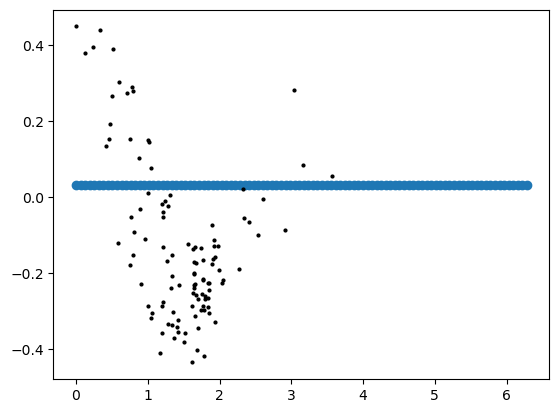

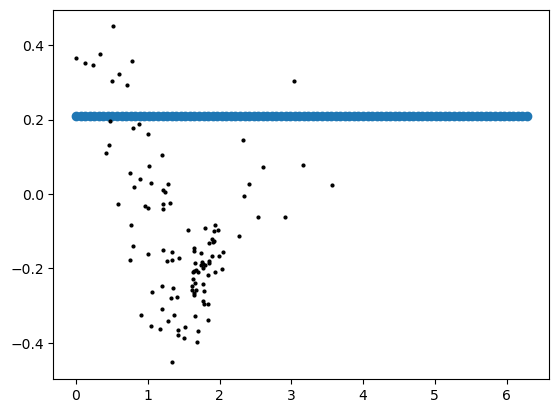

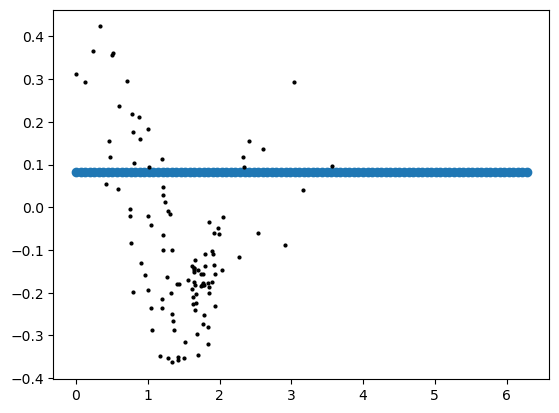

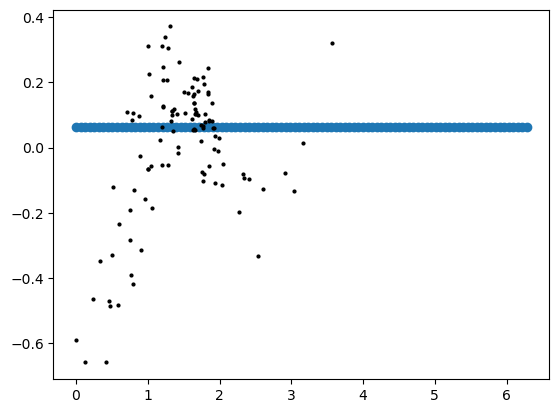

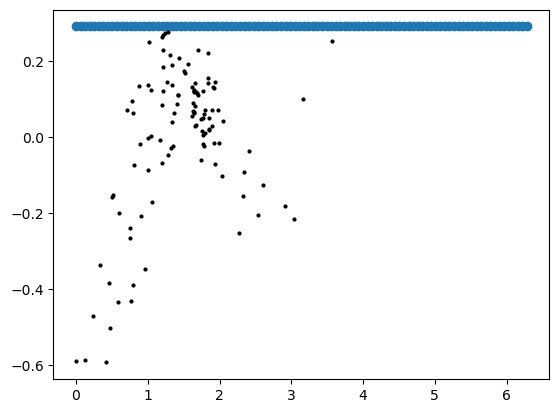

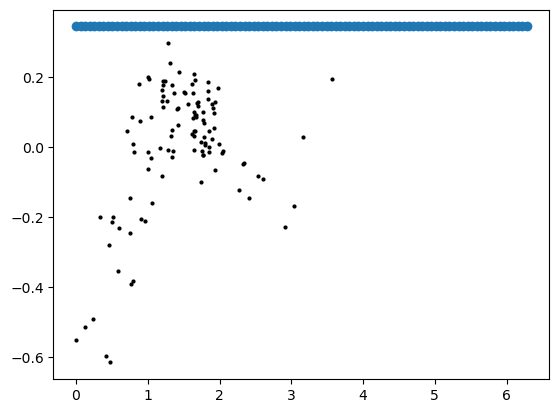

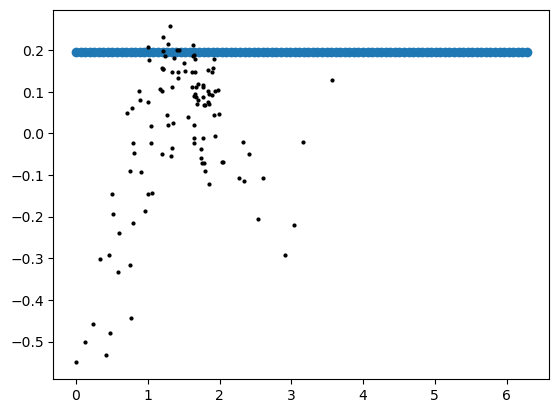

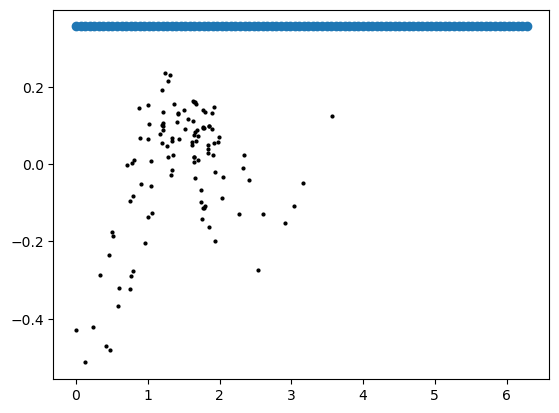

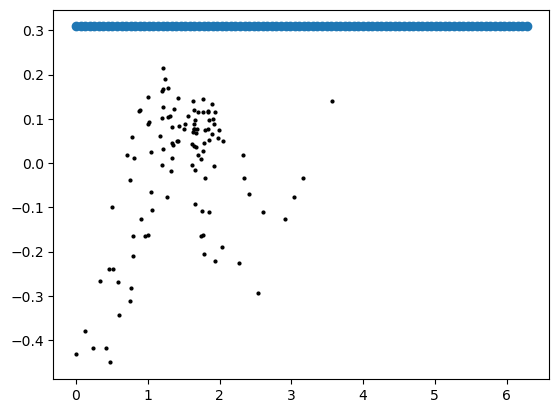

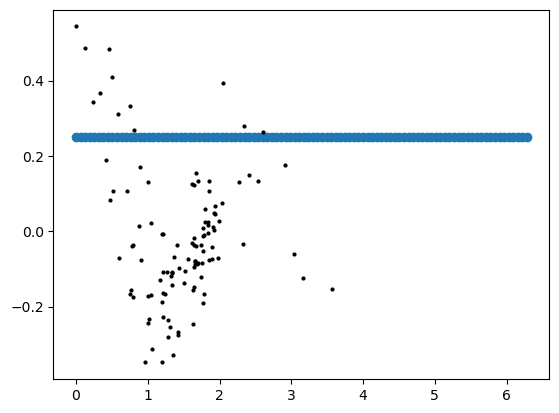

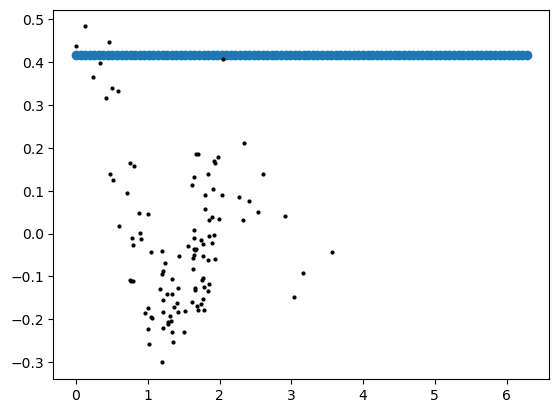

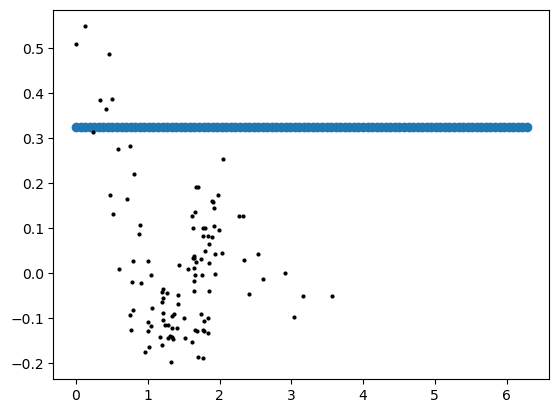

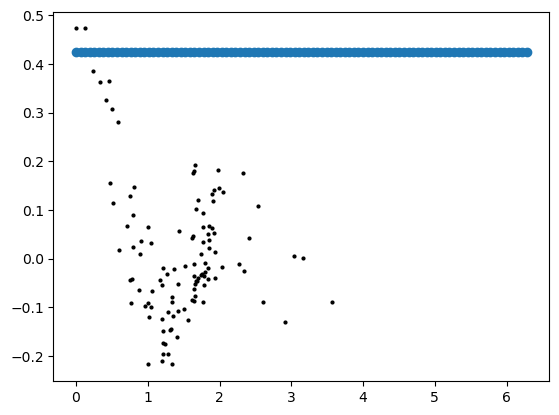

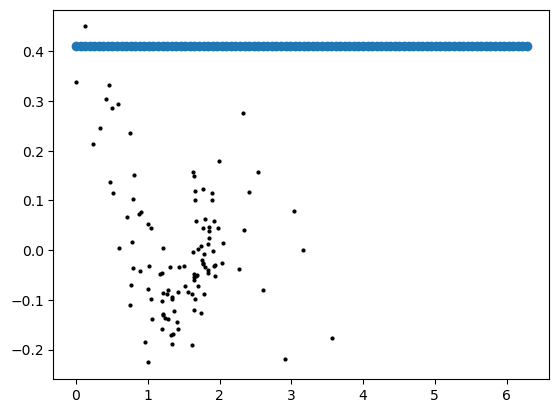

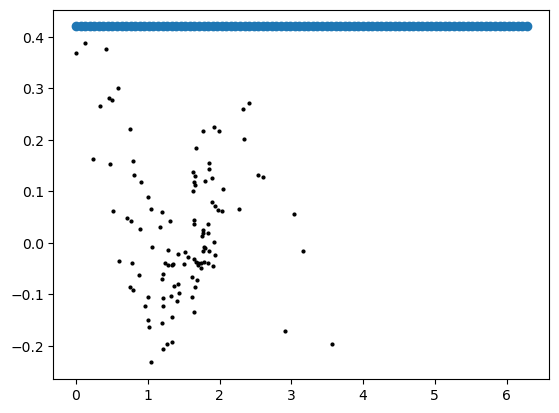

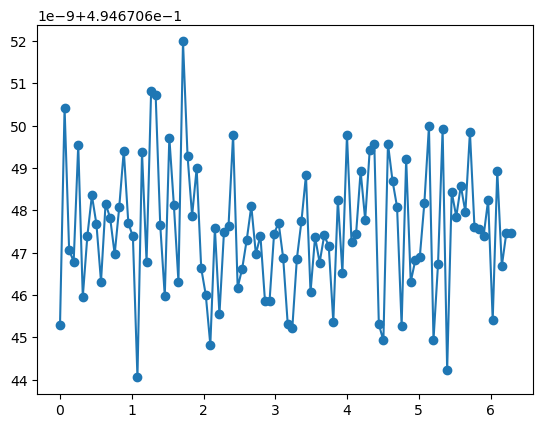

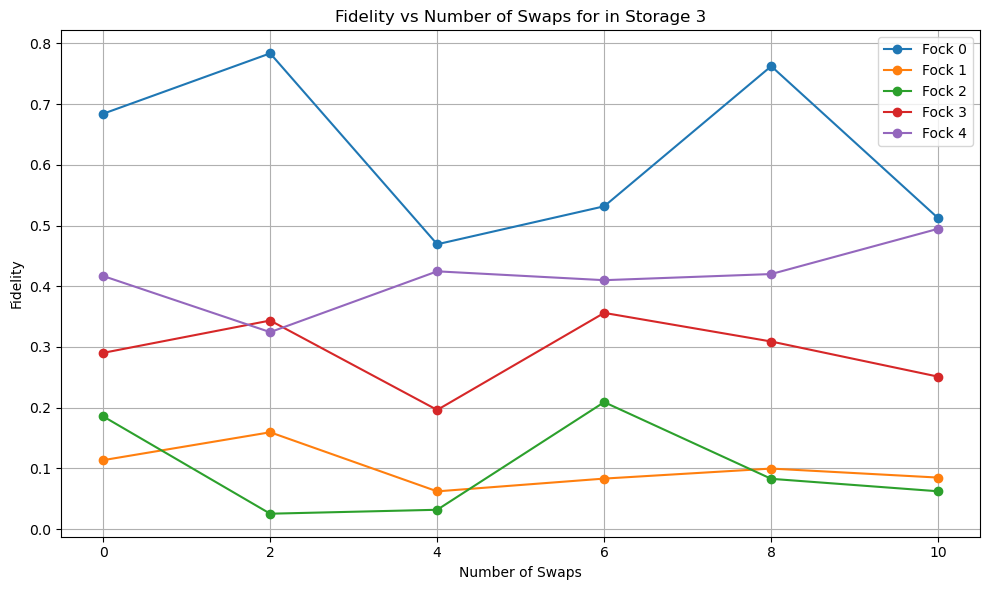

doing 0 swaps for fock 0 in storage 4
Pulse correction is applied


  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

C:\_Lib\python\multimode_expts\fitting_folder\wigner.py:303: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


0.2593804220724623
doing 4 swaps for fock 3 in storage 4
Pulse correction is applied


  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

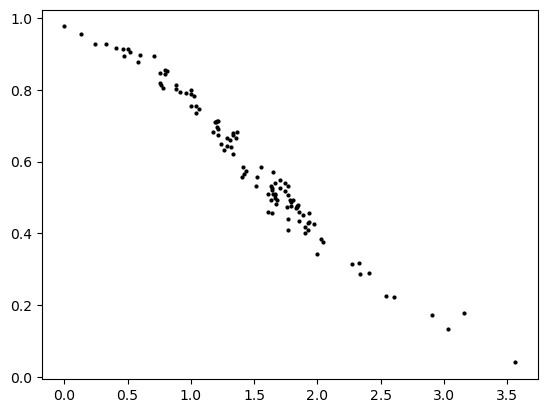

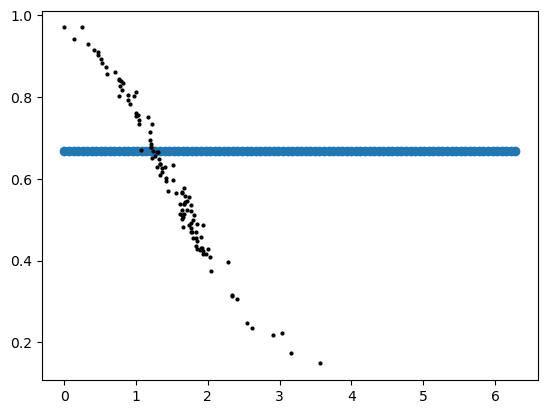

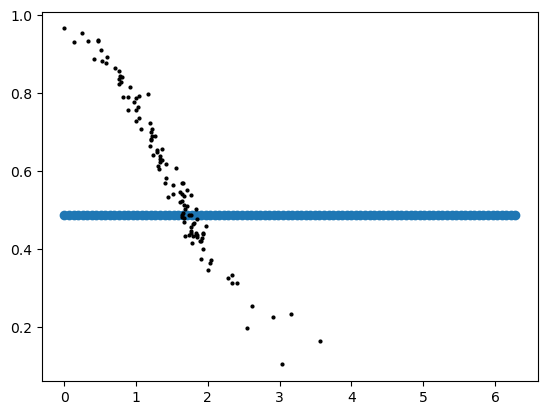

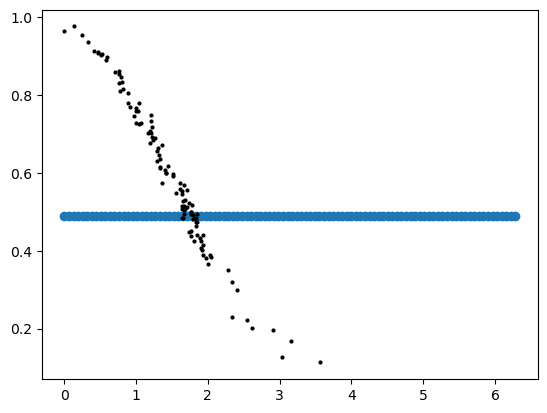

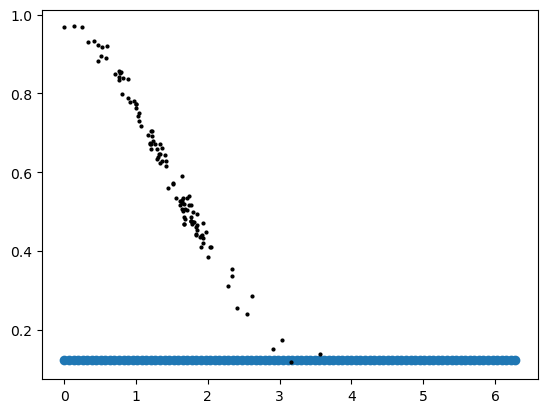

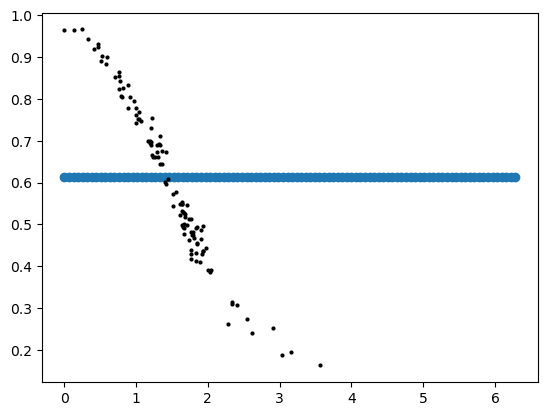

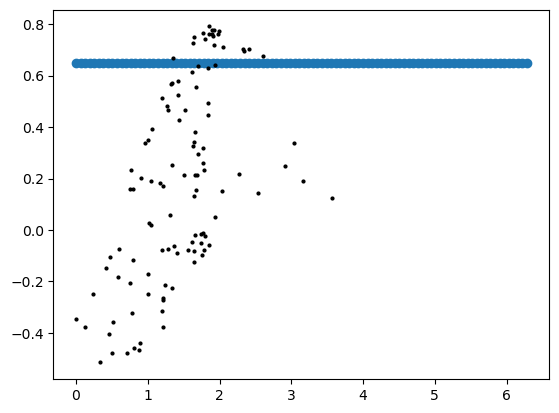

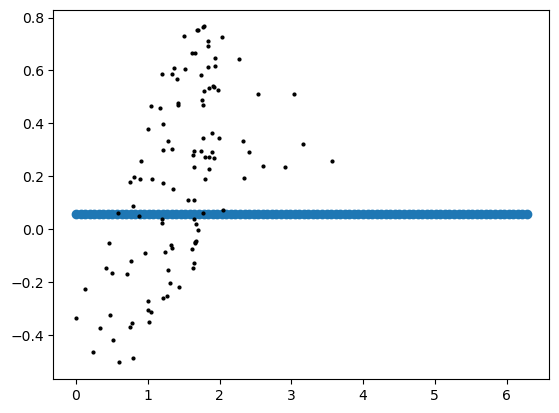

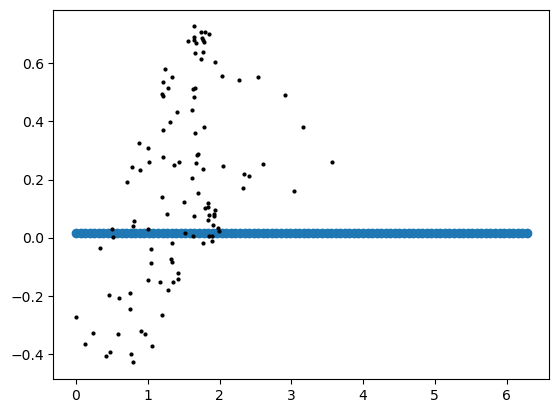

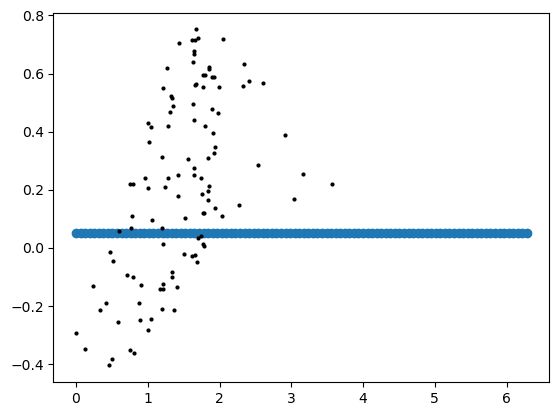

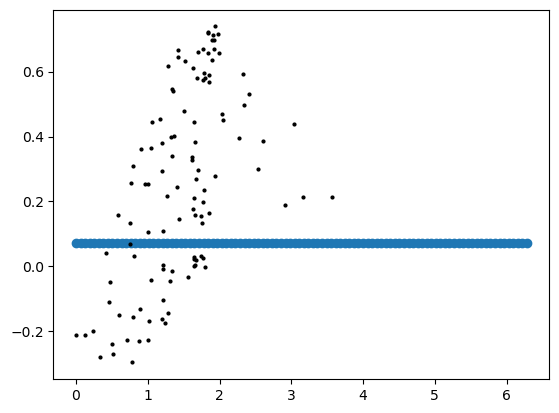

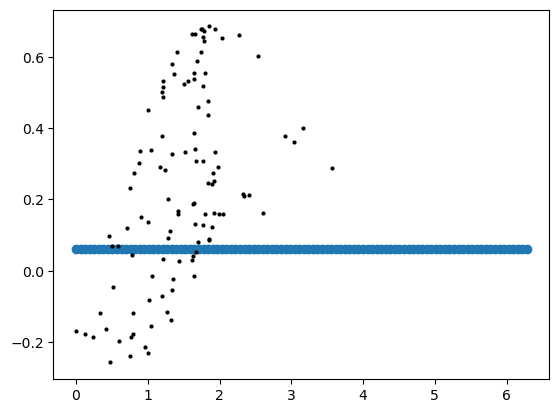

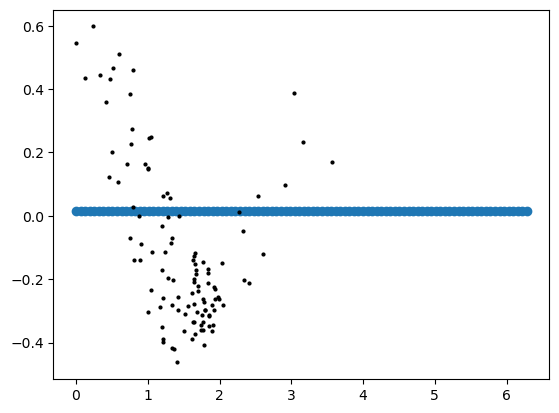

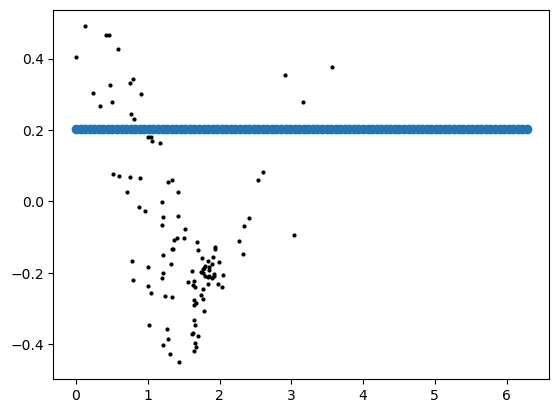

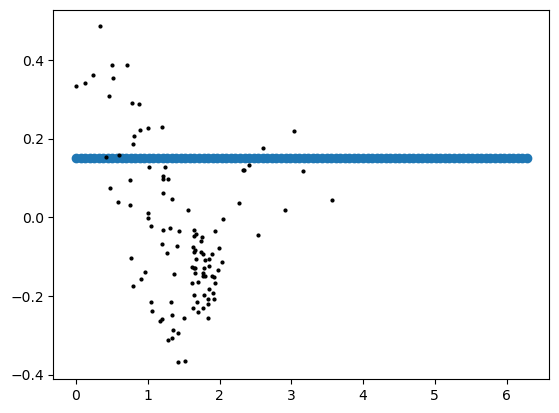

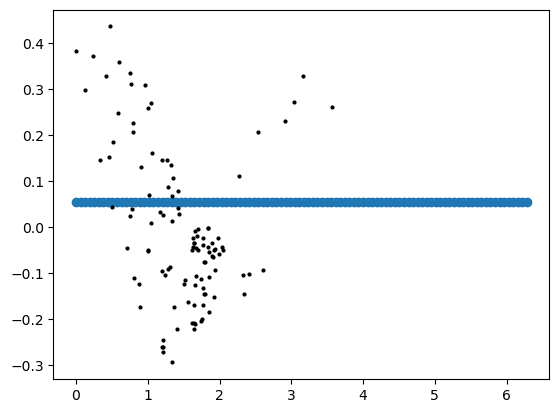

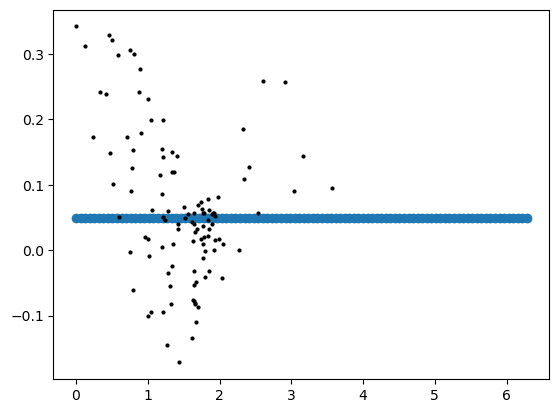

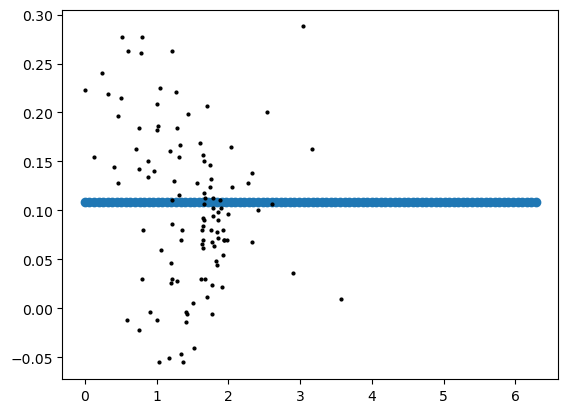

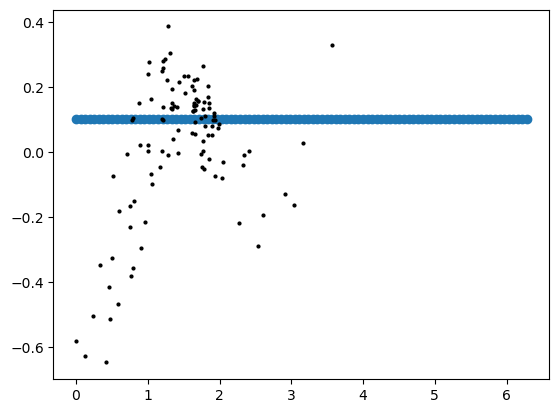

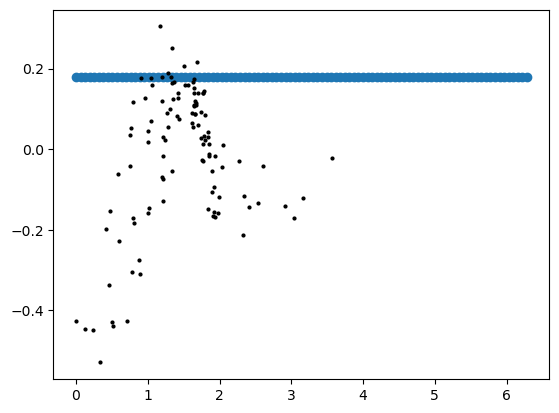

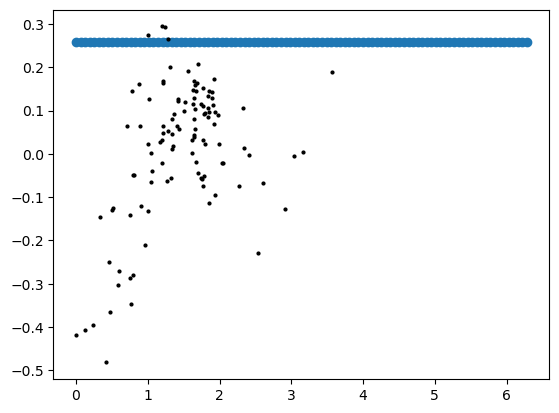

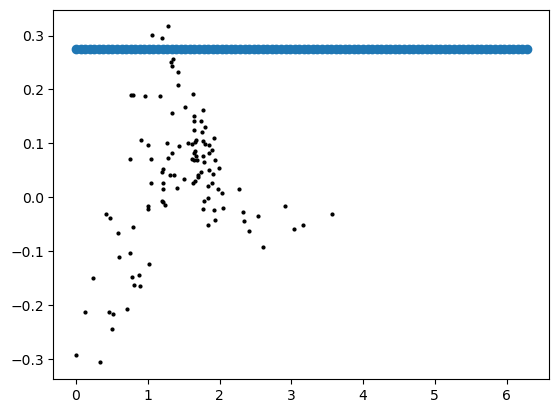

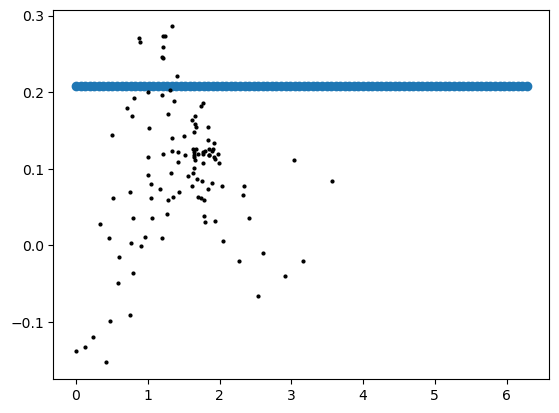

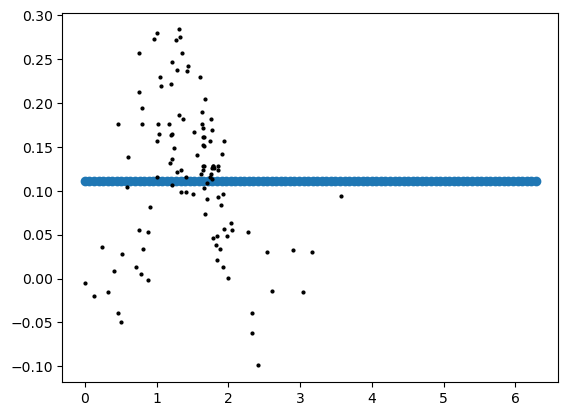

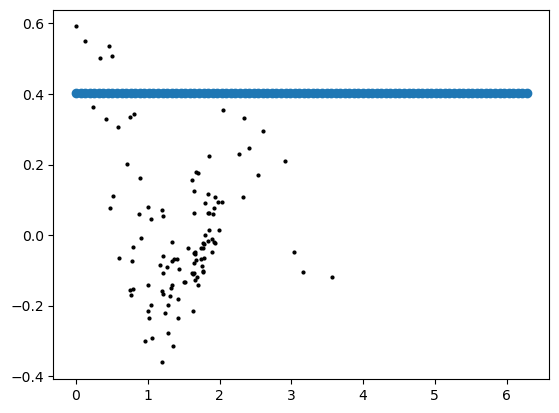

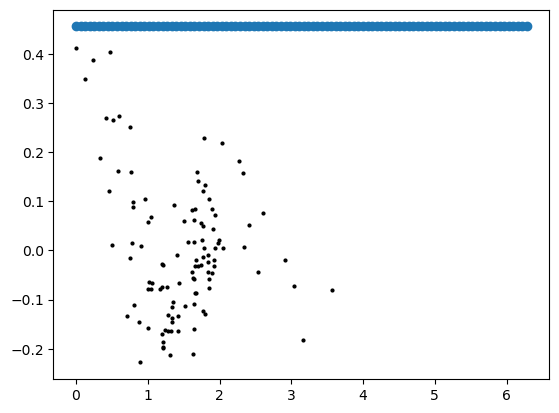

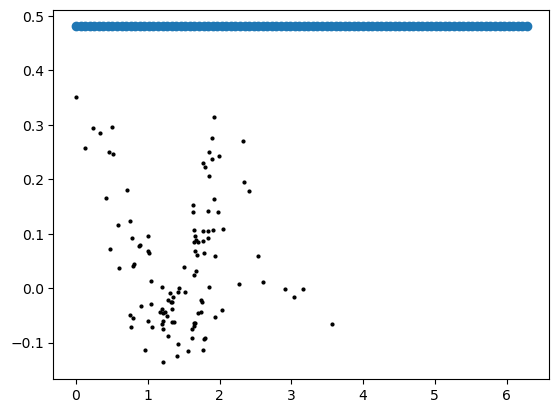

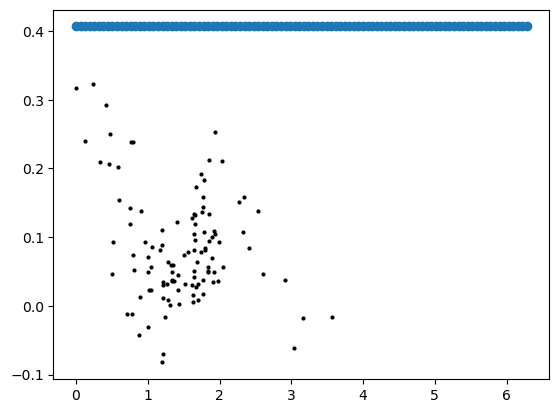

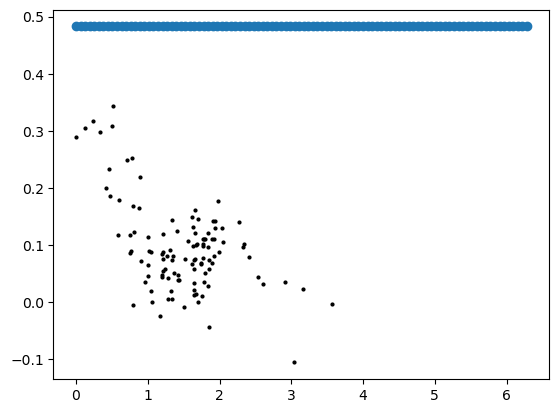

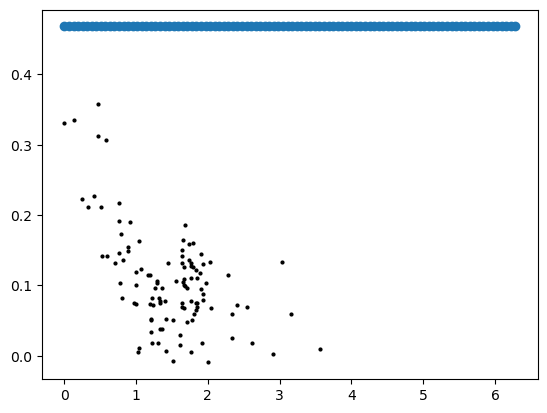

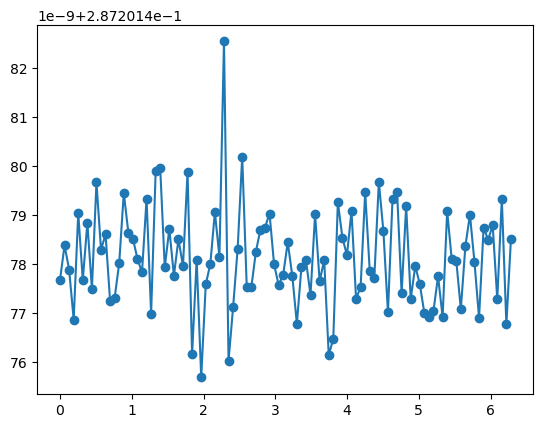

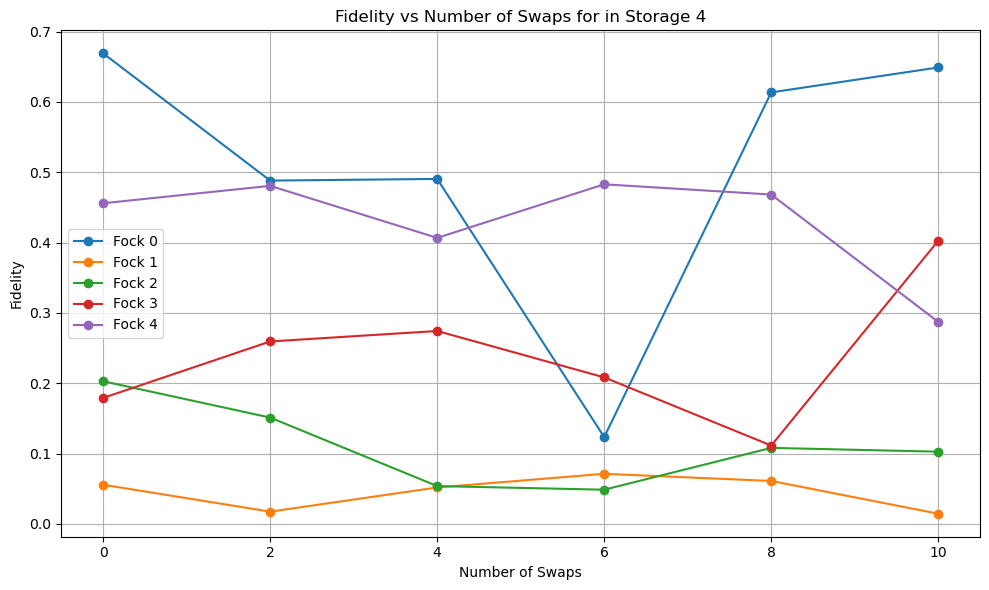

doing 0 swaps for fock 0 in storage 5
Pulse correction is applied


  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

C:\_Lib\python\multimode_expts\fitting_folder\wigner.py:303: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


0.2551917837041946
doing 4 swaps for fock 3 in storage 5
Pulse correction is applied


  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

  0%|          | 0/111 [00:00<?, ?it/s]

phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pulse: 180
phase second pul

KeyboardInterrupt: 

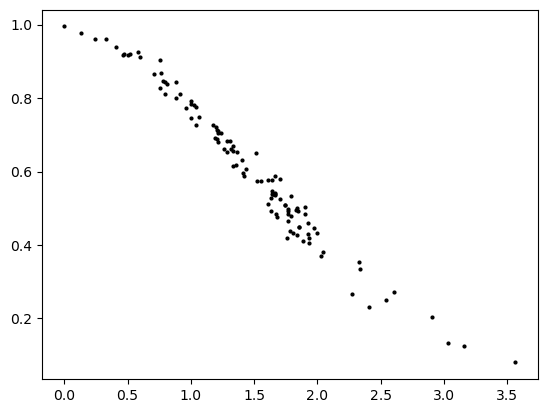

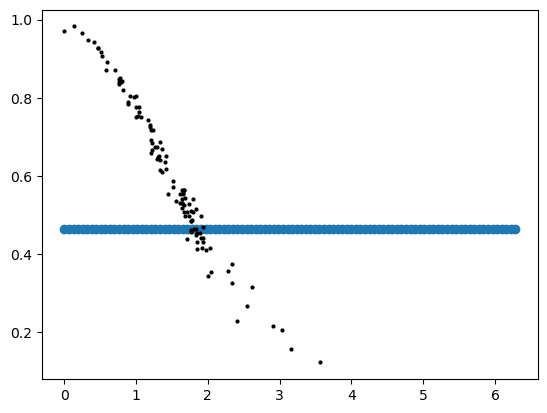

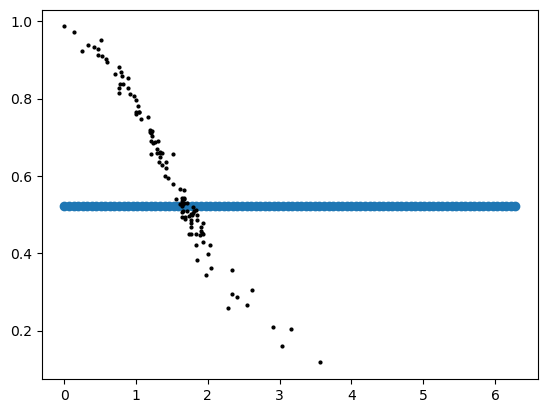

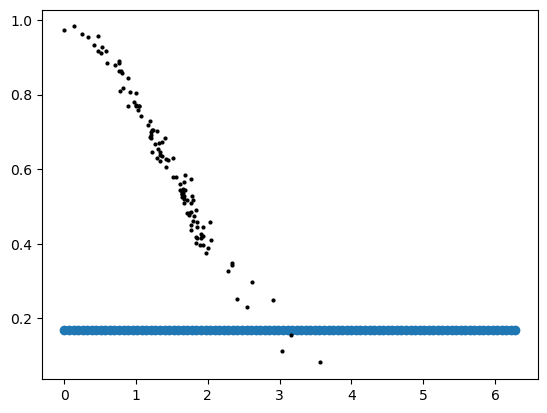

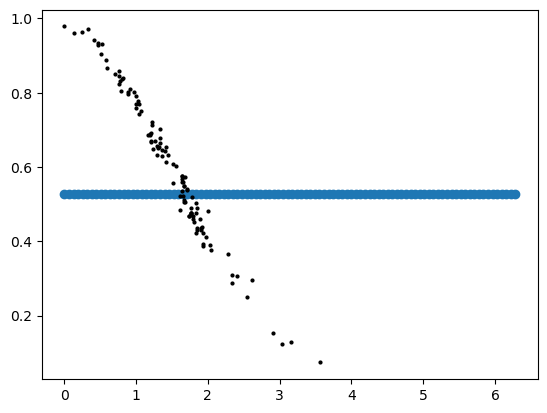

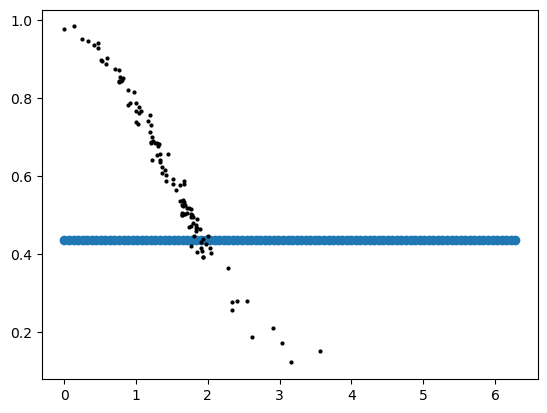

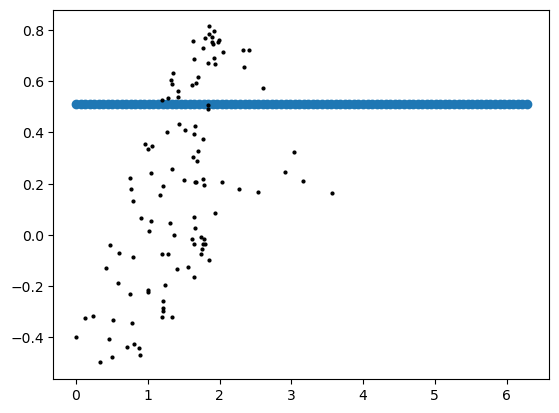

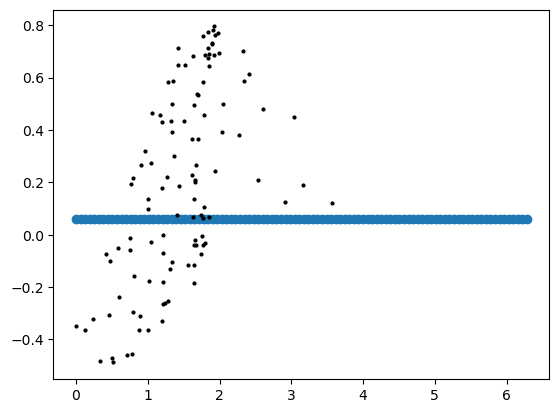

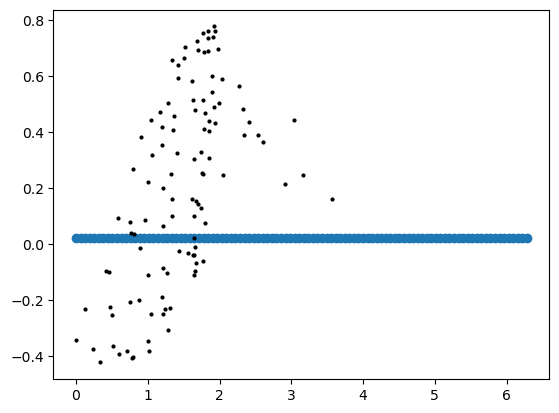

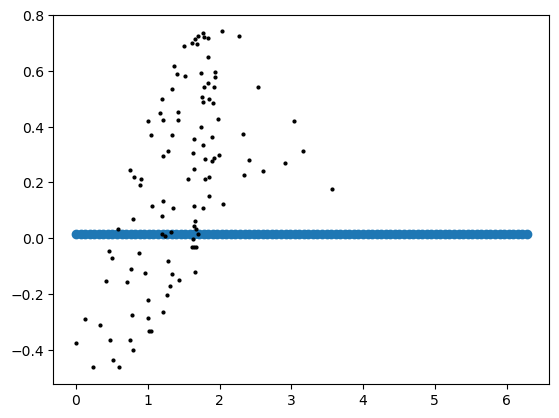

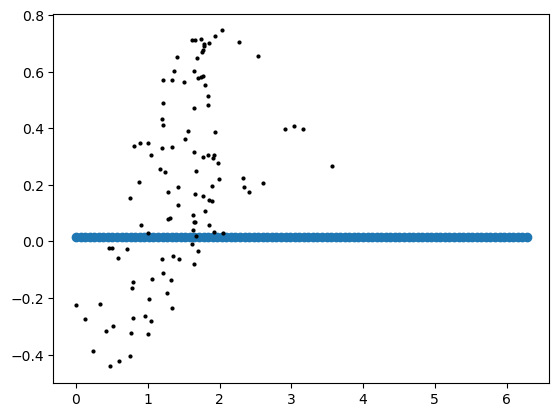

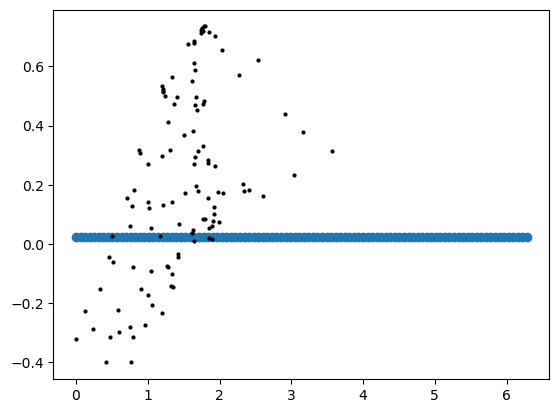

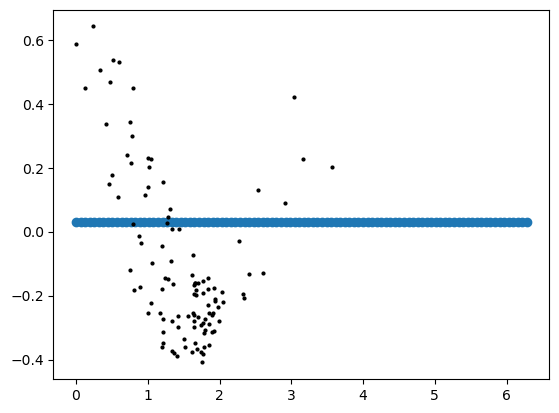

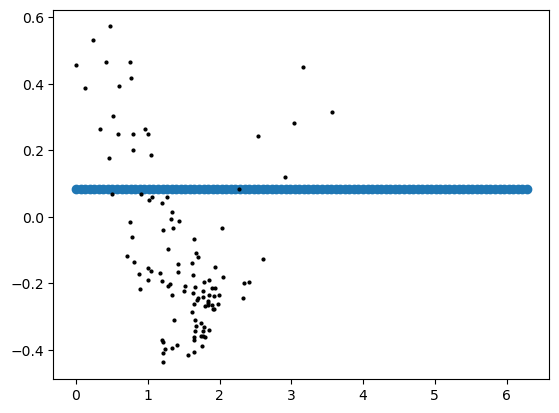

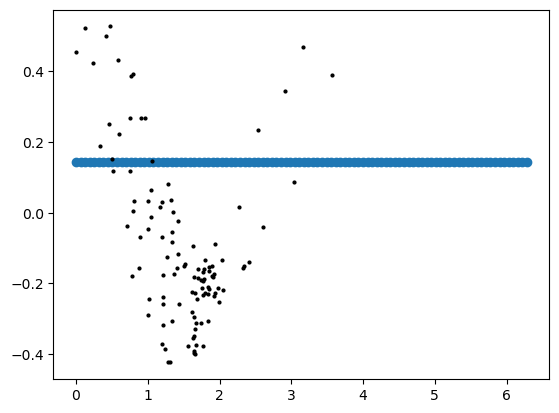

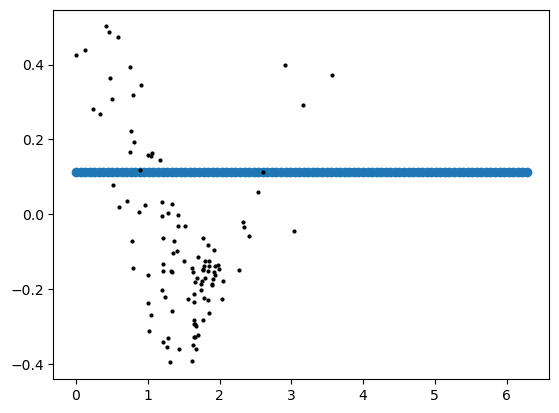

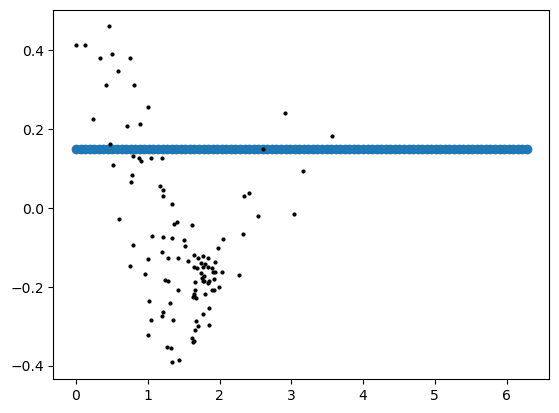

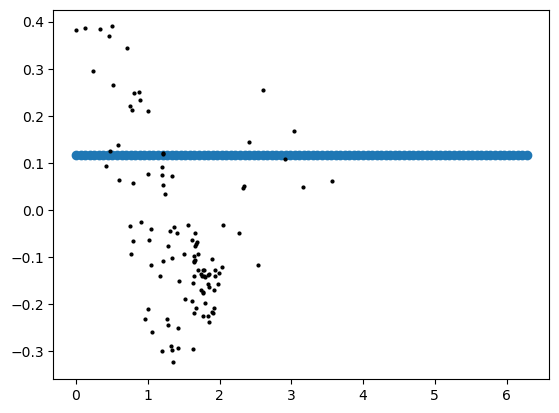

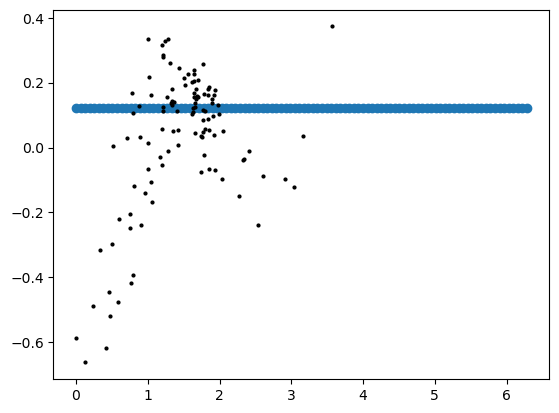

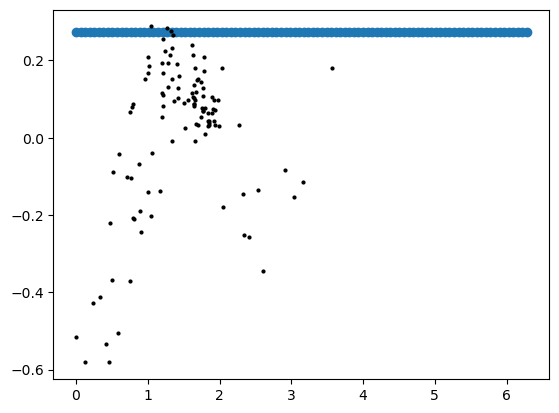

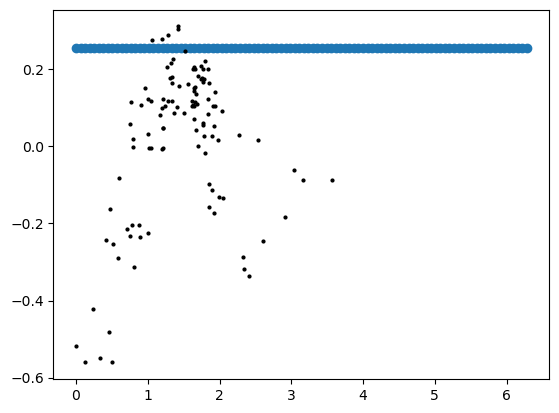

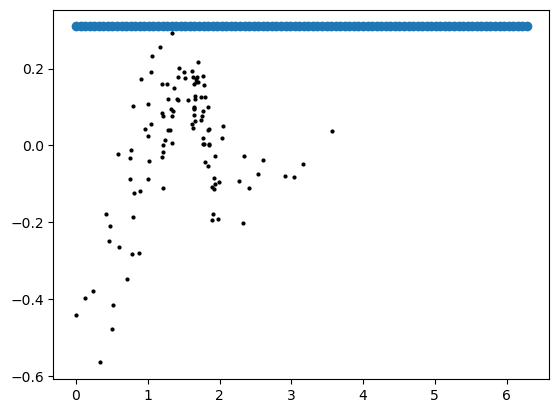

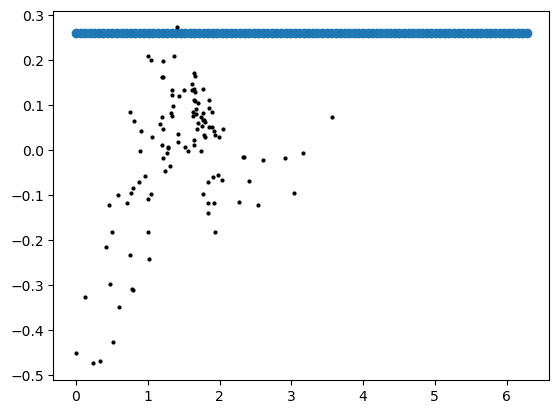

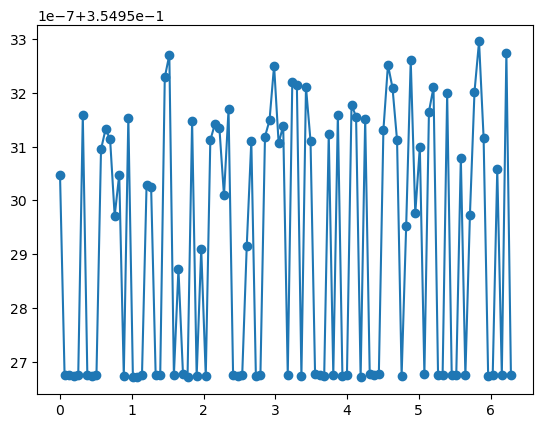

In [49]:
from fitting_folder.wigner import WignerAnalysis
from qutip import fock  
from slab import AttrDict
import matplotlib.pyplot as plt

stor = 7 #storage number from 1
fock_n = 5 #fock numbers from 0
swap_iter = 6 #even swaps from 0
swaps_plot = [2*i for i in range(swap_iter)]

for k in range(stor): #storage number
    fock_dict = {"fock_"+str(fock_n): [] for fock_n in range(fock_n)}

    for j in range(fock_n): #fock states 0 to 4
        photon = j
        fid_results = []
        
        for i in range(swap_iter): #even no. of swaps from 0 to 10
            swaps = 2*i
            prep_man_pi = mm_base_calib.prep_man_photon(man_no=1, photon_no=photon)
            for s in range(swaps):
                prep_man_pi.append(['storage', 'M1-S'+str(k+1), 'pi', 0])  


            pulse = mm_base_calib.get_prepulse_creator(prep_man_pi).pulse.tolist()
            print(f'doing ' + str(swaps) + ' swaps for fock ' + str(photon) + ' in storage ' + str(k+1))
            wigner = do_wigner_tomography_1mode(
                config_thisrun=expts_base_inst.config_thisrun,
                expt_path=expts_base_inst.expt_path,
                config_path=expts_base_inst.config_file,
                displace_length=0.05,
                reps = 1000,
                displacement_path=return_dict['path'],
                prepulse=True,
                pre_sweep_pulse=pulse,
                gate_based = False,
                # relax_delay=8000
                relax_delay=5000
            )

            wigner_analysis = WignerAnalysis(wigner.data, config=wigner.cfg, mode_state_num=10, alphas = wigner.data['alpha'])
            initial_state = (fock(wigner_analysis.m, photon)).unit() 
            allocated_counts = wigner_analysis.bin_ss_data()
            p_e = allocated_counts # Probability of measuring the state |e
            p_g = 1 - allocated_counts  # Probability of measuring the state |g
            plt.plot(np.abs(wigner.data['alpha']), (p_g-p_e), 'o', markersize=2, color='black')
            results = wigner_analysis.wigner_analysis_results((p_g-p_e), initial_state=initial_state, rotate=True)
            print(results['fidelity'])
            fid_results += [results['fidelity']]
            

        print(f'Fidelity-swap results for fock ' +str(j) + ' in storage ' + str(k+1) + ':')
        print(fid_results)
        print(swaps_plot)
        fock_dict['fock_'+str(j)].append(fid_results)

    print(f'Storage {k+1} swap fidelity results:')
    print(fock_dict)
    plt.figure(figsize=(10, 6))    
    for l in range(fock_n):
        fock_i = fock_dict['fock_'+str(l)][0]
        plt.plot(swaps_plot, fock_i, marker='o', label='Fock ' + str(l))
    plt.xlabel('Number of Swaps')
    plt.ylabel('Fidelity')
    plt.title(f'Fidelity vs Number of Swaps for in Storage ' + str(k+1))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Wigner Tomography of |0+2>

In [ ]:
from MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(expts_base_inst.config_thisrun)
prep_02_pulse = []
prep_02_pulse.append(['qubit', 'ge', 'hpi', 0]) # g0 + e0 
prep_02_pulse.append(['qubit', 'ef', 'pi', 0]) # g0 + f0 
prep_02_pulse.append(['qubit', 'ge', 'pi', 0])# e0 + f0
prep_02_pulse.append(['multiphoton', 'f0-g1', 'pi', 0]) # e0 + g1 
prep_02_pulse.append(['multiphoton', 'g0-e0', 'pi', 0]) # g0 + e1
prep_02_pulse.append(['multiphoton', 'e1-f1', 'pi', 0]) # g0 + f1 
prep_02_pulse.append(['multiphoton', 'f1-g2', 'pi', 0]) # g0 + g2
prep_02_pulse
## convert it to low level pulse 
pulse_02 = mm_base_dummy.get_prepulse_creator(prep_02_pulse).pulse.tolist()
pulse_02

[['qubit', 'ge', 'hpi', 0],
 ['qubit', 'ef', 'pi', 0],
 ['qubit', 'ge', 'pi', 0],
 ['multiphoton', 'f0-g1', 'pi', 0],
 ['multiphoton', 'g0-e0', 'pi', 0],
 ['multiphoton', 'e1-f1', 'pi', 0],
 ['multiphoton', 'f1-g2', 'pi', 0]]

## Wigner Tomography of |0> + |1>

### Debugging

##### Histogram Prepulse

In [700]:
def do_histogram_prepulse_experiment(
    reps=10000,
    qubits=[0],
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    preloaded_pulses=False,
    use_arb_waveform=False,
    expts_base_inst=None,
    expt_path=None,
    config_path=None,
    config_thisrun=None,
    relax_delay=2500
):
    """
    Run the Histogram Prepulse Experiment with configurable parameters.
    """
        
    expt_cfg = {
        'reps': reps,
        'qubits': qubits,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'prepulse': prepulse,
        'pre_sweep_pulse': pre_sweep_pulse,
        'gate_based': gate_based,
        'preloaded_pulses': preloaded_pulses,
        'use_arb_waveform': use_arb_waveform
    }
    histogram_exp = expts_base_inst.meas.single_qubit.single_shot_prepulse.HistogramPrepulseExperiment(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='HistogramPrepulseExperiment', config_file=config_path
    )
    histogram_exp.cfg = AttrDict(deepcopy(config_thisrun))
    histogram_exp.cfg.expt = expt_cfg
    histogram_exp.go(analyze=False, display=False, progress=True, save=True)
    return histogram_exp


In [703]:
historgam_exp = do_histogram_prepulse_experiment(
    reps=10000,
    qubits=[0],
    expts_base_inst=expts_base_inst,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    config_thisrun=expts_base_inst.config_thisrun,
    prepulse=True,
    gate_based=True,
    pre_sweep_pulse=[['qubit', 'ge', 'hpi', 0]],  # Use the prepulse pulse created above
)

[[3567.346809921427]
 [4852]
 [0.0]
 [0]
 [2]
 ['gauss']
 [0.035]]


  0%|          | 0/10000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00003_HistogramPrepulseExperiment.h5


In [704]:
historgam_exp.data['I'].shape

(10000,)

Proportion of points below threshold -314: 0.529 (5295/10000)


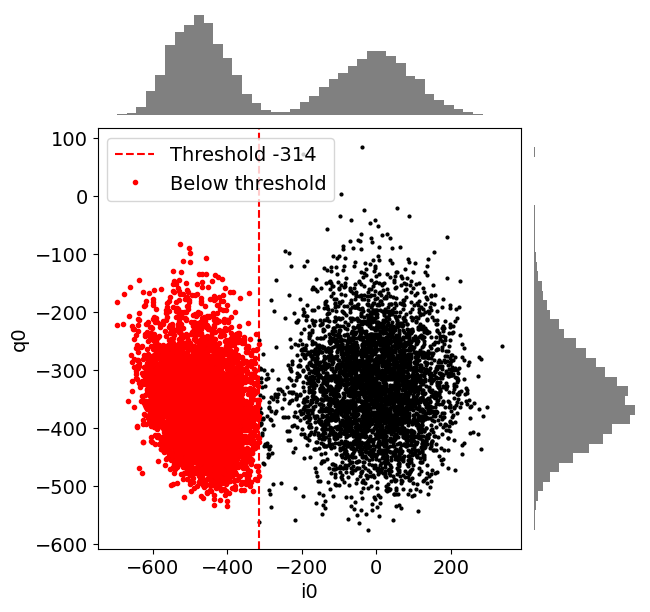

In [705]:
from matplotlib import gridspec


# i, q
# plt.plot(wigner_exp_01.data['i0'][0][0], wigner_exp_01.data['q0'][0][0], 'o', markersize=2, color='black')
# Plot histograms along x and y axes

# Get data
x = historgam_exp.data['I']
y = historgam_exp.data['Q']



# Create a figure with gridspec for scatter and histograms
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                       wspace=0.05, hspace=0.05)

ax_scatter = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

# Scatter plot
ax_scatter.plot(x, y, 'o', markersize=2, color='black')
ax_scatter.set_xlabel('i0')
ax_scatter.set_ylabel('q0')

# X histogram
ax_histx.hist(x, bins=40, color='gray')
ax_histx.axis('off')

# Y histogram
ax_histy.hist(y, bins=40, orientation='horizontal', color='gray')
ax_histy.axis('off')

threshold = -314
below_threshold = x < threshold
proportion_below = np.sum(below_threshold) / len(x)
print(f"Proportion of points below threshold {threshold}: {proportion_below:.3f} ({np.sum(below_threshold)}/{len(x)})")

# Plot threshold line and highlight points below threshold
ax_scatter.axvline(threshold, color='red', linestyle='--', label=f'Threshold {threshold}')
ax_scatter.plot(x[below_threshold], y[below_threshold], 'ro', markersize=3, label='Below threshold')
ax_scatter.legend()

plt.show()

In [645]:
from MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(expts_base_inst.config_thisrun)

prep_01_pulse = [['qubit', 'ge', 'hpi', 0], # g0 + e0 
['qubit', 'ef', 'pi', 0], # g0 + f0 
['multiphoton', 'f0-g1', 'pi', 0]] # e0 + g1 
## convert it to low level pulse 
pulse_01 = mm_base_dummy.get_prepulse_creator(prep_01_pulse).pulse.tolist()
pulse_01

[[3567.346809921427, 3423.9866806417763, 2005.9],
 [4636, 8221, 15000],
 [0.0, 0.0, 1.082052142],
 [0, 0, 0],
 [2, 2, 0],
 ['g', 'g', 'flat_top'],
 [0.035, 0.035, 0.005]]

In [652]:
# choose alphas along 3 axes 
alpha_list = np.linspace(0, 1, 10) 
phase_across_three_axes = np.array([0, 90, 180])  # in degrees
alphas = []
for phase in phase_across_three_axes:
    alphas.append(alpha_list * np.exp(1j * np.deg2rad(phase)))
alpha_list_full = np.concatenate(alphas)
alpha_list_full
f_path = expts_base_inst.expt_path + '\\alphas.npy'
np.save(f_path, alpha_list_full)


In [653]:
alpha_list_full

array([ 0.00000000e+00+0.00000000e+00j,  1.11111111e-01+0.00000000e+00j,
        2.22222222e-01+0.00000000e+00j,  3.33333333e-01+0.00000000e+00j,
        4.44444444e-01+0.00000000e+00j,  5.55555556e-01+0.00000000e+00j,
        6.66666667e-01+0.00000000e+00j,  7.77777778e-01+0.00000000e+00j,
        8.88888889e-01+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  6.80359333e-18+1.11111111e-01j,
        1.36071867e-17+2.22222222e-01j,  2.04107800e-17+3.33333333e-01j,
        2.72143733e-17+4.44444444e-01j,  3.40179666e-17+5.55555556e-01j,
        4.08215600e-17+6.66666667e-01j,  4.76251533e-17+7.77777778e-01j,
        5.44287466e-17+8.88888889e-01j,  6.12323400e-17+1.00000000e+00j,
       -0.00000000e+00+0.00000000e+00j, -1.11111111e-01+1.36071867e-17j,
       -2.22222222e-01+2.72143733e-17j, -3.33333333e-01+4.08215600e-17j,
       -4.44444444e-01+5.44287466e-17j, -5.55555556e-01+6.80359333e-17j,
       -6.66666667e-01+8.16431199e-17j, -7.77777778

In [668]:
# Now doing wigner tomography at these 3 points of 0 + 1
wigner_exp_01 = do_wigner_tomography_1mode(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    displace_length=0.05,
    reps = 5000,
    displacement_path=f_path,
    prepulse=True,
    pre_sweep_pulse=pulse_01,
    gate_based = False,
    relax_delay=2500
)

man mode no: 1


  0%|          | 0/30 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00025_WignerTomography1ModeExperiment.h5


In [669]:
wigner_analysis = WignerAnalysis(wigner_exp_01.data, config=wigner_exp_01.cfg, mode_state_num=10, alphas = wigner_exp_01.data['alpha'])
initial_state = (fock(wigner_analysis.m, 1)  + fock(wigner_analysis.m, 0)).unit() # Initial state |0> ?? 1,2, o4 [1,2]
allocated_counts = wigner_analysis.bin_ss_data()
p_e = allocated_counts # Probability of measuring the state |e
p_g = 1 - allocated_counts  # Probability of measuring the state |g
wigner_expec = 2/np.pi * (p_g - p_e)  # Wigner expectation value

(5000, 30)


In [670]:
wigner_expec

array([0.08557926, 0.1117689 , 0.17499438, 0.20515214, 0.22314098,
       0.27287484, 0.261235  , 0.24377524, 0.2257864 , 0.16070913,
       0.10250994, 0.11917607, 0.15912188, 0.18531151, 0.17896251,
       0.25462145, 0.22076011, 0.23345811, 0.17869797, 0.17393621,
       0.11203344, 0.09430914, 0.12367328, 0.13372587, 0.15621192,
       0.20726848, 0.20859119, 0.20356489, 0.16361909, 0.15224379])

slice(0, 10, None)
slice(10, 20, None)
slice(20, 30, None)


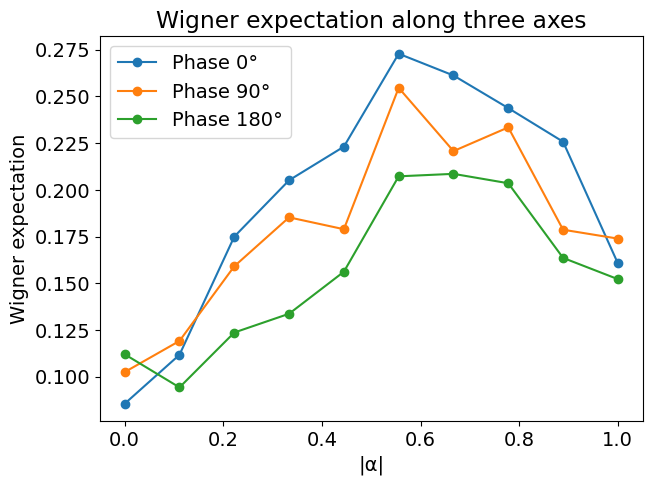

In [671]:
import numpy as np

wigner_exp_01.data['alpha']
# the array above contains alphas along the three axes, for each axes plot the corresponding wigner exppec
# I expec 3 traces on a single plot, one for each angle 
import matplotlib.pyplot as plt

alphas = wigner_exp_01.data['alpha']
wigner_expec = 2/np.pi * (p_g - p_e)

# There are 3 axes, so split the data accordingly
num_axes = 3
N = len(alphas) // num_axes

plt.figure(figsize=(7, 5))
for i, phase in enumerate(phase_across_three_axes):
    idx = slice(i*N, (i+1)*N)
    print(idx)
    plt.plot(np.abs(alphas[idx]), wigner_expec[idx], 'o-', label=f'Phase {phase}°')
plt.xlabel('|α|')
plt.ylabel('Wigner expectation')
plt.title('Wigner expectation along three axes')
plt.legend()
plt.show()

In [661]:
np.shape(wigner_exp_01.data['i0'])

(30, 1, 1000)

Proportion of points below threshold -300: 0.575 (575/1000)


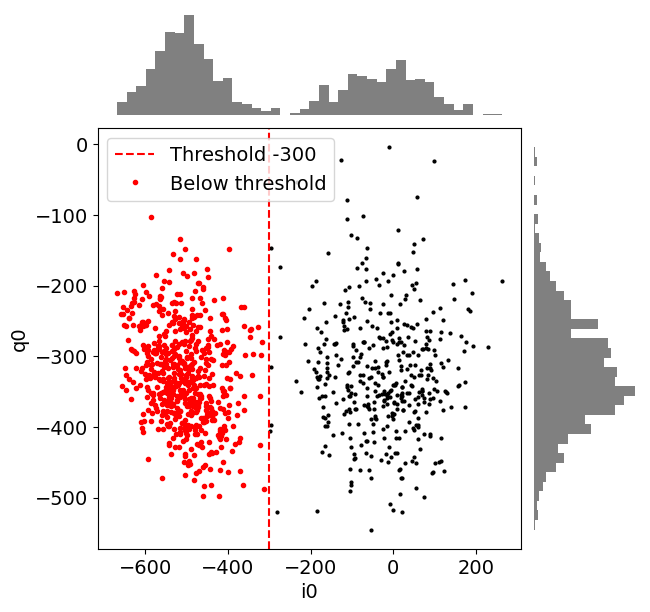

In [667]:
from matplotlib import gridspec


# i, q
# plt.plot(wigner_exp_01.data['i0'][0][0], wigner_exp_01.data['q0'][0][0], 'o', markersize=2, color='black')
# Plot histograms along x and y axes

# Get data
x = wigner_exp_01.data['i0'][0][0]
y = wigner_exp_01.data['q0'][0][0]



# Create a figure with gridspec for scatter and histograms
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                       wspace=0.05, hspace=0.05)

ax_scatter = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_scatter)

# Scatter plot
ax_scatter.plot(x, y, 'o', markersize=2, color='black')
ax_scatter.set_xlabel('i0')
ax_scatter.set_ylabel('q0')

# X histogram
ax_histx.hist(x, bins=40, color='gray')
ax_histx.axis('off')

# Y histogram
ax_histy.hist(y, bins=40, orientation='horizontal', color='gray')
ax_histy.axis('off')

threshold = -300
below_threshold = x < threshold
proportion_below = np.sum(below_threshold) / len(x)
print(f"Proportion of points below threshold {threshold}: {proportion_below:.3f} ({np.sum(below_threshold)}/{len(x)})")

# Plot threshold line and highlight points below threshold
ax_scatter.axvline(threshold, color='red', linestyle='--', label=f'Threshold {threshold}')
ax_scatter.plot(x[below_threshold], y[below_threshold], 'ro', markersize=3, label='Below threshold')
ax_scatter.legend()

plt.show()

In [ ]:
# 

In [663]:
wigner_exp_01.cfg.device.readout

{'trig_offset': [450],
 'frequency': [748.8],
 'gain': [800],
 'phase': [29.79028008324773],
 'threshold': [-301.7609374000881],
 'threshold_list': [[-301.7609374000881]],
 'man1_drive_list': [0.0],
 'man2_drive_list': [0.0],
 'readout_length': [1.5],
 'relax_delay': [2500],
 'confusion_matrix_with_reset': [0.9964530022802125,
  0.0035469977197875036,
  0.013768302080657598,
  0.9862316979193424],
 'confusion_matrix_without_reset': [0.9886,
  0.011399999999999966,
  0.026,
  0.974],
 'Ie': [-11.637201631964007],
 'Ig': [-501.760937400088]}

### Normal

In [24]:
from MM_dual_rail_base import MM_dual_rail_base
mm_base_dummy = MM_dual_rail_base(expts_base_inst.config_thisrun)

prep_01_pulse = [['qubit', 'ge', 'hpi', 0], # g0 + e0 
['qubit', 'ef', 'pi', 0], # g0 + f0 
['multiphoton', 'f0-g1', 'pi', 0]] # e0 + g1 
## convert it to low level pulse 
pulse_01 = mm_base_dummy.get_prepulse_creator(prep_01_pulse).pulse.tolist()
pulse_01

multiphoton_cfg 3567.3608840739785
Adding pulse ['ge', 'hpi', 0] to channel qubit
Adding pulse ['ef', 'pi', 0] to channel qubit
Adding pulse ['f0-g1', 'pi', 0] to channel multiphoton


[[3567.3506008394015, 3423.990931159239, 2005.8600000000006],
 [5003, 9161, 15000],
 [0.0, 0.0, 1.0955314021401903],
 [0, 0, 0],
 [2, 2, 0],
 ['g', 'g', 'flat_top'],
 [0.035, 0.035, 0.005]]

In [25]:
wigner_exp_01 = do_wigner_tomography_1mode(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    displace_length=0.05,
    reps = 1000,
    displacement_path=return_dict['path'],
    prepulse=True,
    pre_sweep_pulse=pulse_01,
    gate_based = False
)

man mode no: 1
gain2alpha: 0.0002753329059097354
displace_sigma: 0.05


  0%|          | 0/93 [00:00<?, ?it/s]

multiphoton_cfg 3567.3608840739785
Adding pulse ['ge', 'hpi', 0] to channel qubit
Adding pulse ['ge', 'parity_M1', 0] to channel qubit
Adding pulse ['ge', 'hpi', 180] to channel qubit
multiphoton_cfg 3567.3608840739785
Adding pulse ['g0-e0', 'hpi', 0] to channel multiphoton
Adding pulse ['ge', 'parity_M1', 0] to channel qubit
Adding pulse ['g0-e0', 'hpi', 180] to channel multiphoton
multiphoton_cfg 3567.3608840739785
Adding pulse ['ge', 'hpi', 0] to channel qubit
Adding pulse ['ge', 'parity_M1', 0] to channel qubit
Adding pulse ['ge', 'hpi', 180] to channel qubit
multiphoton_cfg 3567.3608840739785
Adding pulse ['g0-e0', 'hpi', 0] to channel multiphoton
Adding pulse ['ge', 'parity_M1', 0] to channel qubit
Adding pulse ['g0-e0', 'hpi', 180] to channel multiphoton
multiphoton_cfg 3567.3608840739785
Adding pulse ['ge', 'hpi', 0] to channel qubit
Adding pulse ['ge', 'parity_M1', 0] to channel qubit
Adding pulse ['ge', 'hpi', 180] to channel qubit
multiphoton_cfg 3567.3608840739785
Adding pu

In [26]:
from fitting_folder.wigner import WignerAnalysis
from qutip import fock  
from slab import AttrDict
wigner_analysis = WignerAnalysis(wigner_exp_01.data, config=wigner_exp_01.cfg, mode_state_num=2, alphas = wigner_exp_01.data['alpha'])
initial_state = (fock(wigner_analysis.m, 1)  + fock(wigner_analysis.m, 0)).unit() # Initial state |0> ?? 1,2, o4 [1,2]
allocated_counts = wigner_analysis.bin_ss_data()
p_e = allocated_counts # Probability of measuring the state |e
p_g = 1 - allocated_counts  # Probability of measuring the state |g

(1000, 93)


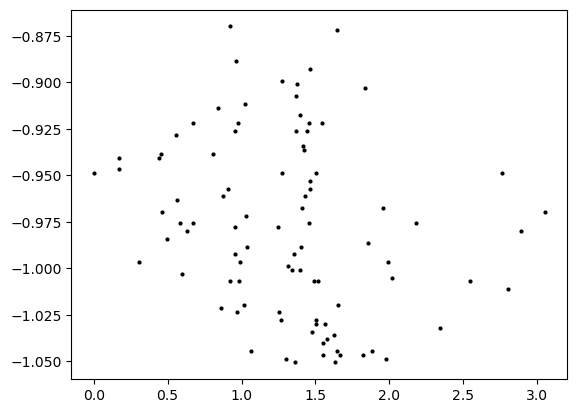

In [27]:
plt.plot(np.abs(wigner_exp_01.data['alpha']), (p_g-p_e), 'o', markersize=2, color='black')

MLE Fidelity:  0.669569174120082
supertitle is  Text(0.5, 0.98, 'MLE Fidelity: 0.6696')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-07-01_18-15-51_0+1.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-07-01.md


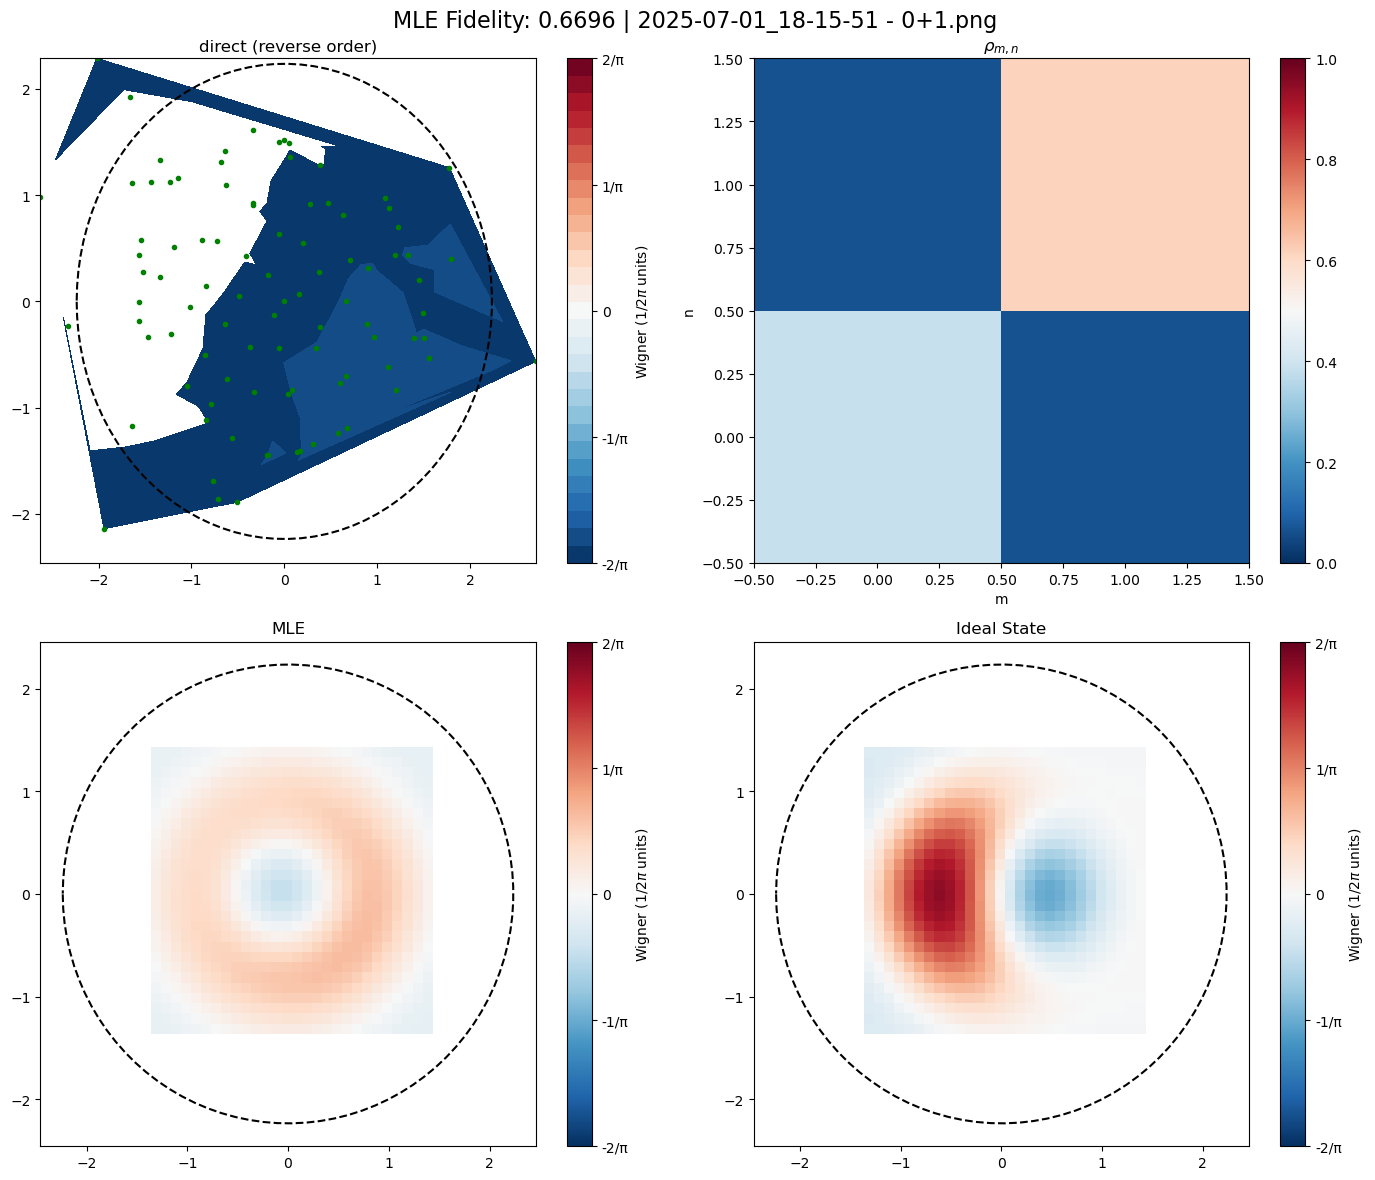

In [28]:
results = wigner_analysis.wigner_analysis_results((p_g -p_e), initial_state=initial_state)
fig = wigner_analysis.plot_wigner_reconstruction_results(results, initial_state=initial_state, state_label = '0+1')

In [431]:
wigner_exp_02 = do_wigner_tomography_1mode(
    config_thisrun=expts_base_inst.config_thisrun,
    expt_path=expts_base_inst.expt_path,
    config_path=expts_base_inst.config_file,
    displace_length=0.05,
    reps = 200,
    displacement_path=return_dict['path'],
    prepulse=True,
    pre_sweep_pulse=pulse_02,
    gate_based = False
)

man mode no: 1


  0%|          | 0/261 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00009_WignerTomography1ModeExperiment.h5


In [469]:
from fitting_folder.wigner import WignerAnalysis
from qutip import fock  
from slab import AttrDict
wigner_analysis = WignerAnalysis(wigner_exp_02.data, config=wigner_exp_02.cfg, mode_state_num=10, alphas = wigner_exp.data['alpha'])
initial_state = (fock(wigner_analysis.m, 2)  + fock(wigner_analysis.m, 0)).unit() # Initial state |0> ?? 1,2, o4 [1,2]
allocated_counts = wigner_analysis.bin_ss_data()
p_e = allocated_counts # Probability of measuring the state |e
p_g = 1 - allocated_counts  # Probability of measuring the state |g

(200, 261)


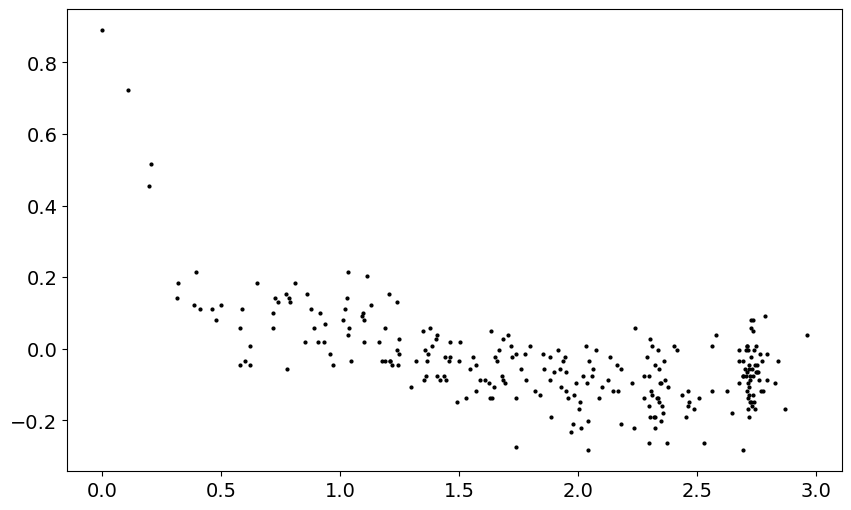

In [433]:
plt.plot(np.abs(wigner_exp_02.data['alpha']), (p_g-p_e), 'o', markersize=2, color='black')

MLE Fidelity:  0.5187873609386402
supertitle is  Text(0.5, 0.98, 'MLE Fidelity: 0.5188')
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-06-18_17-37-35_0+2.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-06-18.md


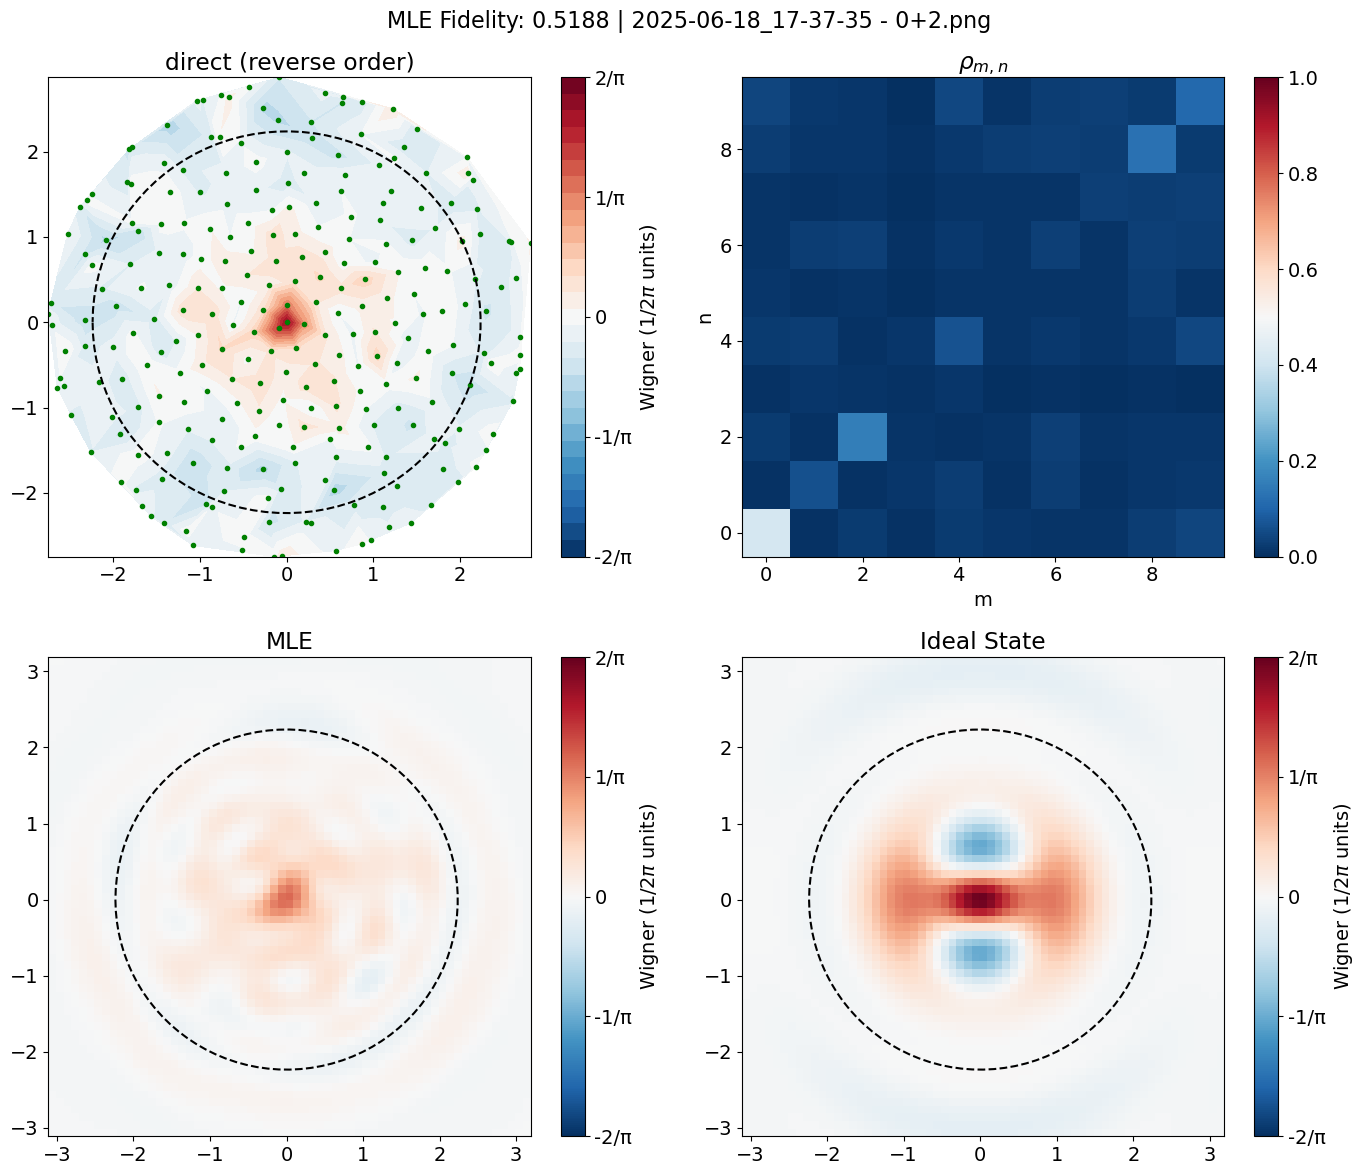

In [470]:
results = wigner_analysis.wigner_analysis_results((p_g -p_e), initial_state=initial_state)
fig = wigner_analysis.plot_wigner_reconstruction_results(results, initial_state=initial_state, state_label = '0+2')

In [415]:
expts_base_inst.soc.deg2reg(180, 0)

2147483648

In [413]:
expts_base_inst.soc.deg2reg(180)

2147483648

In [ ]:
from qutip import wigner, fock, displace
import numpy as np
from matplotlib.ticker import MultipleLocator, FuncFormatter

import matplotlib.pyplot as plt




# Define parameters
N = 15  # Hilbert space dimension
n = 2 # Fock state |n>
xvec = np.linspace(-3, 3, 200)
yvec = np.linspace(-3, 3, 200)
X, Y = np.meshgrid(xvec, yvec)
alpha = X + 1j * Y

# Create Fock state
psi = fock(N, n)

# Compute Wigner function
W = wigner(psi, xvec, yvec)

# Plot
fig, ax = plt.subplots(figsize=(6, 5))
c = ax.pcolormesh(X, Y, W, cmap='RdBu_r', shading='auto', vmin=-2/np.pi, vmax=2/np.pi)
ax.set_xlabel('Re(α)')
ax.set_ylabel('Im(α)')
ax.set_title(f'Wigner function for Fock state |{n}>')
cb = fig.colorbar(c, ax=ax)
cb.set_label('Wigner function')
cb.set_ticks([-2/np.pi, 0, 2/np.pi])
plt.show()

# Save Config

In [548]:
expts_base_inst.recursive_compare(expts_base_inst.yaml_cfg, expts_base_inst.config_thisrun)

Key 'device.manipulate.gain_to_alpha' differs:
  Old value (config1): [0.000201904580286975, 0.00020045]
  New value (config2): [0.0002753329059097354, 0.00020045]


In [549]:
expts_base_inst.handle_config_update(updateConfig_bool=True)

Comparing configurations:
Key 'device.manipulate.gain_to_alpha' differs:
  Old value (config1): [0.000201904580286975, 0.00020045]
  New value (config2): [0.0002753329059097354, 0.00020045]
Directory created for autocalibration plots at: H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\autocalibration_plots_2025-06-19
Configuration updated and saved, excluding storage_man_file. 
!!!!Please set updateConfig to False after this run!!!!!!.


In [341]:
mm_base_dummy.multiphoton_cfg.pulses

{'hpi_e0-f0': {'frequency': 3423.986852,
  'gain': 3858,
  'length': 0,
  'sigma': 0.035,
  'type': 'gauss'},
 'hpi_e1-f1': {'frequency': 3423.724467,
  'gain': 3859,
  'length': 0,
  'sigma': 0.035,
  'type': 'gauss'},
 'hpi_e2-f2': {'frequency': 3423.444467,
  'gain': 3860,
  'length': 0,
  'sigma': 0.035,
  'type': 'gauss'},
 'hpi_g0-e0': {'frequency': 3567.3506008394015,
  'gain': 10075,
  'length': 0,
  'sigma': 0.02,
  'type': 'gauss'},
 'hpi_g1-e1': {'frequency': 3567.0780640454495,
  'gain': 4648,
  'length': 0,
  'sigma': 0.035,
  'type': 'gauss'},
 'hpi_g2-e2': {'frequency': 3566.7980640454493,
  'gain': 2518,
  'length': 0,
  'sigma': 0.035,
  'type': 'gauss'},
 'pi_e0-f0': {'frequency': 3423.986852,
  'gain': 8221,
  'length': 0,
  'sigma': 0.035,
  'type': 'gauss'},
 'pi_e1-f1': {'frequency': 3423.724467,
  'gain': 8276,
  'length': 0,
  'sigma': 0.035,
  'type': 'gauss'},
 'pi_e2-f2': {'frequency': 3423.444467,
  'gain': 8326,
  'length': 0,
  'sigma': 0.035,
  'type': 'g

# Debbugging error amplification

In [88]:
def do_error_amplification(
    reps=100,
    rounds=1,
    qubits=[0],
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    expts_base_inst=None,
    expt_path=None,
    config_path=None,
    config_thisrun=None,
    relax_delay=2500, 
    start = 0,
    stop = 1000,
    step = 100,
    pulse_type=['qubit', 'ge', 'pi', 0],
):
    """
    Run the Histogram Prepulse Experiment with configurable parameters.
    """
        
    expt_cfg = {
        'reps': reps,
        'qubits': qubits,
        'active_reset': active_reset,
        'man_reset': man_reset,
        'storage_reset': storage_reset,
        'start': start,
        'stop': stop,
        'step': step,
        'pulse_type': pulse_type,
        'rounds': rounds,

    }
    error_amp_exp = expts_base_inst.meas.single_qubit.error_amplification(
        soccfg=expts_base_inst.soc, path=expt_path, prefix='ErrorAmplificationExperiment', config_file=config_path
    )
    error_amp_exp.cfg = AttrDict(deepcopy(config_thisrun))
    error_amp_exp.cfg.expt = expt_cfg
    error_amp_exp.go(analyze=False, display=False, progress=True, save=True)
    return error_amp_exp

In [89]:
do_error_amplification(
    reps=100,
    rounds=1,
)

AttributeError: 'NoneType' object has no attribute 'meas'

In [93]:
expts_base_inst.meas.single_qubit.error_amplification

AttributeError: module 'experiments.single_qubit' has no attribute 'error_amplification'